In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [ ]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Now you can use the Kaggle API to download the dataset
kaggle_username = "joosthazelzet"
dataset_name = "lego-brick-images"

# Create the Kaggle dataset URL
dataset_url = f"{kaggle_username}/{dataset_name}"

# Download the dataset using Kaggle API
!kaggle datasets download -d $dataset_url

# Unzip the downloaded dataset
!unzip -q {dataset_name}.zip -d {dataset_name}

 99% 0.99G/1.00G [00:10<00:00, 41.3MB/s]
100% 1.00G/1.00G [00:10<00:00, 101MB/s] 


In [ ]:
train_data = utils.image_dataset_from_directory(
    "/content/lego-brick-images/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


The original data is scaled in the range [0, 255] to denote the pixel intensity. When
training GANs we rescale the data to the range [–1, 1] so that we can use the tanh
activation function on the final layer of the generator, which tends to provide stron‐
ger gradients than the sigmoid function

In [ ]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

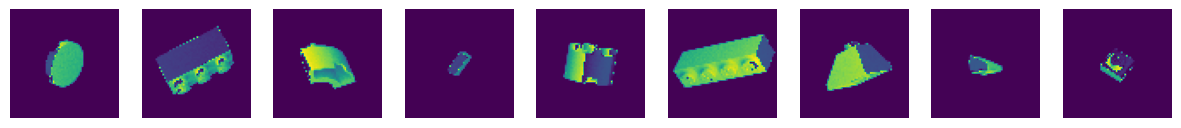

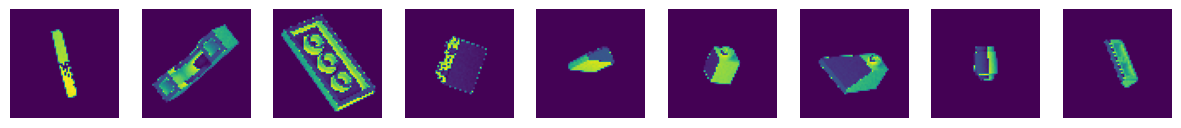

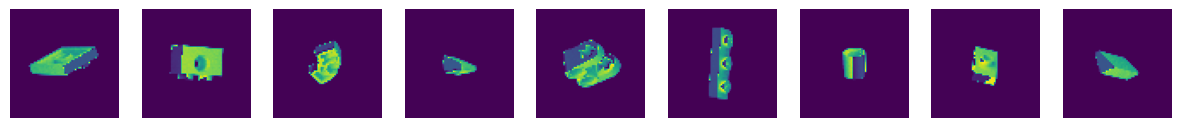

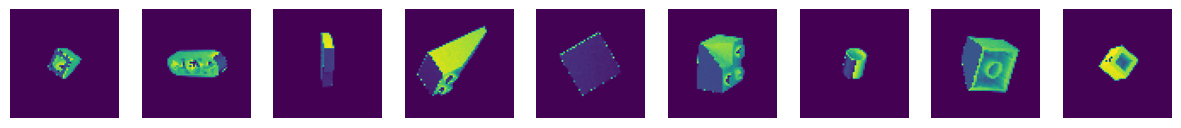

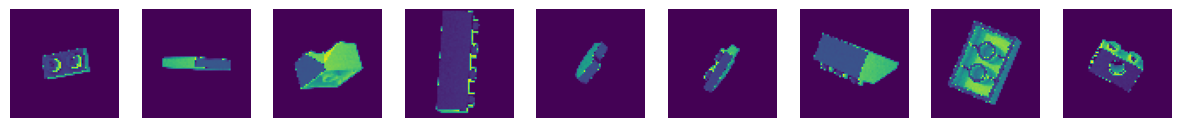

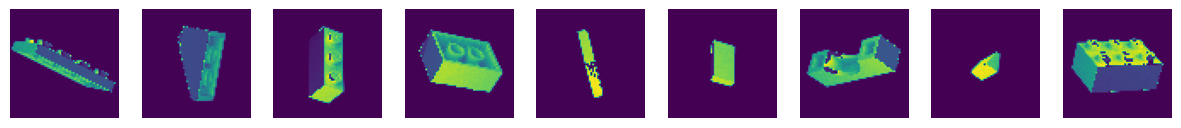

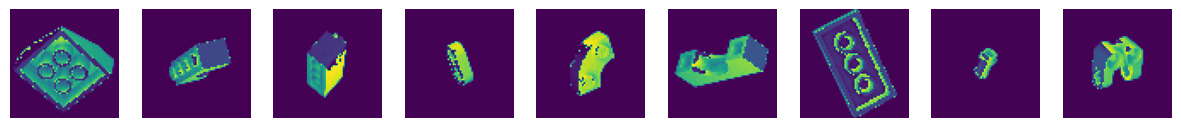

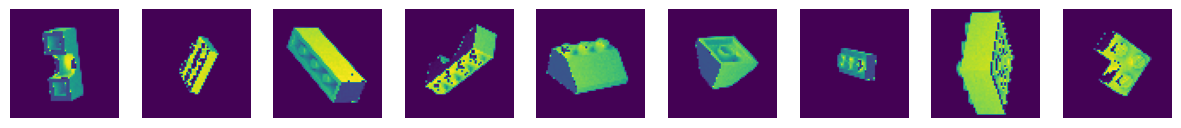

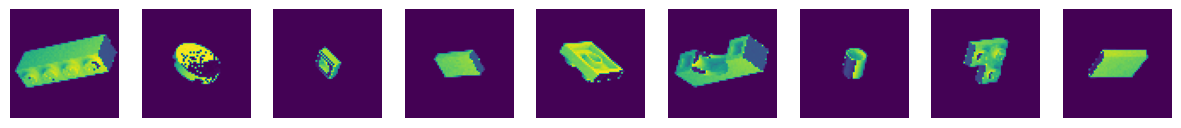

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to display images
def display_images(images, cmap=None):
    plt.figure(figsize=(15, 15))
    for j in range(9):
        brick_img = images[j].numpy()
        brick_img = np.array(brick_img * 255, dtype=np.uint8)  # Convert back to uint8 for display
        plt.subplot(990 + 1 + j)
        plt.imshow(brick_img, cmap=cmap)
        plt.axis('off')
    plt.show()

# Display random images from the 'train' dataset
for k in range(9):
    train_sample = next(iter(train.take(1)))
    display_images(train_sample, cmap=None)

# The Discriminator

The goal of the discriminator is to predict if an image is real or fake. This is a super‐
vised image classification problem

In [ ]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

Flatten the last convolutional layer—by this point, the shape of the tensor is 1 × 1
× 1, so there is no need for a final Dense layer.


# The Generator

The input to the generator will be a vector drawn from
a multivariate standard normal distribution. The output is an image of the same size
as an image in the original training data.


This description may remind you of the decoder in a variational autoencoder. In fact,
the generator of a GAN fulfills exactly the same purpose as the decoder of a VAE:
converting a vector in the latent space to an image. The concept of mapping from a
latent space back to the original domain is very common in generative modeling, as it
gives us the ability to manipulate vectors in the latent space to change high-level fea‐
tures of images in the original domain.

In [ ]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

The final Conv2DTranspose layer uses a tanh activation function to transform the
output to the range [–1, 1], to match the original image domain.

Upsampling Versus Conv2DTranspose


An alternative to using Conv2DTranspose layers is to instead use an UpSampling2D
layer followed by a normal Conv2D layer with stride 1

 Upsampling example
x = layers.UpSampling2D(size = 2)(x)
x = layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)


The UpSampling2D layer simply repeats each row and column of its input in order to
double the size. The Conv2D layer with stride 1 then performs the convolution operation. It is a similar idea to convolutional transpose, but instead of filling the gaps
between pixels with zeros, upsampling just repeats the existing pixel values.


It has been shown that the Conv2DTranspose method can lead to artifacts, or small
checkerboard patterns in the output image that spoil the quality of
the output

Both of these methods—UpSampling2D + Conv2D and Conv2DTranspose—are accepta‐
ble ways to transform back to the original image domain. It really is a case of testing
both methods in your own problem setting and seeing which produces better results.

# Training DCGAN

We can train the discriminator by creating a training set where some of the images
are real observations from the training set and some are fake outputs from the gener‐
ator. We then treat this as a supervised learning problem, where the labels are 1 for
the real images and 0 for the fake images, with binary cross-entropy as the loss
function.

We can generate a batch of images and pass these
through the discriminator to get a score for each image. The loss function for the
generator is then simply the binary cross-entropy between these probabilities and a vector of ones, because we want to train the generator to produce images that the dis‐
criminator thinks are real.

Crucially, we must alternate the training of these two networks, making sure that we
only update the weights of one network at a time. For example, during the generator
training process, only the generator’s weights are updated. If we allowed the discrimi‐
nator’s weights to change as well, the discriminator would just adjust so that it is more
likely to predict the generated images to be real, which is not the desired outcome.
We want generated images to be predicted close to 1 (real) because the generator is
strong, not because the discriminator is weak.

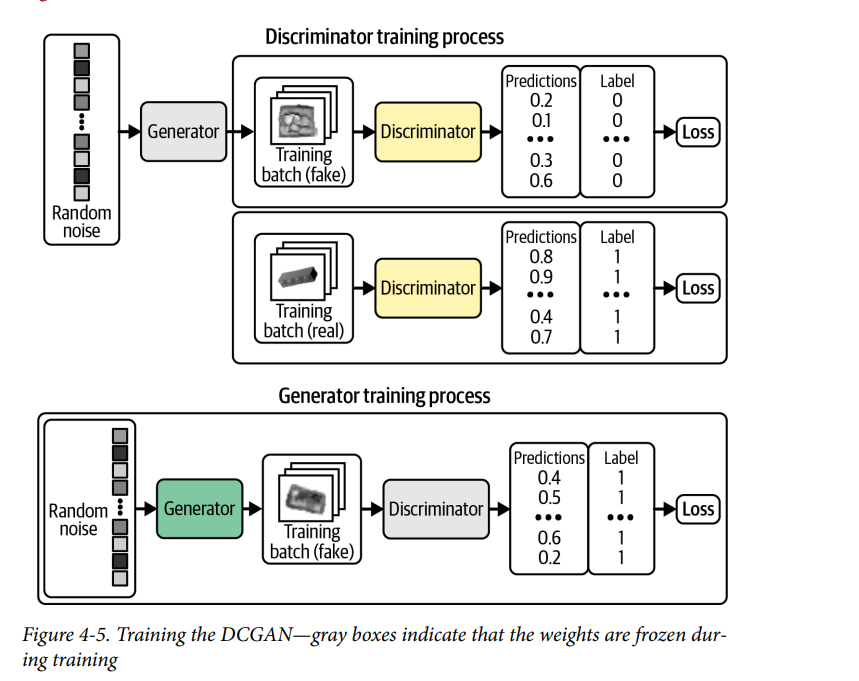

Adding Noise to the Labels


A useful trick when training GANs is to add a small amount of ran‐
dom noise to the training labels. This helps to improve the stability
of the training process and sharpen the generated images. This
label smoothing acts as way to tame the discriminator, so that it is
presented with a more challenging task and doesn’t overpower the
generator.

In [ ]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)

            real_predictions = self.discriminator(real_images, training=True)

            fake_predictions = self.discriminator(generated_images, training=True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))

            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

The loss function for the generator and discriminator is BinaryCrossentropy.

To train the network, first sample a batch of vectors from a multivariate standard
normal distribution.

Next, pass these through the generator to produce a batch of generated images.

Now ask the discriminator to predict the realness of the batch of real images…
…and the batch of generated images.

The discriminator loss is the average binary cross-entropy across both the real
images (with label 1) and the fake images (with label 0).

The generator loss is the binary cross-entropy between the discriminator predic‐
tions for the generated images and a label of 1.

In [ ]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

            plt.show()

Epoch 1/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0840 - d_real_acc: 0.8737 - d_fake_acc: 0.8831 - d_acc: 0.8784 - g_loss: 6.3618 - g_acc: 0.1169

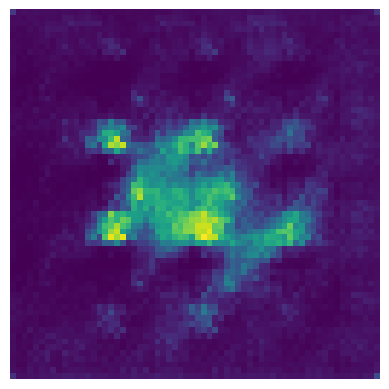

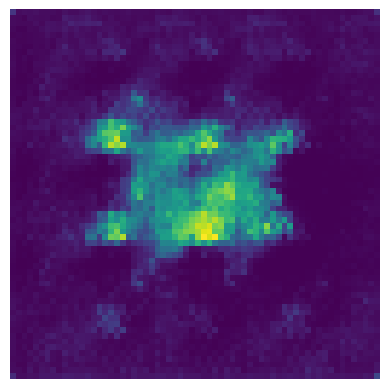

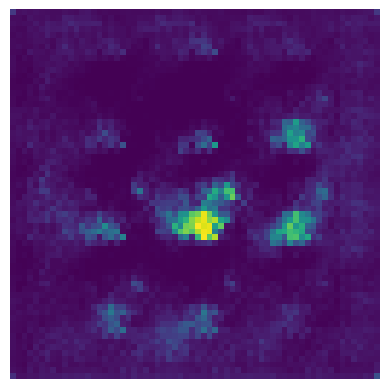

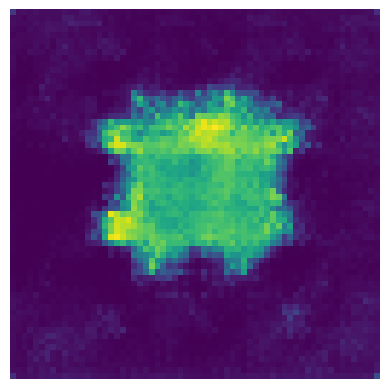

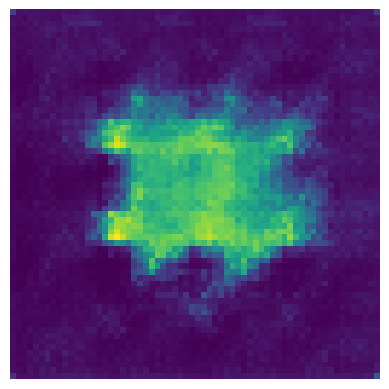

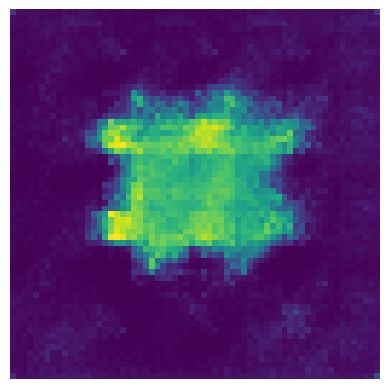

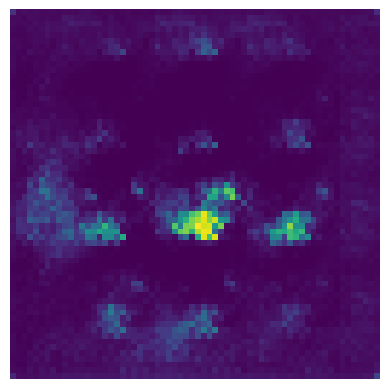

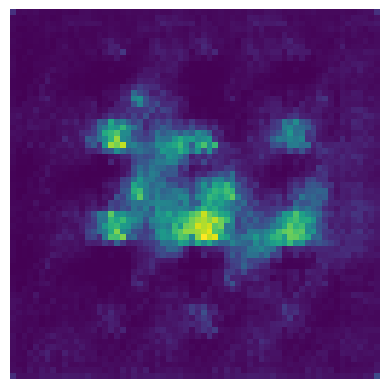

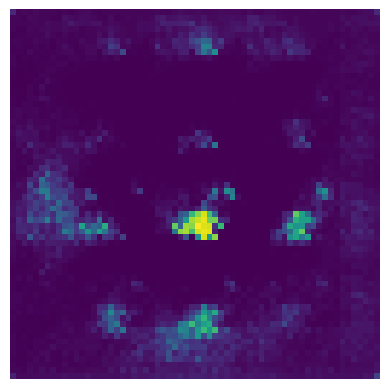

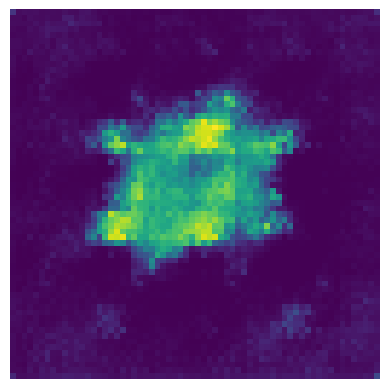

313/313 [==============================] - 87s 230ms/step - d_loss: 0.0840 - d_real_acc: 0.8737 - d_fake_acc: 0.8831 - d_acc: 0.8784 - g_loss: 6.3618 - g_acc: 0.1169
Epoch 2/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1185 - d_real_acc: 0.8834 - d_fake_acc: 0.9007 - d_acc: 0.8920 - g_loss: 4.3329 - g_acc: 0.0993

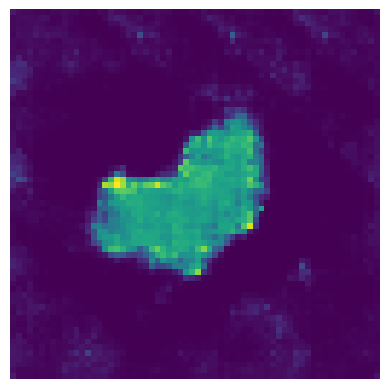

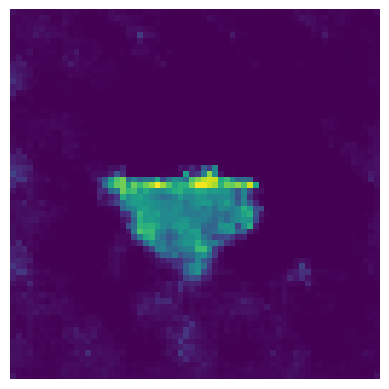

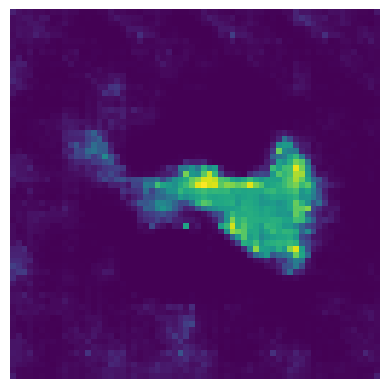

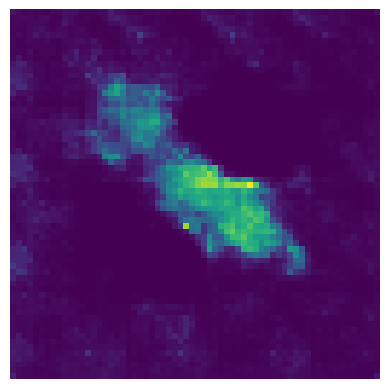

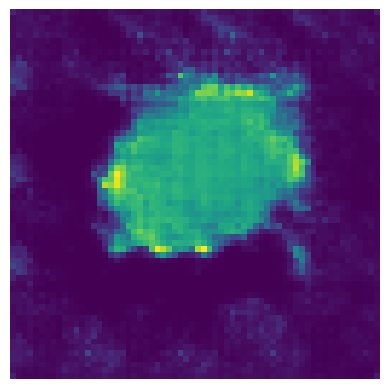

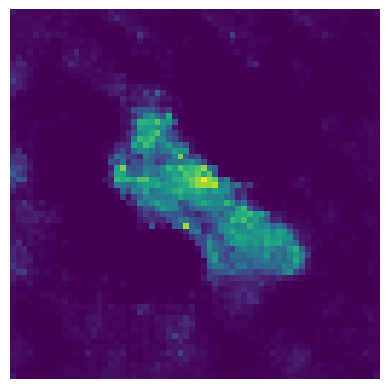

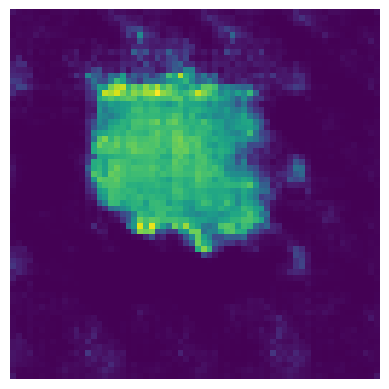

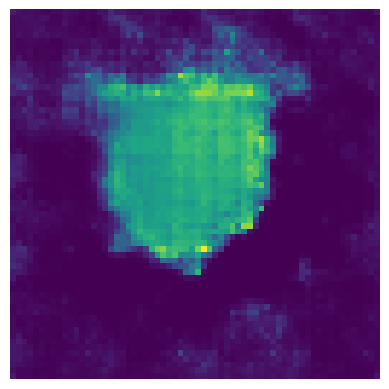

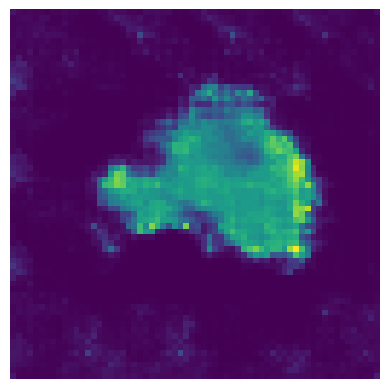

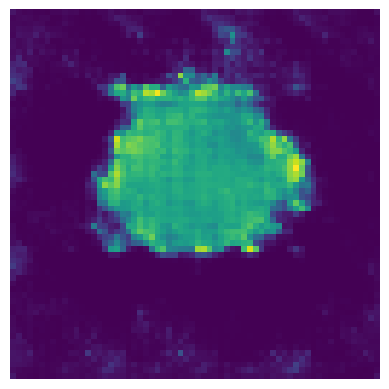

313/313 [==============================] - 73s 229ms/step - d_loss: 0.1185 - d_real_acc: 0.8834 - d_fake_acc: 0.9007 - d_acc: 0.8920 - g_loss: 4.3329 - g_acc: 0.0993
Epoch 3/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0819 - d_real_acc: 0.8852 - d_fake_acc: 0.8882 - d_acc: 0.8867 - g_loss: 4.9324 - g_acc: 0.1117

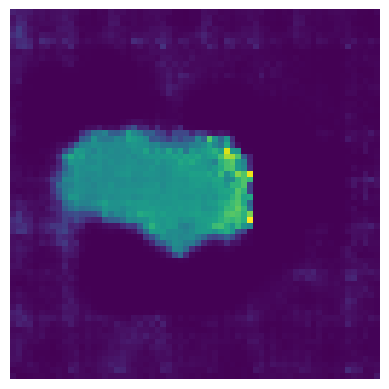

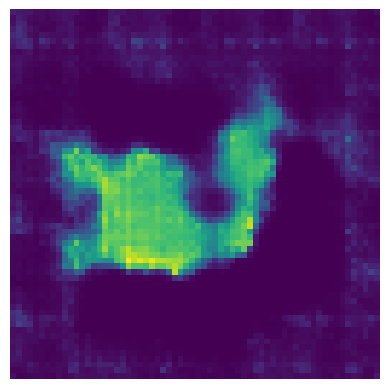

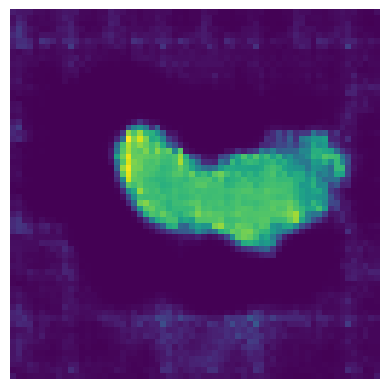

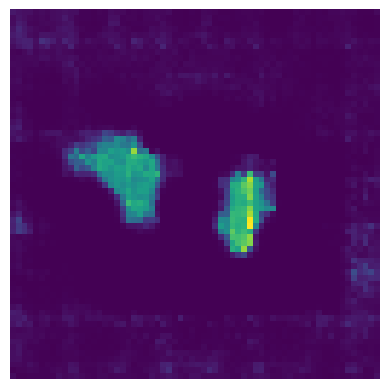

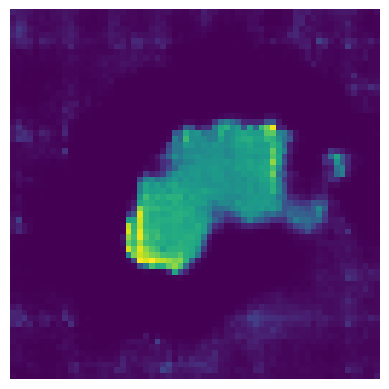

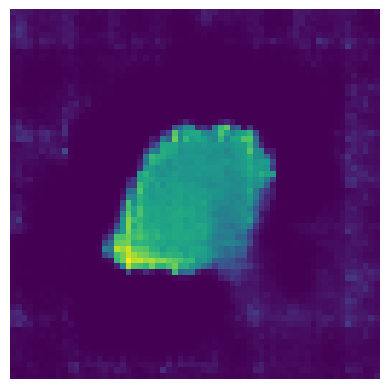

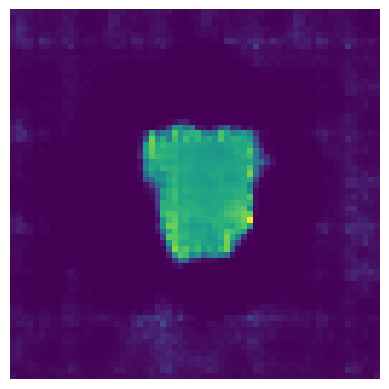

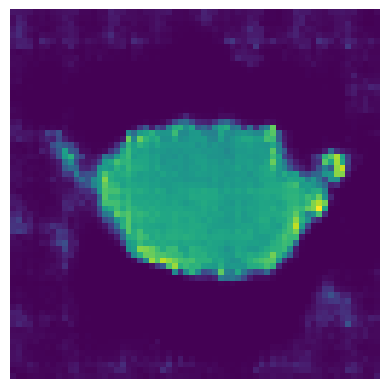

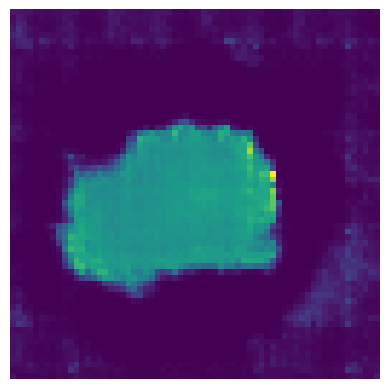

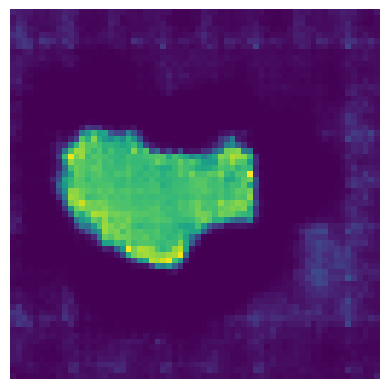

313/313 [==============================] - 73s 230ms/step - d_loss: 0.0819 - d_real_acc: 0.8852 - d_fake_acc: 0.8882 - d_acc: 0.8867 - g_loss: 4.9324 - g_acc: 0.1117
Epoch 4/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1602 - d_real_acc: 0.8711 - d_fake_acc: 0.8713 - d_acc: 0.8712 - g_loss: 4.0144 - g_acc: 0.1287

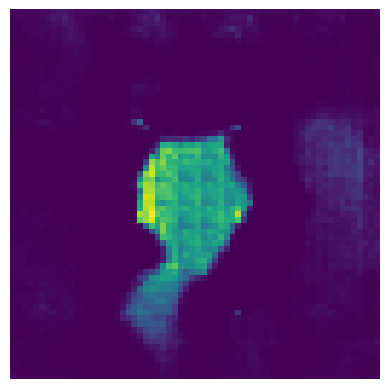

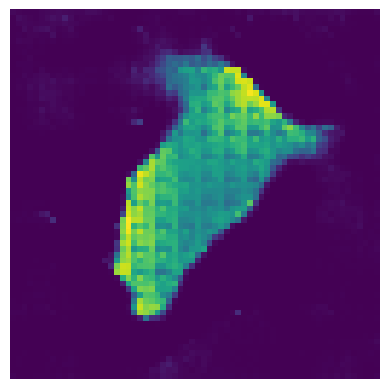

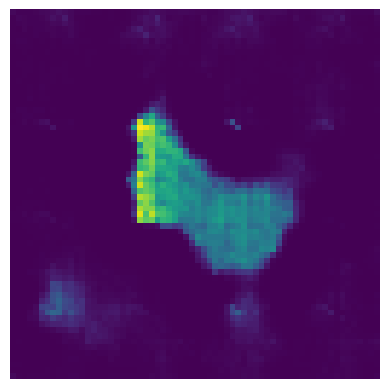

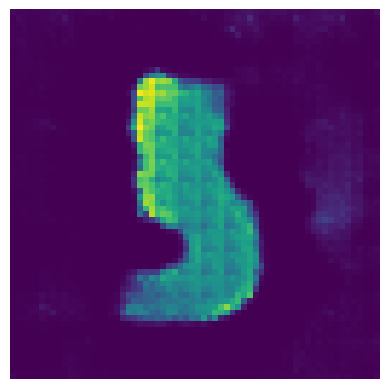

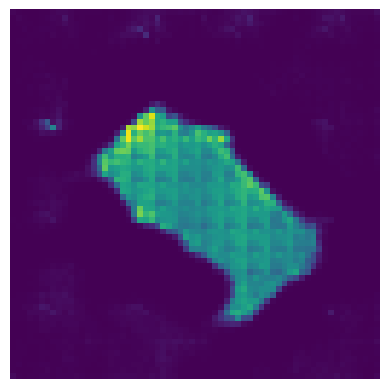

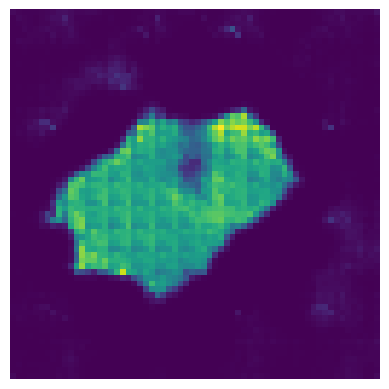

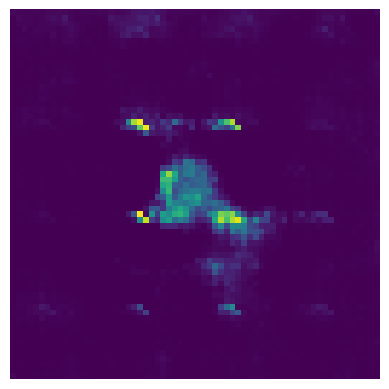

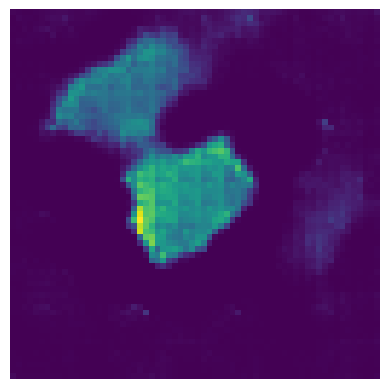

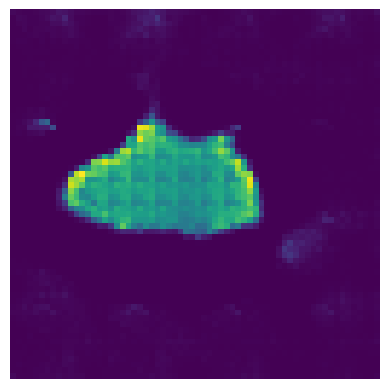

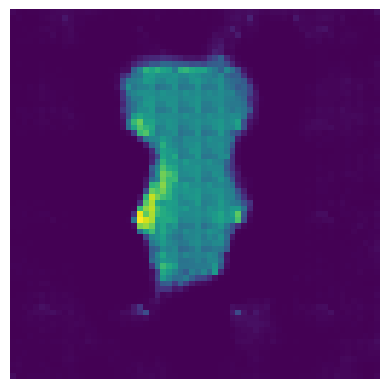

313/313 [==============================] - 73s 229ms/step - d_loss: 0.1602 - d_real_acc: 0.8711 - d_fake_acc: 0.8713 - d_acc: 0.8712 - g_loss: 4.0144 - g_acc: 0.1287
Epoch 5/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1243 - d_real_acc: 0.8837 - d_fake_acc: 0.8874 - d_acc: 0.8855 - g_loss: 4.1207 - g_acc: 0.1126

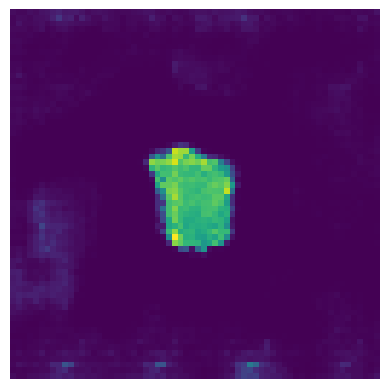

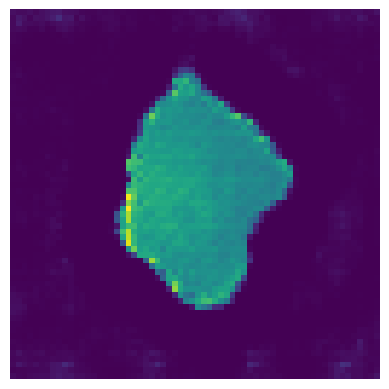

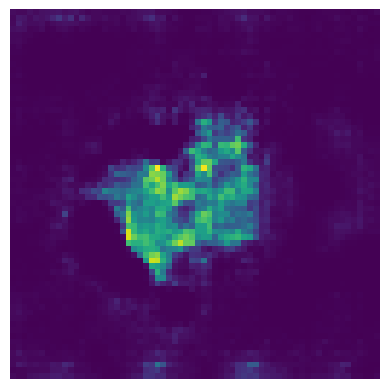

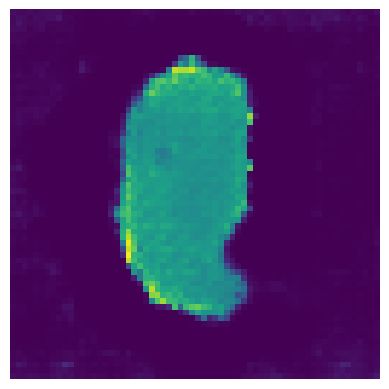

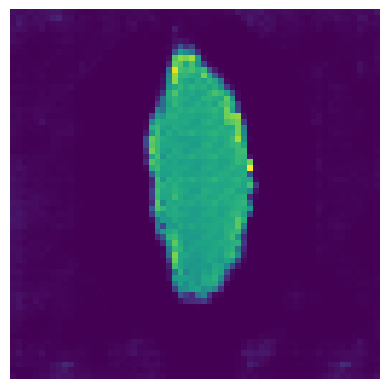

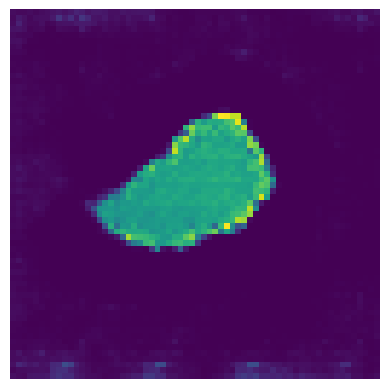

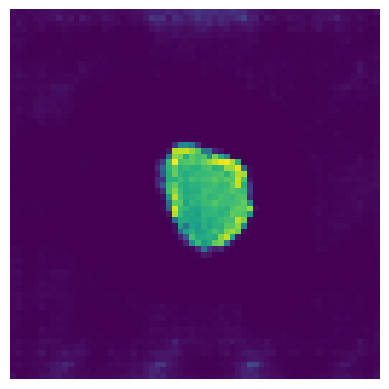

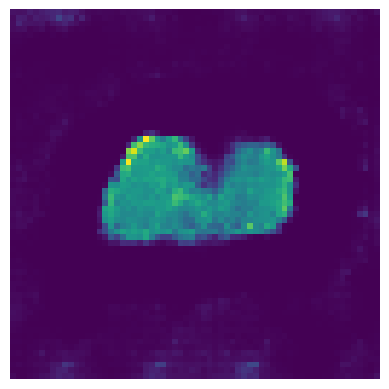

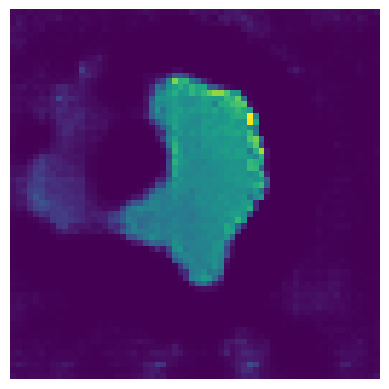

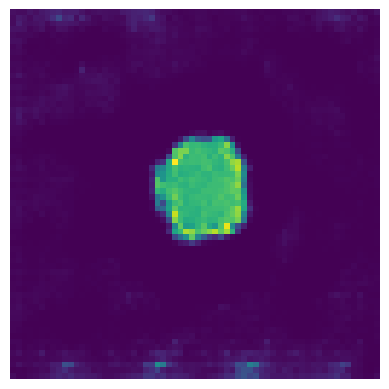

313/313 [==============================] - 74s 230ms/step - d_loss: 0.1243 - d_real_acc: 0.8837 - d_fake_acc: 0.8874 - d_acc: 0.8855 - g_loss: 4.1207 - g_acc: 0.1126
Epoch 6/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0836 - d_real_acc: 0.8990 - d_fake_acc: 0.8965 - d_acc: 0.8978 - g_loss: 4.2169 - g_acc: 0.1035

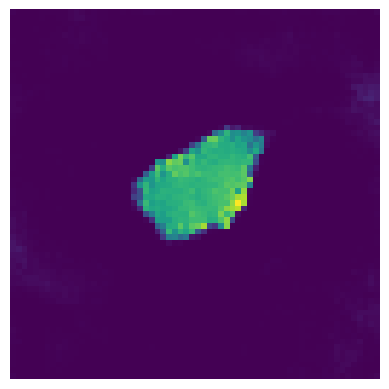

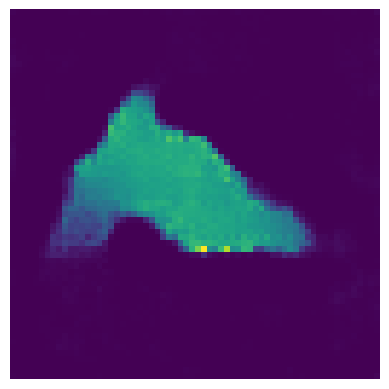

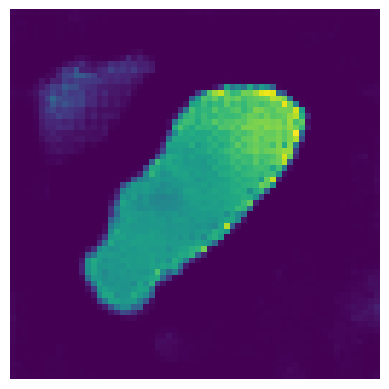

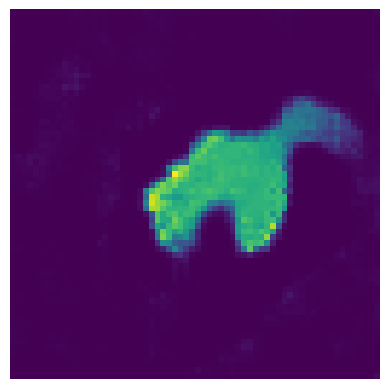

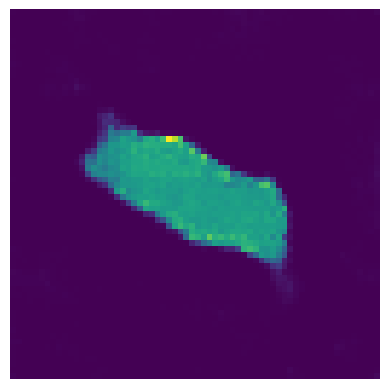

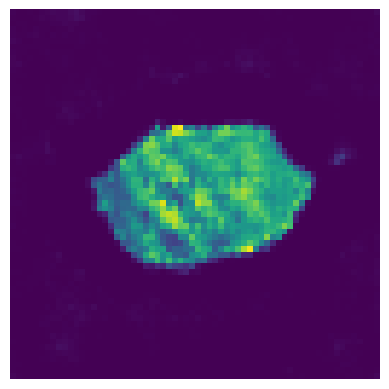

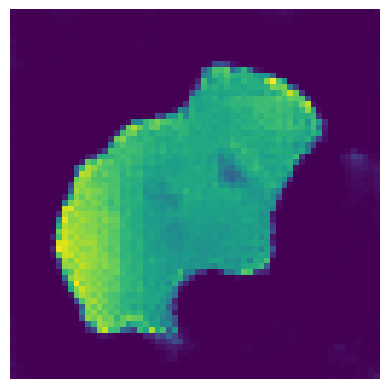

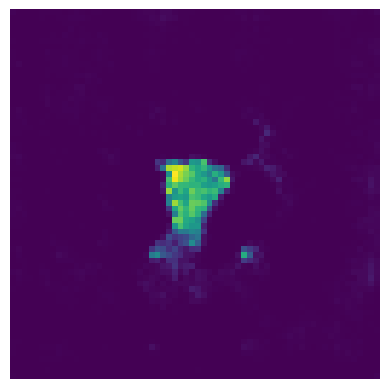

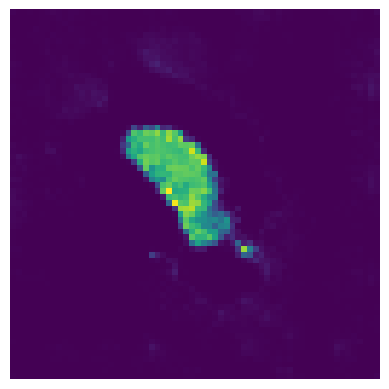

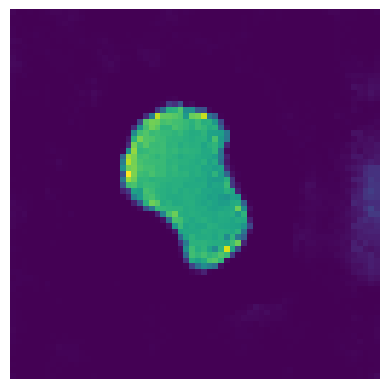

313/313 [==============================] - 74s 233ms/step - d_loss: 0.0836 - d_real_acc: 0.8990 - d_fake_acc: 0.8965 - d_acc: 0.8978 - g_loss: 4.2169 - g_acc: 0.1035
Epoch 7/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0927 - d_real_acc: 0.8912 - d_fake_acc: 0.8940 - d_acc: 0.8926 - g_loss: 4.5432 - g_acc: 0.1060

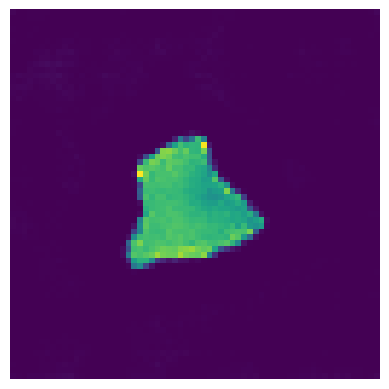

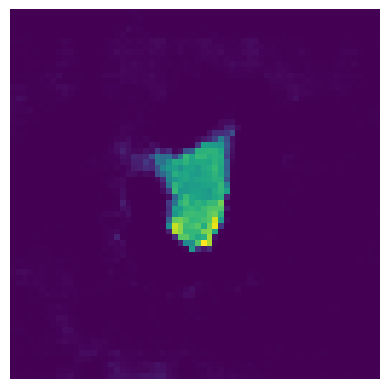

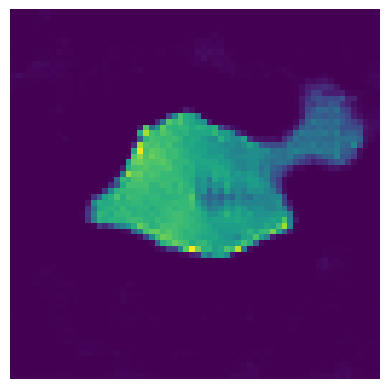

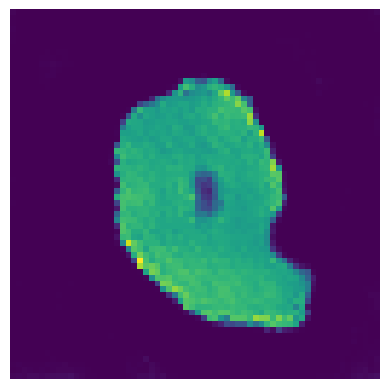

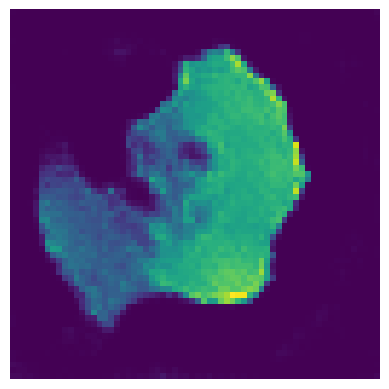

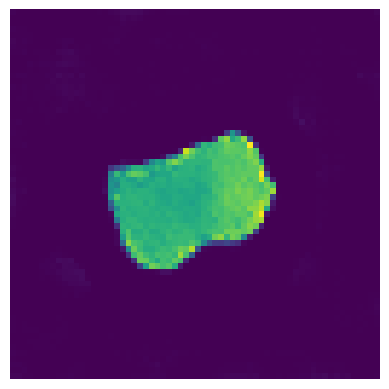

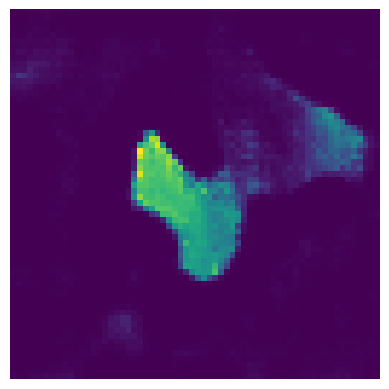

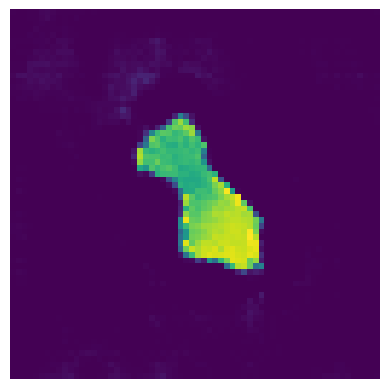

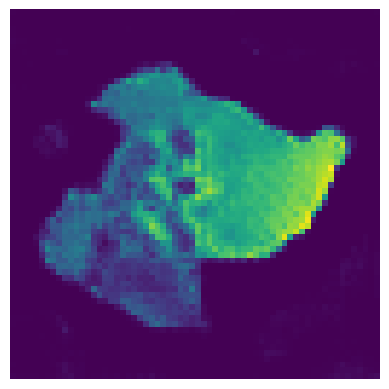

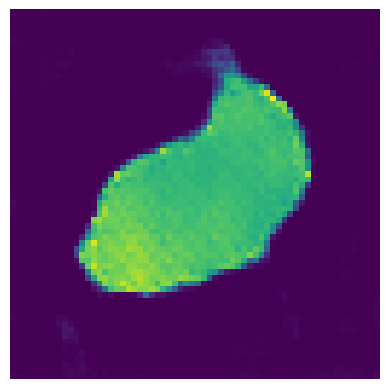

313/313 [==============================] - 74s 233ms/step - d_loss: 0.0927 - d_real_acc: 0.8912 - d_fake_acc: 0.8940 - d_acc: 0.8926 - g_loss: 4.5432 - g_acc: 0.1060
Epoch 8/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0591 - d_real_acc: 0.9041 - d_fake_acc: 0.9034 - d_acc: 0.9038 - g_loss: 4.6126 - g_acc: 0.0966

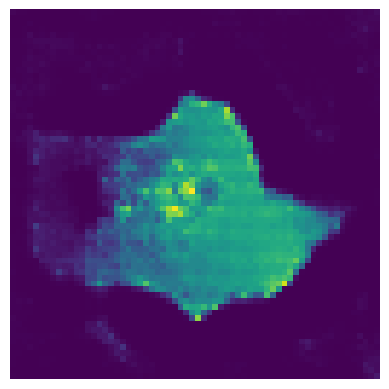

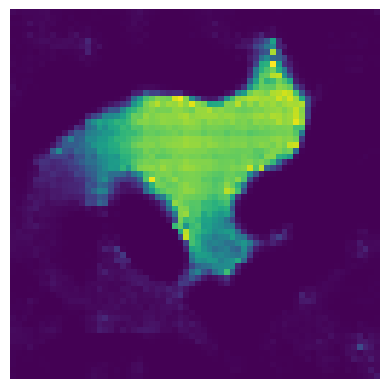

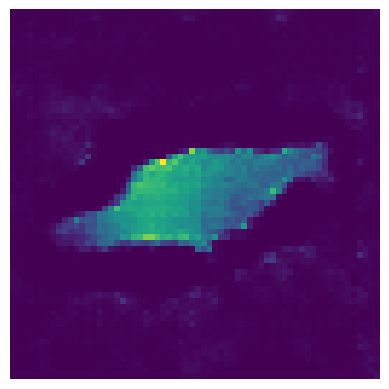

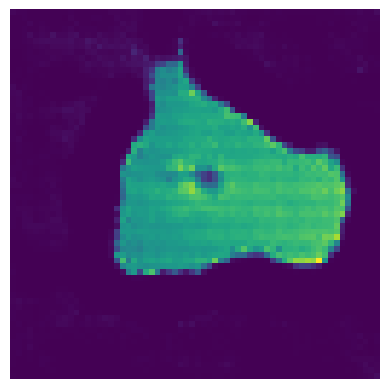

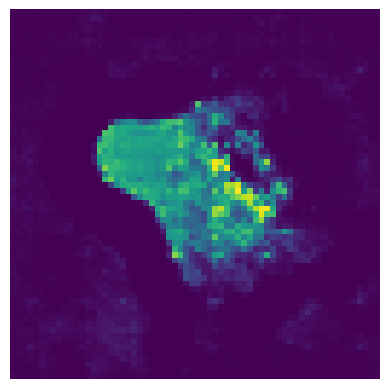

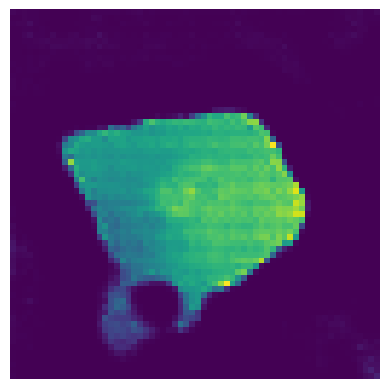

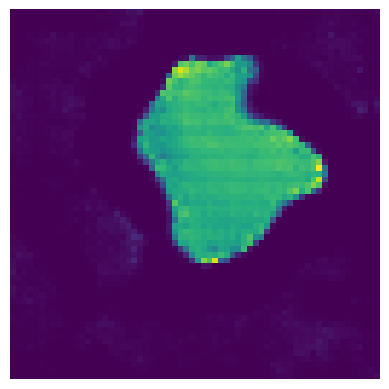

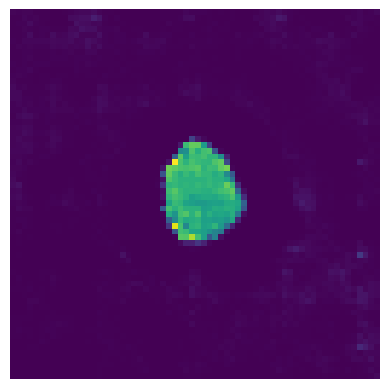

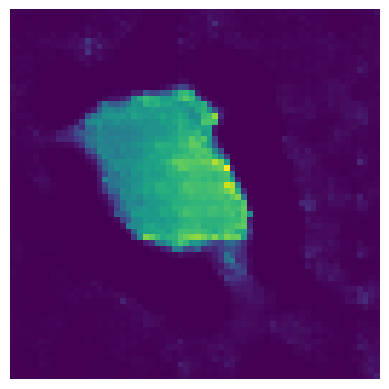

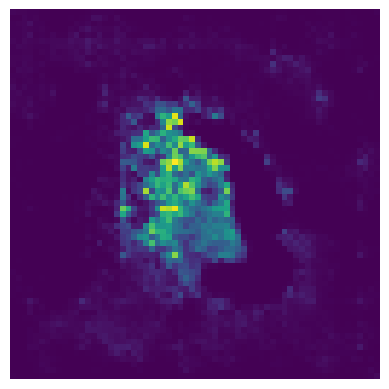

313/313 [==============================] - 74s 234ms/step - d_loss: 0.0591 - d_real_acc: 0.9041 - d_fake_acc: 0.9034 - d_acc: 0.9038 - g_loss: 4.6126 - g_acc: 0.0966
Epoch 9/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0646 - d_real_acc: 0.8992 - d_fake_acc: 0.8980 - d_acc: 0.8986 - g_loss: 4.8538 - g_acc: 0.1020

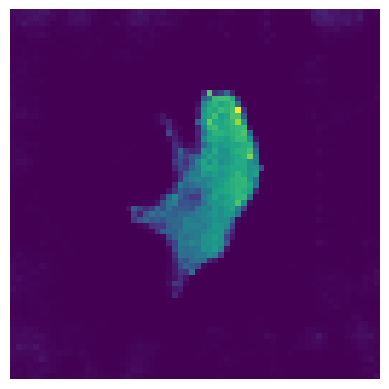

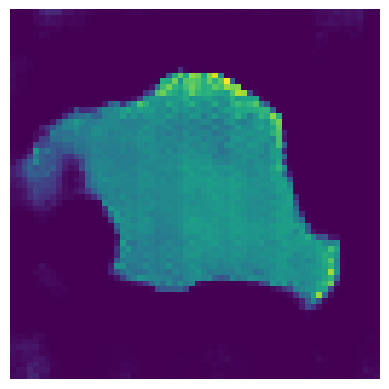

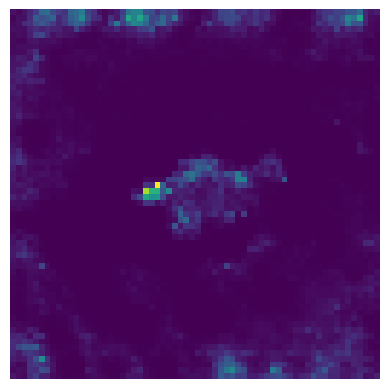

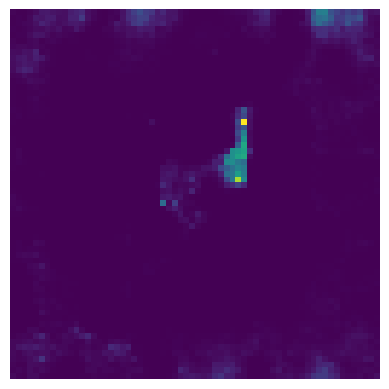

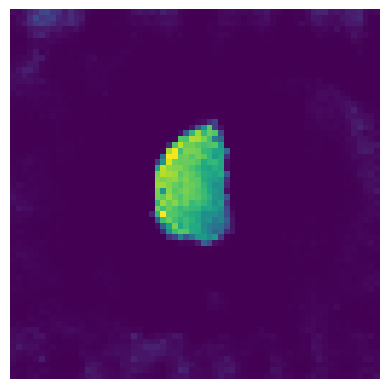

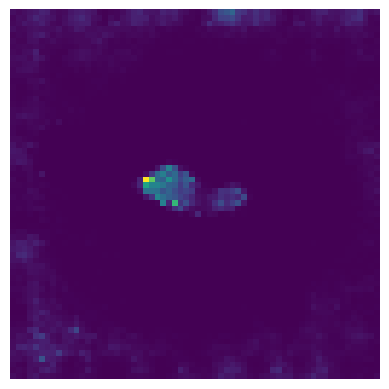

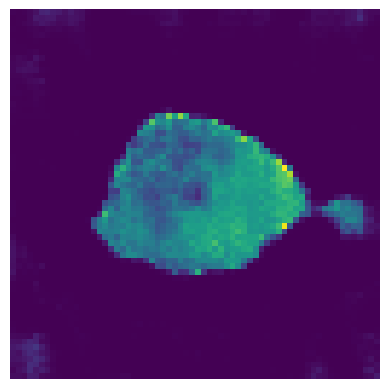

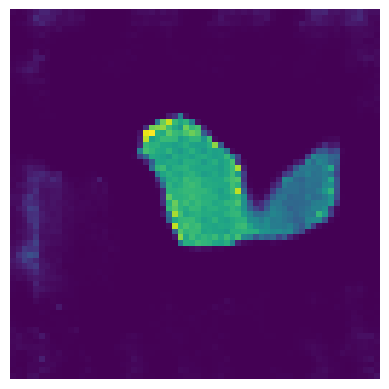

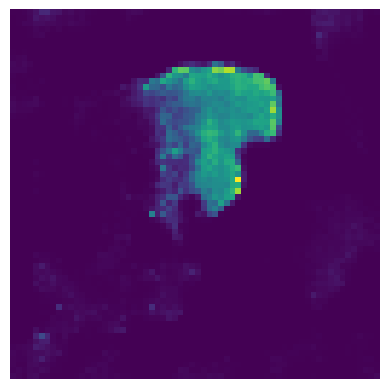

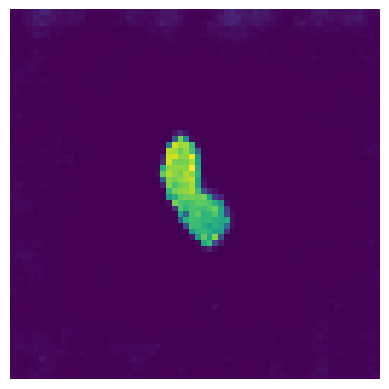

313/313 [==============================] - 75s 233ms/step - d_loss: 0.0646 - d_real_acc: 0.8992 - d_fake_acc: 0.8980 - d_acc: 0.8986 - g_loss: 4.8538 - g_acc: 0.1020
Epoch 10/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0647 - d_real_acc: 0.8981 - d_fake_acc: 0.8993 - d_acc: 0.8987 - g_loss: 4.7785 - g_acc: 0.1006

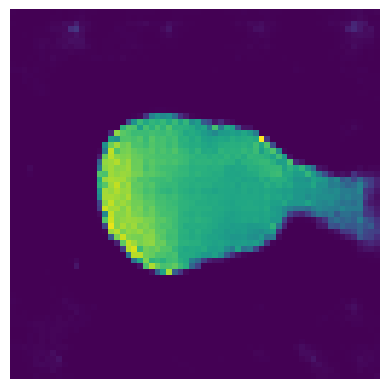

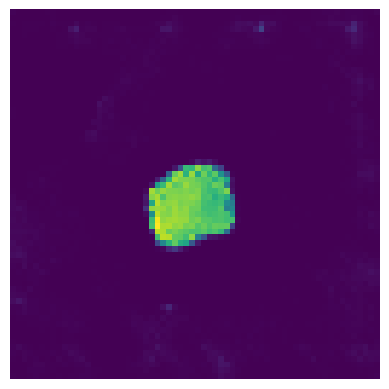

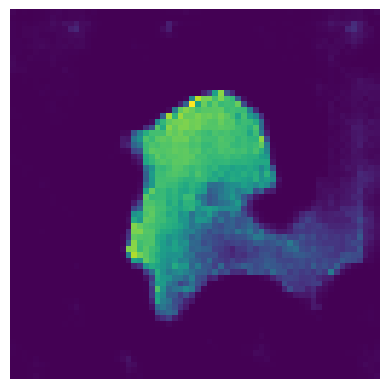

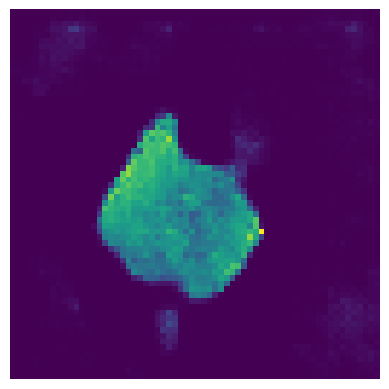

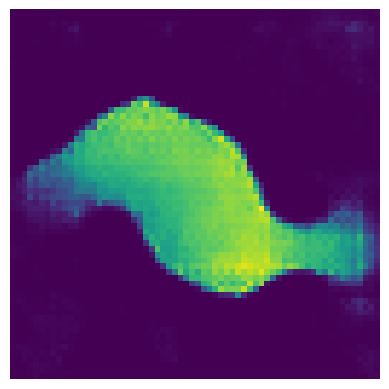

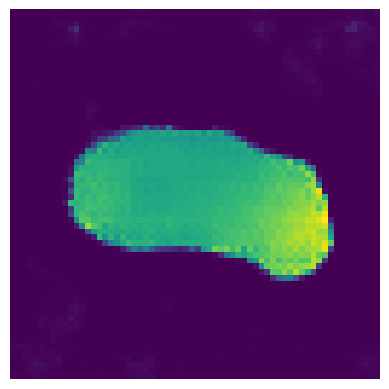

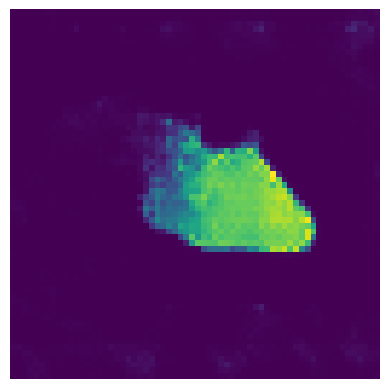

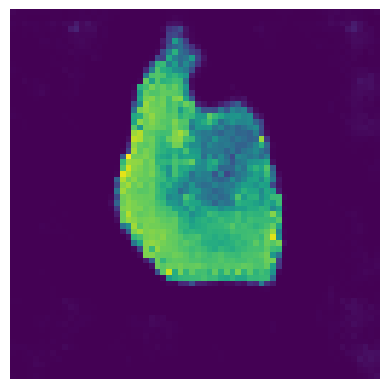

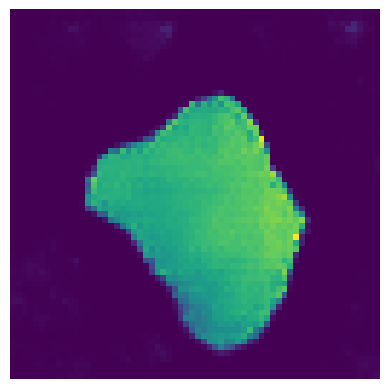

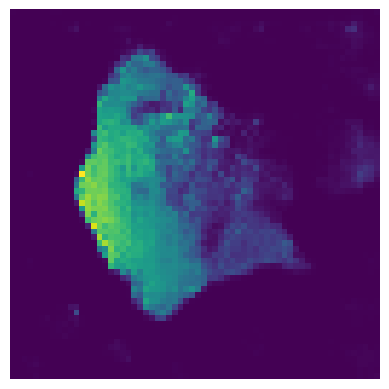

313/313 [==============================] - 75s 235ms/step - d_loss: 0.0647 - d_real_acc: 0.8981 - d_fake_acc: 0.8993 - d_acc: 0.8987 - g_loss: 4.7785 - g_acc: 0.1006
Epoch 11/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0077 - d_real_acc: 0.9179 - d_fake_acc: 0.9180 - d_acc: 0.9179 - g_loss: 5.1741 - g_acc: 0.0820

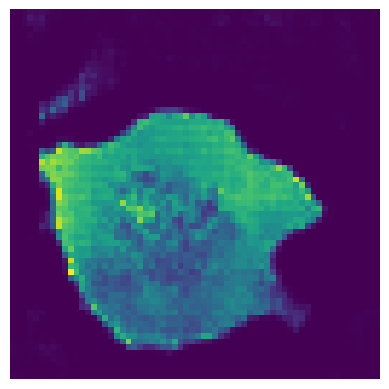

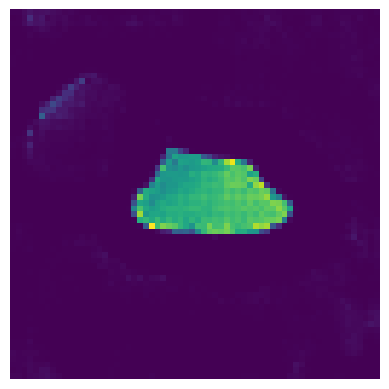

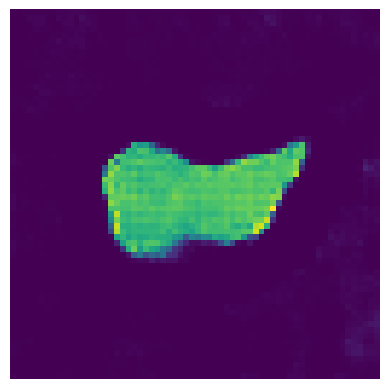

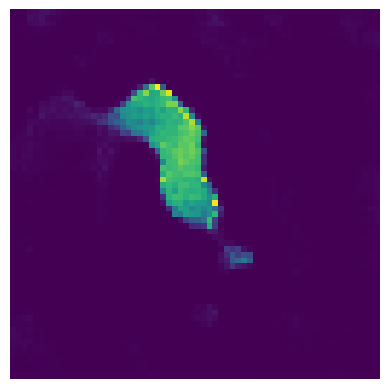

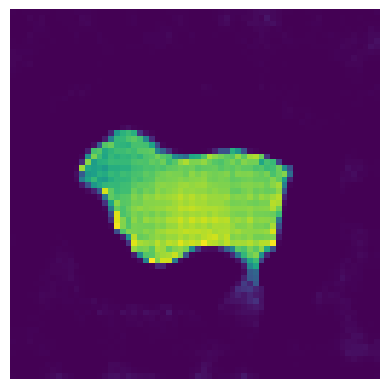

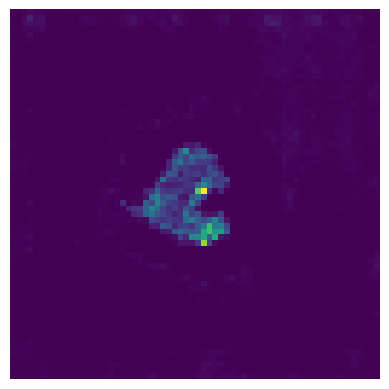

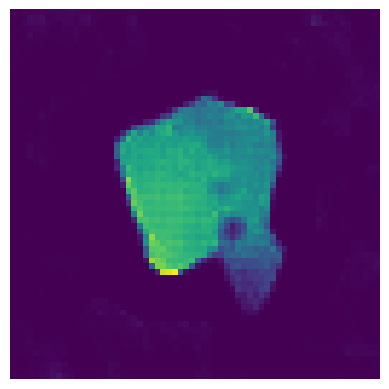

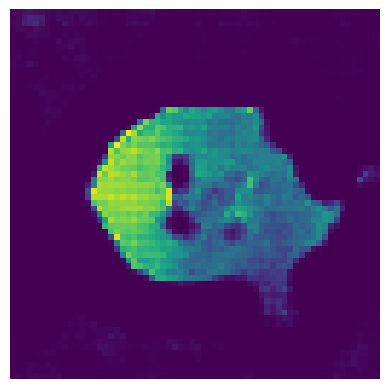

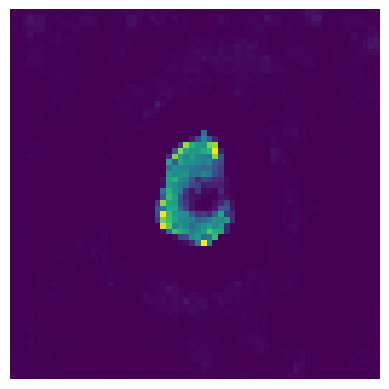

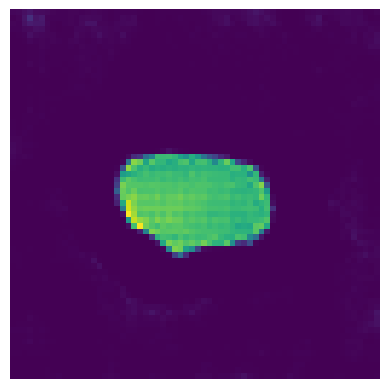

313/313 [==============================] - 75s 237ms/step - d_loss: 0.0077 - d_real_acc: 0.9179 - d_fake_acc: 0.9180 - d_acc: 0.9179 - g_loss: 5.1741 - g_acc: 0.0820
Epoch 12/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0175 - d_real_acc: 0.9102 - d_fake_acc: 0.9129 - d_acc: 0.9115 - g_loss: 5.3475 - g_acc: 0.0872

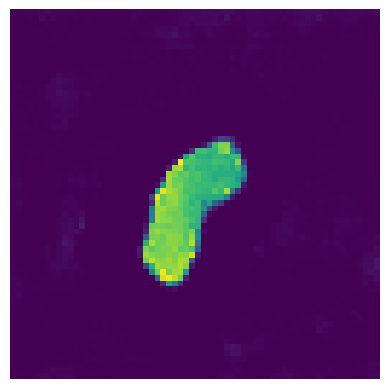

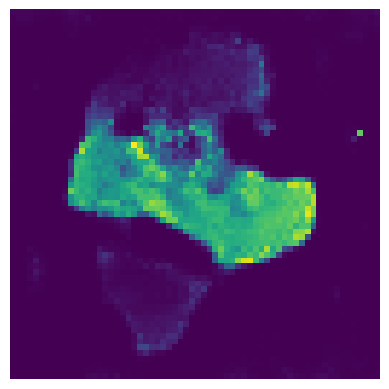

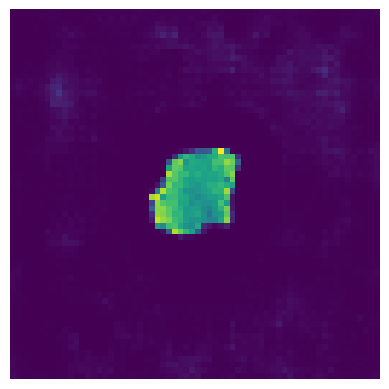

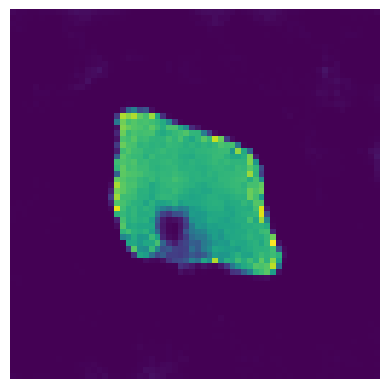

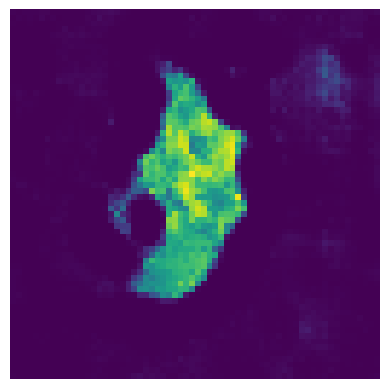

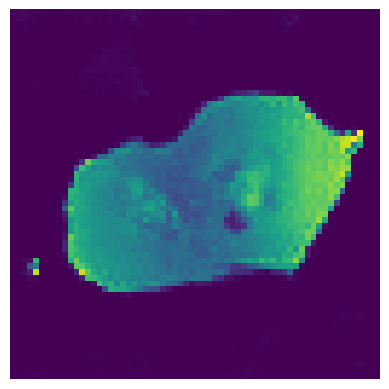

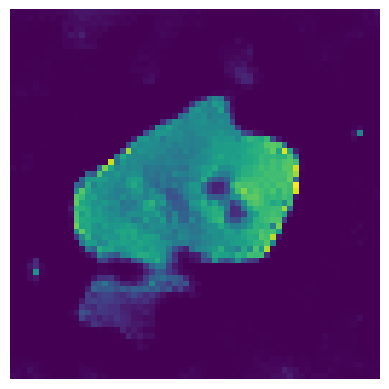

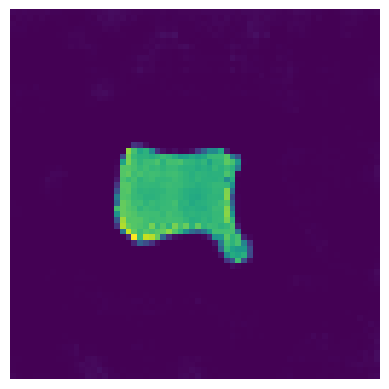

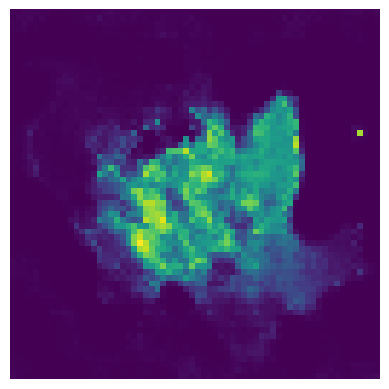

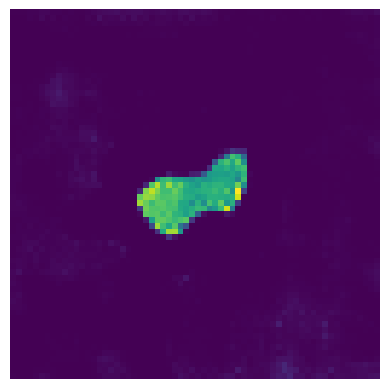

313/313 [==============================] - 77s 240ms/step - d_loss: 0.0175 - d_real_acc: 0.9102 - d_fake_acc: 0.9129 - d_acc: 0.9115 - g_loss: 5.3475 - g_acc: 0.0872
Epoch 13/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0604 - d_real_acc: 0.9270 - d_fake_acc: 0.9301 - d_acc: 0.9286 - g_loss: 5.7455 - g_acc: 0.0698

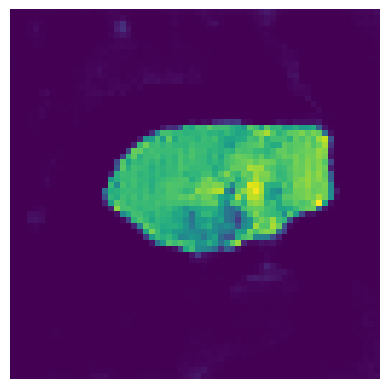

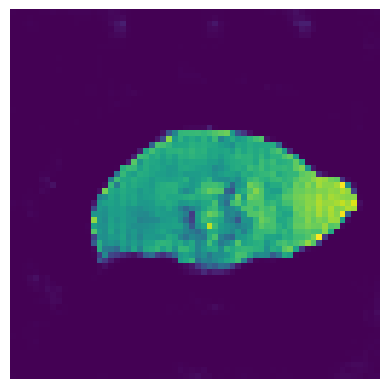

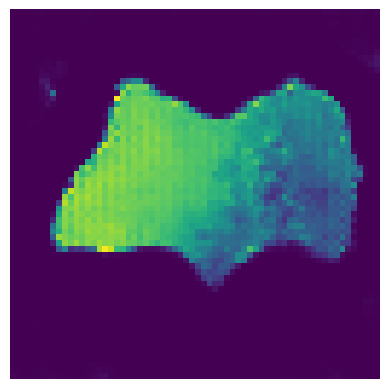

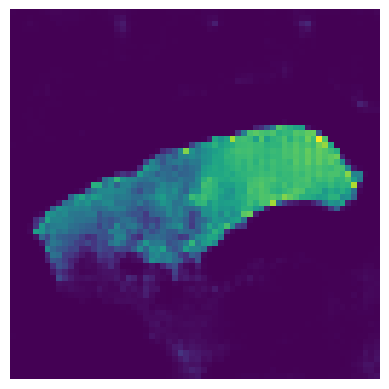

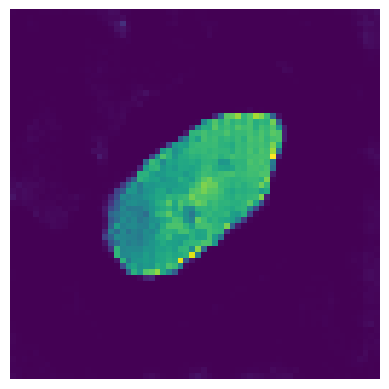

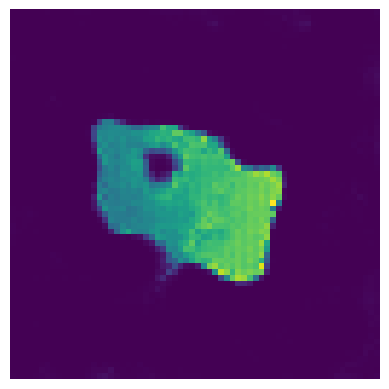

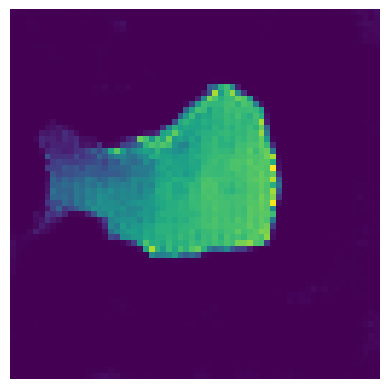

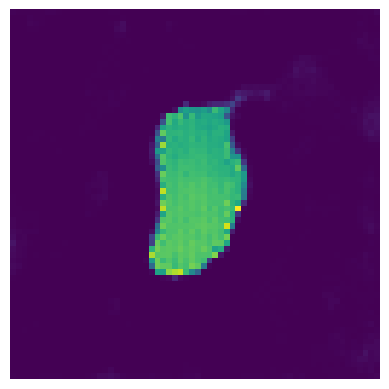

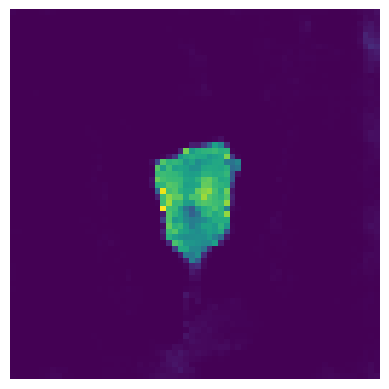

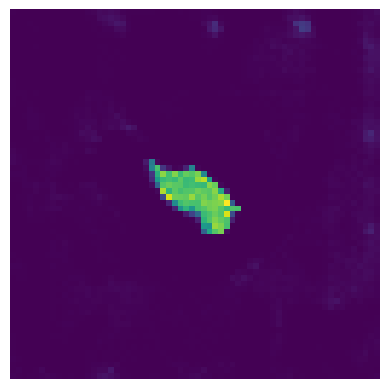

313/313 [==============================] - 76s 237ms/step - d_loss: -0.0604 - d_real_acc: 0.9270 - d_fake_acc: 0.9301 - d_acc: 0.9286 - g_loss: 5.7455 - g_acc: 0.0698
Epoch 14/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0072 - d_real_acc: 0.9184 - d_fake_acc: 0.9203 - d_acc: 0.9193 - g_loss: 5.7930 - g_acc: 0.0797

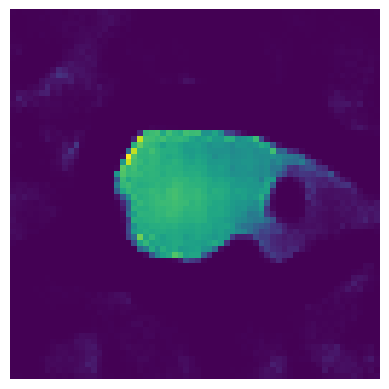

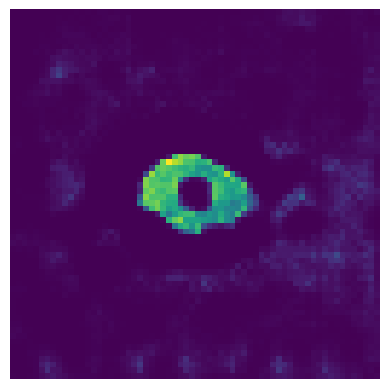

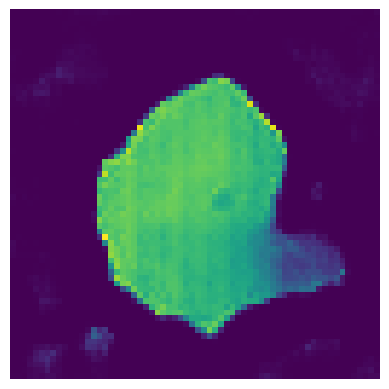

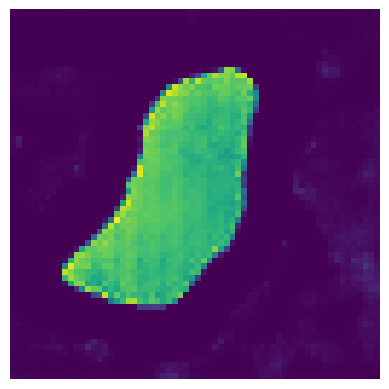

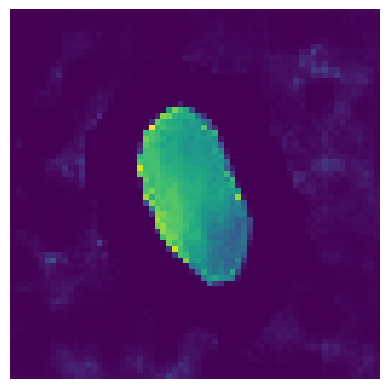

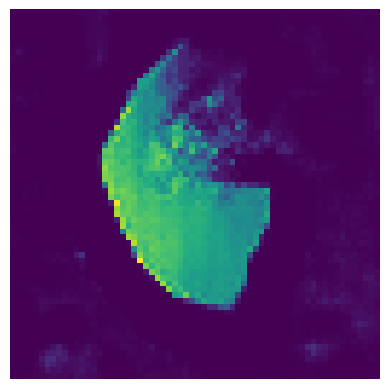

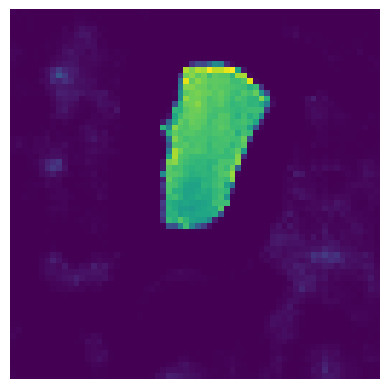

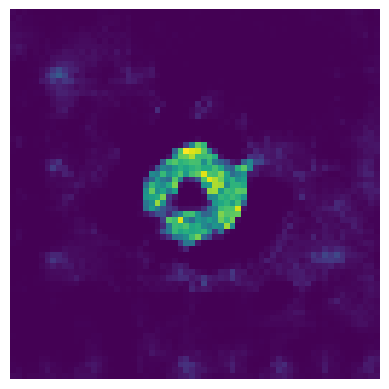

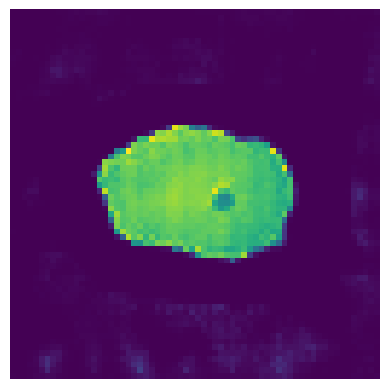

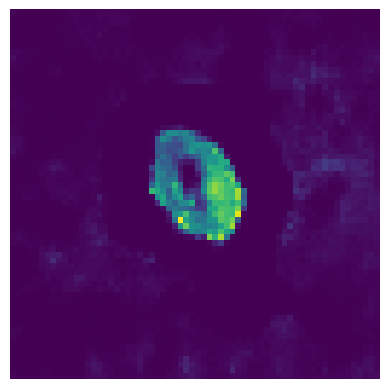

313/313 [==============================] - 77s 241ms/step - d_loss: 0.0072 - d_real_acc: 0.9184 - d_fake_acc: 0.9203 - d_acc: 0.9193 - g_loss: 5.7930 - g_acc: 0.0797
Epoch 15/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0049 - d_real_acc: 0.9094 - d_fake_acc: 0.9098 - d_acc: 0.9096 - g_loss: 5.7420 - g_acc: 0.0902

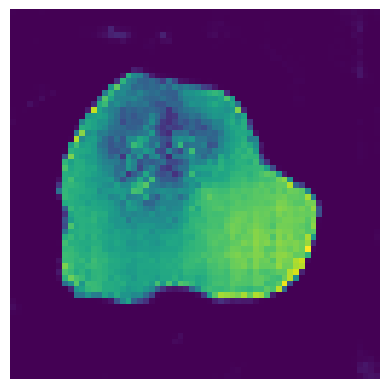

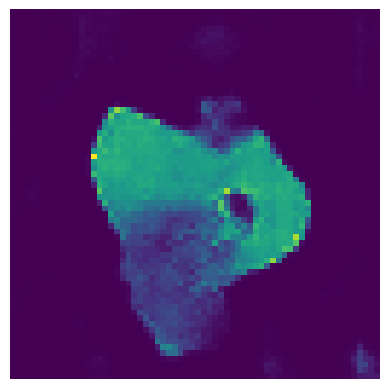

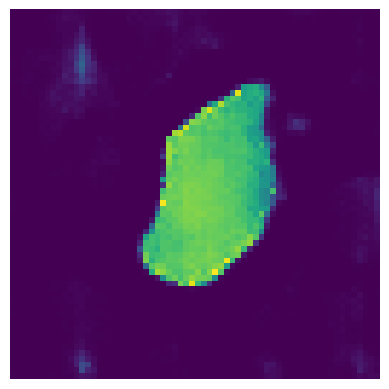

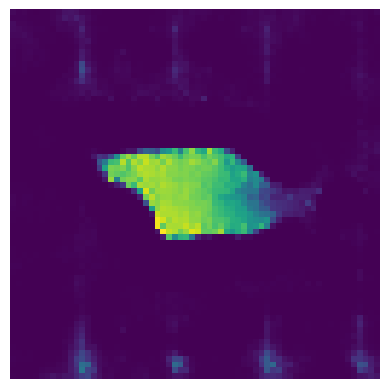

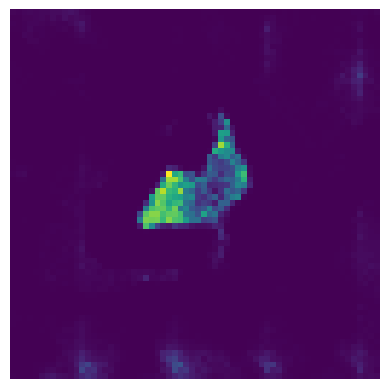

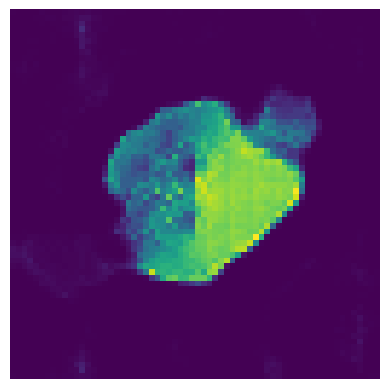

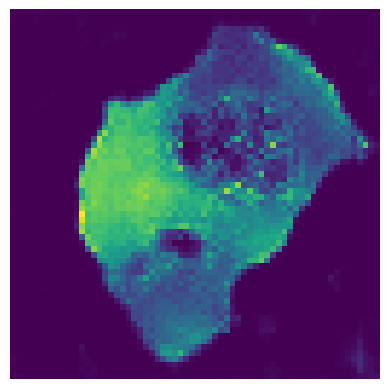

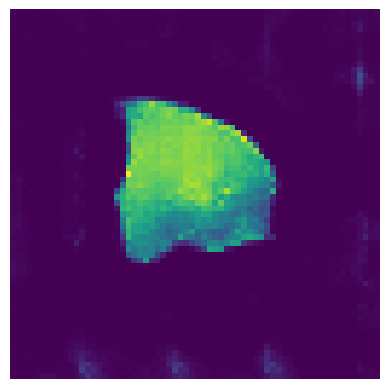

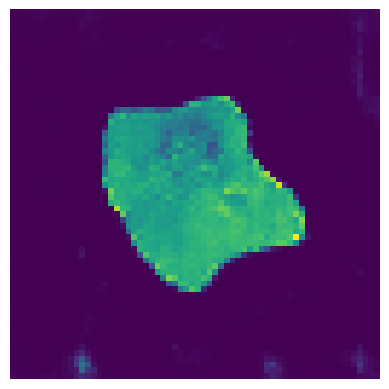

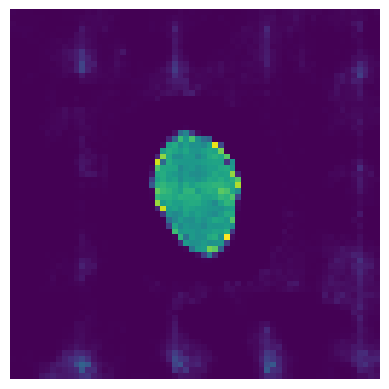

313/313 [==============================] - 77s 243ms/step - d_loss: 0.0049 - d_real_acc: 0.9094 - d_fake_acc: 0.9098 - d_acc: 0.9096 - g_loss: 5.7420 - g_acc: 0.0902
Epoch 16/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0078 - d_real_acc: 0.9258 - d_fake_acc: 0.9271 - d_acc: 0.9265 - g_loss: 5.6706 - g_acc: 0.0729

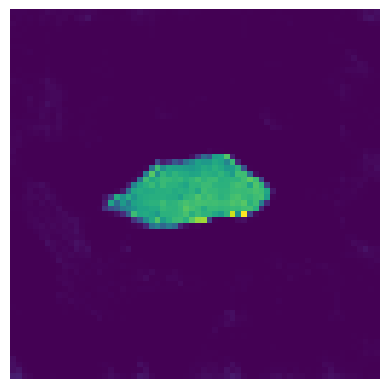

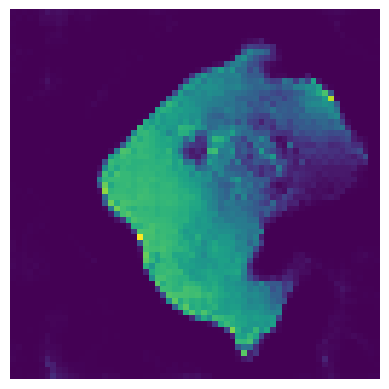

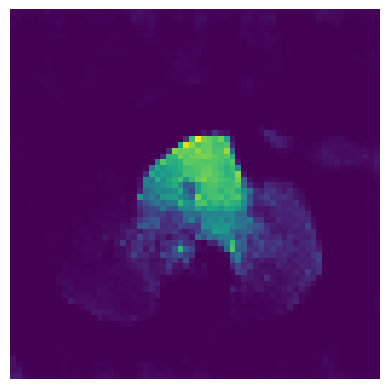

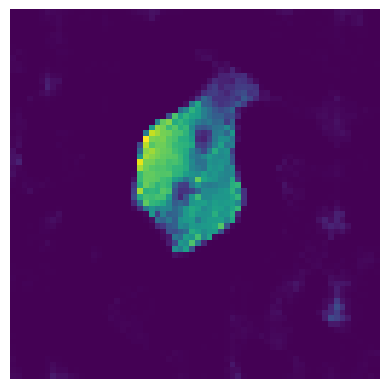

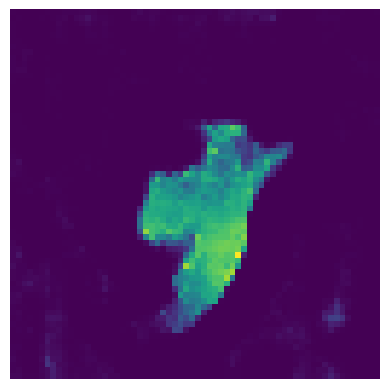

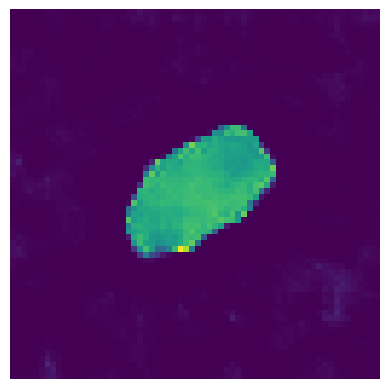

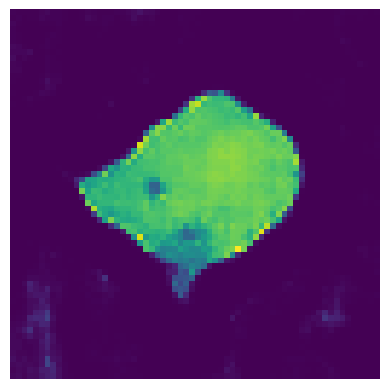

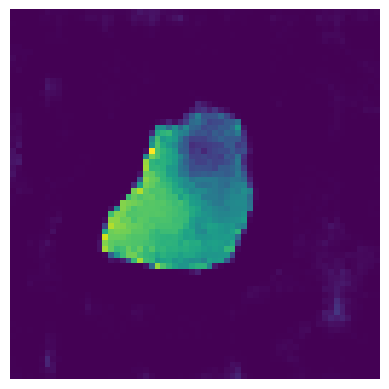

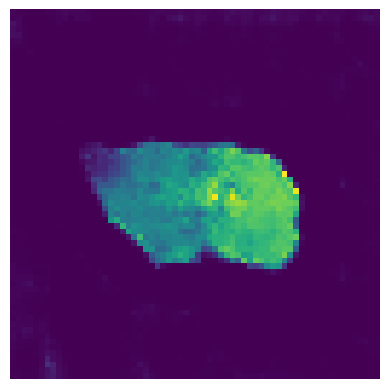

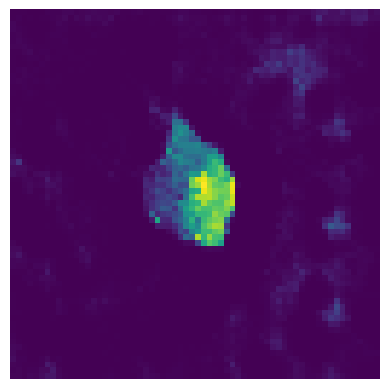

313/313 [==============================] - 77s 241ms/step - d_loss: -0.0078 - d_real_acc: 0.9258 - d_fake_acc: 0.9271 - d_acc: 0.9265 - g_loss: 5.6706 - g_acc: 0.0729
Epoch 17/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0376 - d_real_acc: 0.9290 - d_fake_acc: 0.9308 - d_acc: 0.9299 - g_loss: 5.8511 - g_acc: 0.0692

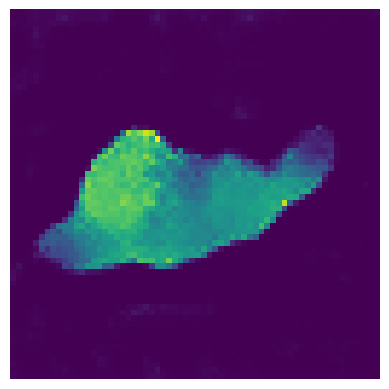

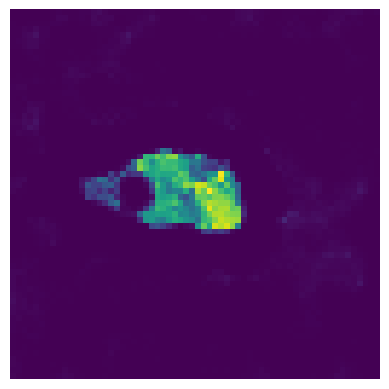

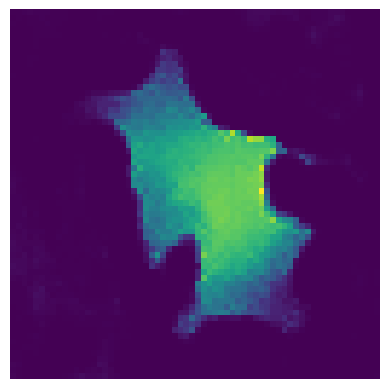

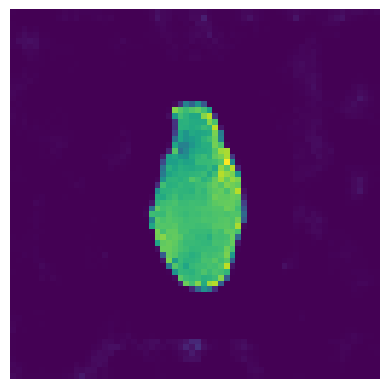

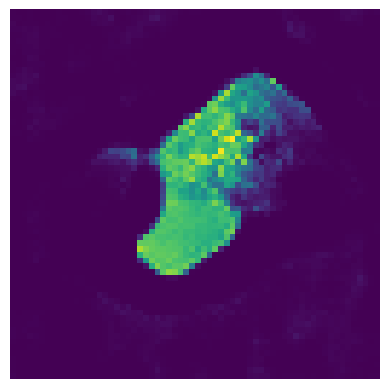

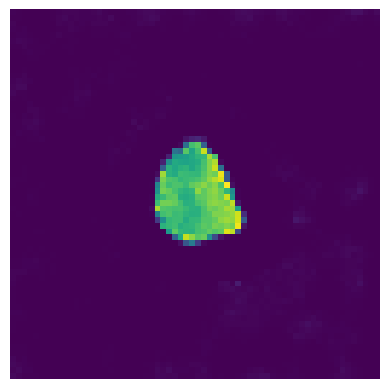

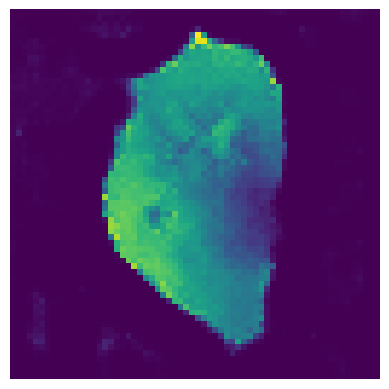

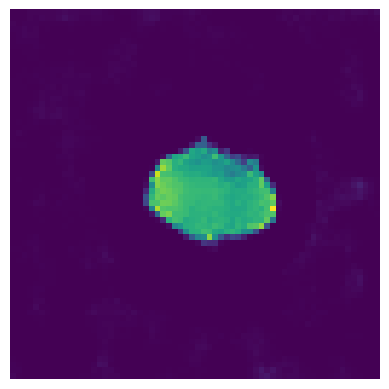

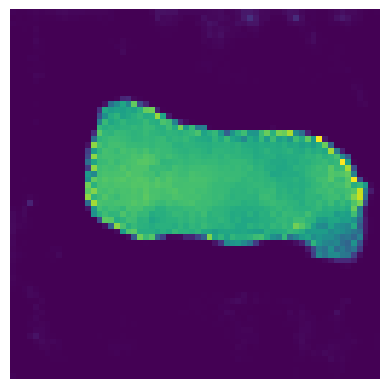

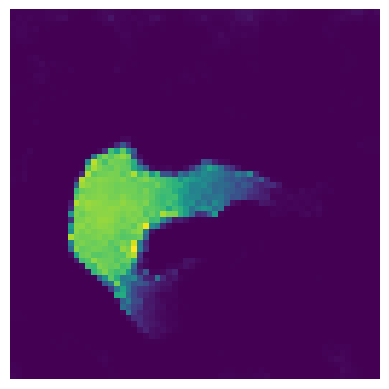

313/313 [==============================] - 78s 244ms/step - d_loss: -0.0376 - d_real_acc: 0.9290 - d_fake_acc: 0.9308 - d_acc: 0.9299 - g_loss: 5.8511 - g_acc: 0.0692
Epoch 18/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0572 - d_real_acc: 0.9349 - d_fake_acc: 0.9344 - d_acc: 0.9347 - g_loss: 6.1951 - g_acc: 0.0655

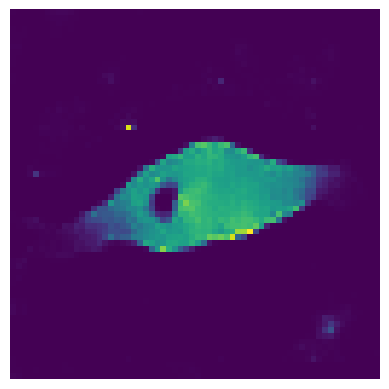

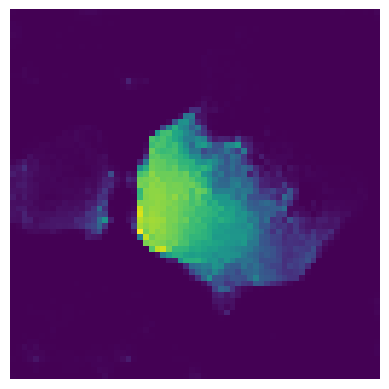

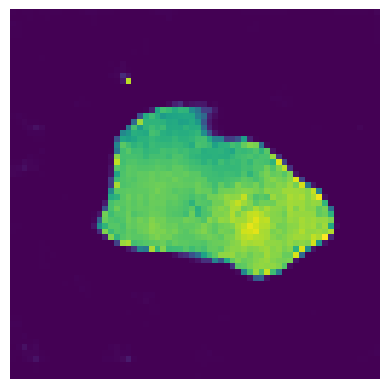

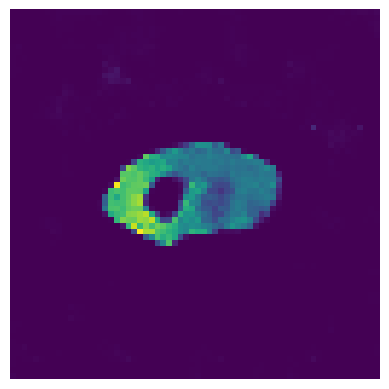

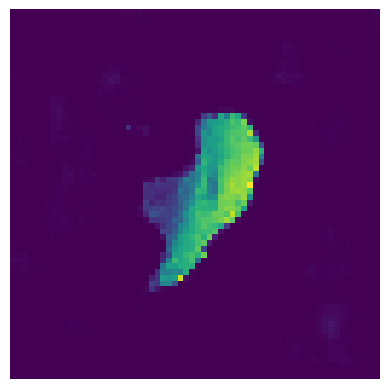

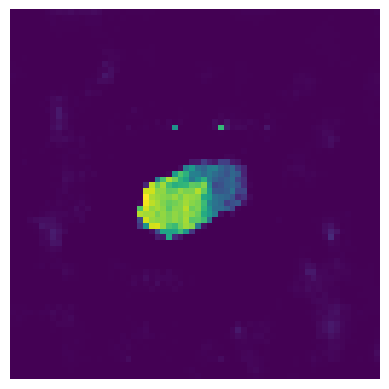

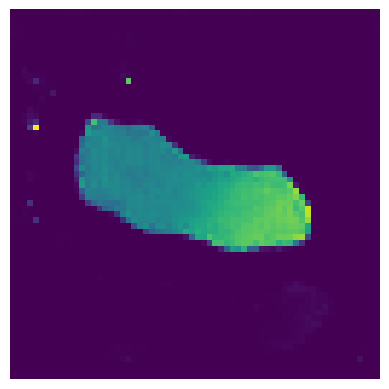

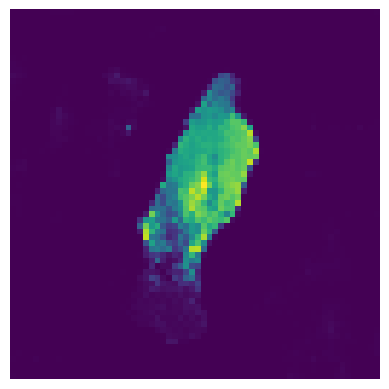

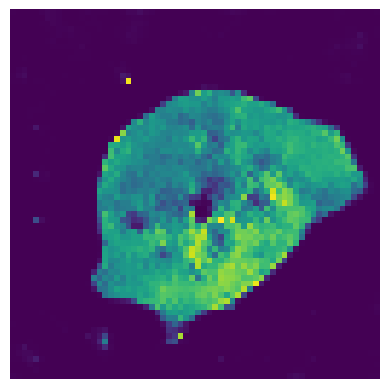

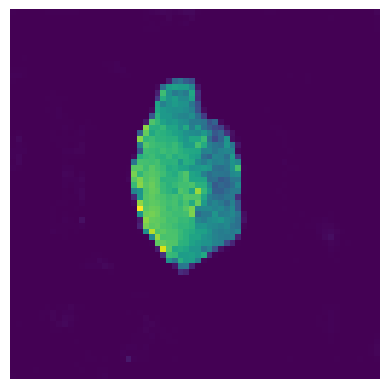

313/313 [==============================] - 78s 244ms/step - d_loss: -0.0572 - d_real_acc: 0.9349 - d_fake_acc: 0.9344 - d_acc: 0.9347 - g_loss: 6.1951 - g_acc: 0.0655
Epoch 19/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0442 - d_real_acc: 0.9354 - d_fake_acc: 0.9362 - d_acc: 0.9358 - g_loss: 6.2821 - g_acc: 0.0638

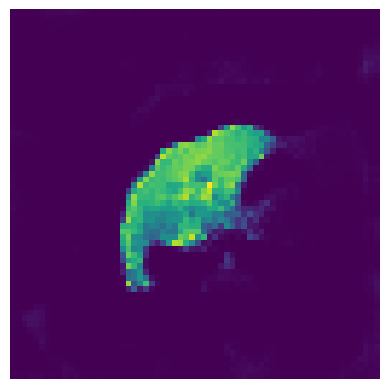

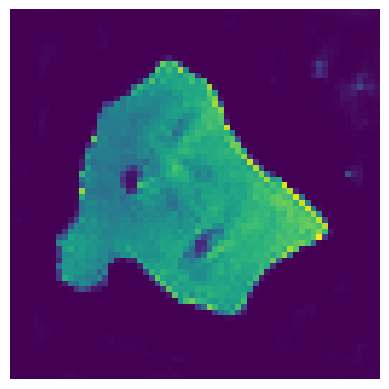

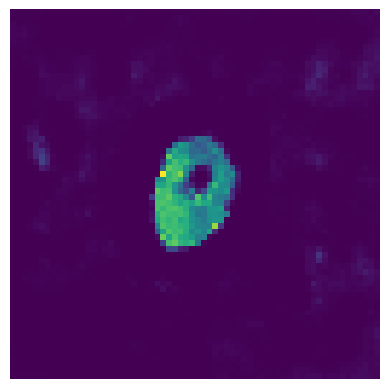

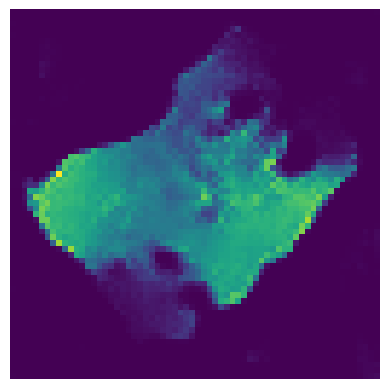

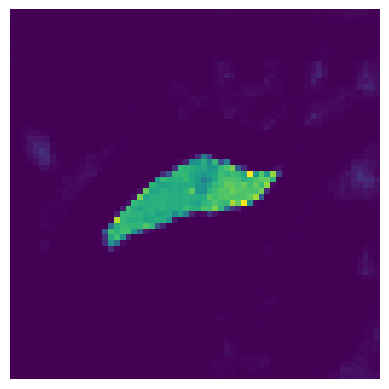

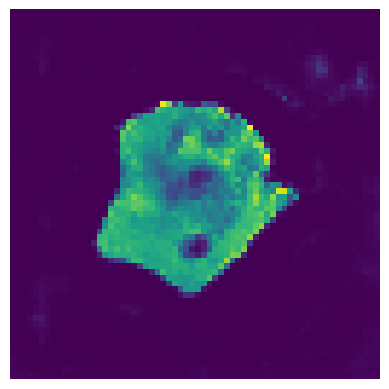

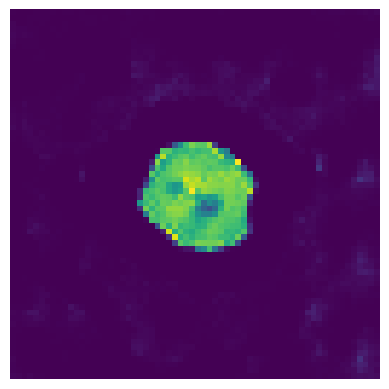

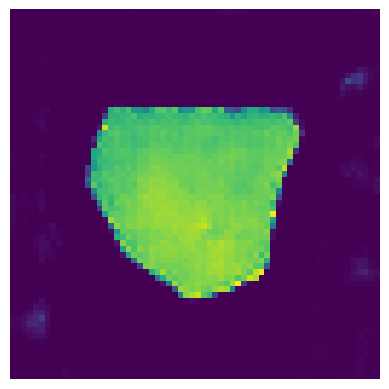

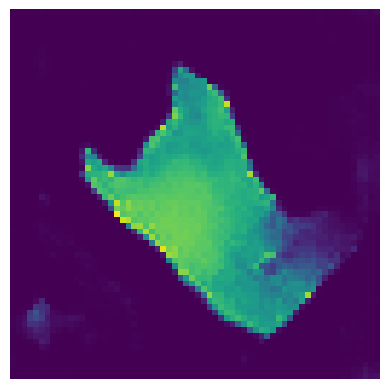

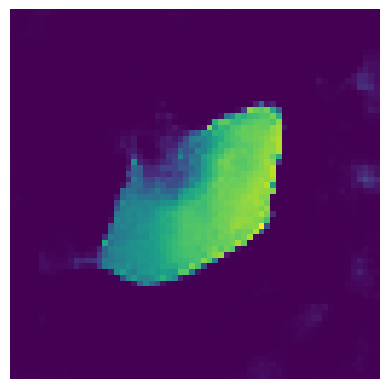

313/313 [==============================] - 78s 244ms/step - d_loss: -0.0442 - d_real_acc: 0.9354 - d_fake_acc: 0.9362 - d_acc: 0.9358 - g_loss: 6.2821 - g_acc: 0.0638
Epoch 20/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0018 - d_real_acc: 0.9316 - d_fake_acc: 0.9392 - d_acc: 0.9354 - g_loss: 6.7463 - g_acc: 0.0608    

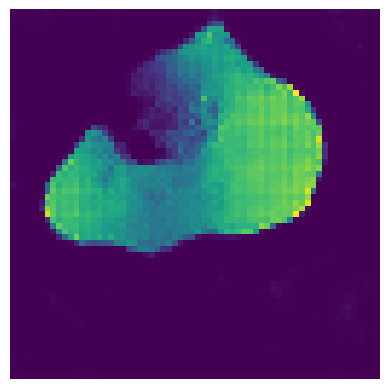

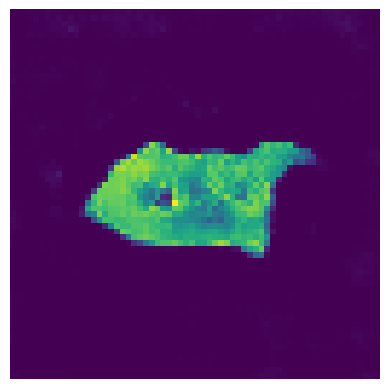

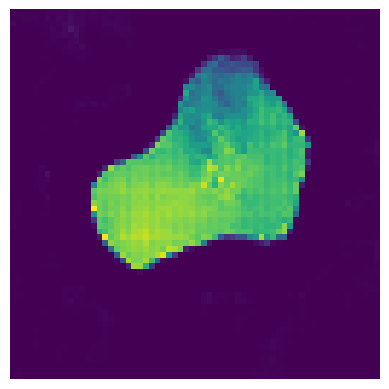

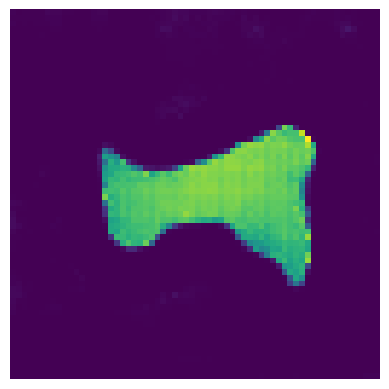

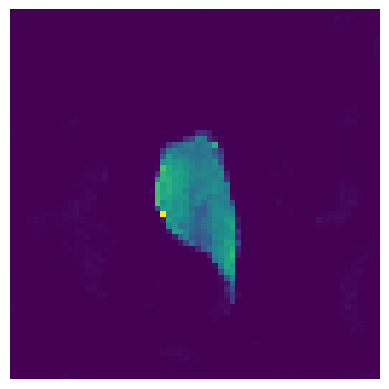

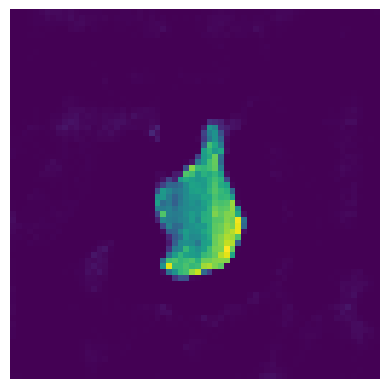

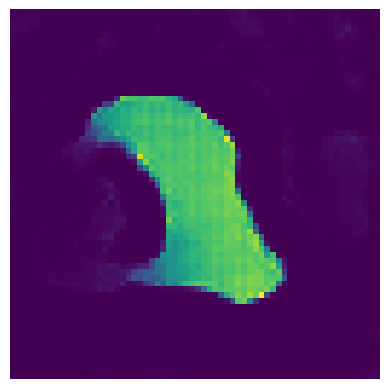

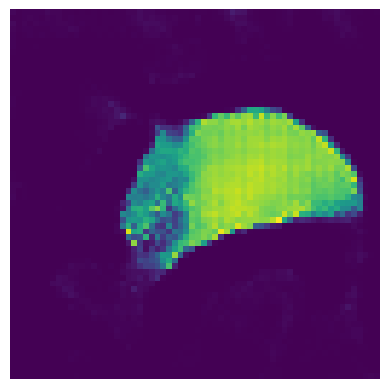

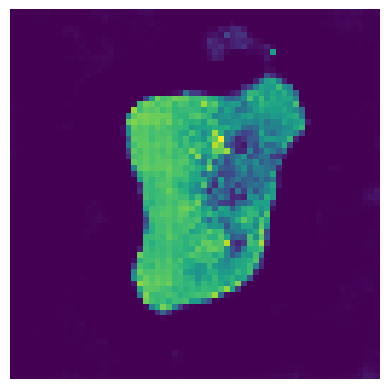

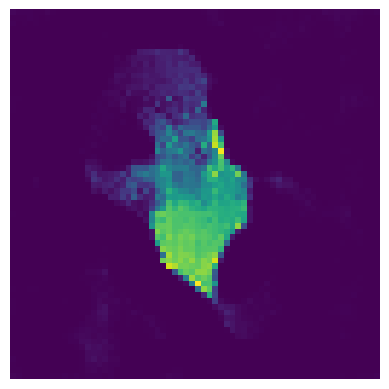

313/313 [==============================] - 78s 246ms/step - d_loss: -0.0018 - d_real_acc: 0.9316 - d_fake_acc: 0.9392 - d_acc: 0.9354 - g_loss: 6.7463 - g_acc: 0.0608
Epoch 21/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0901 - d_real_acc: 0.9417 - d_fake_acc: 0.9426 - d_acc: 0.9421 - g_loss: 6.7678 - g_acc: 0.0574

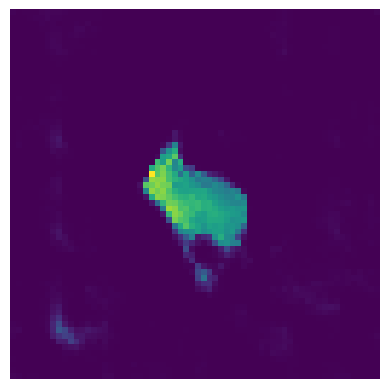

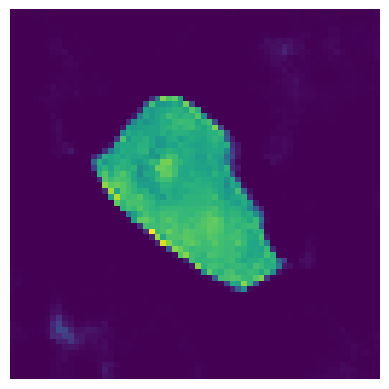

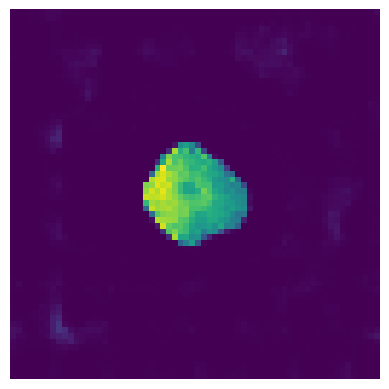

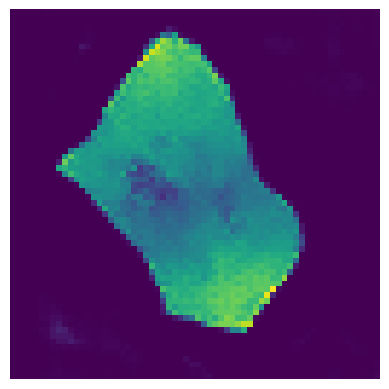

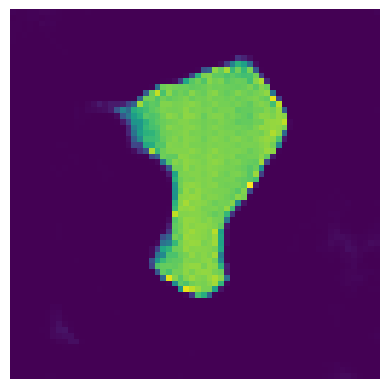

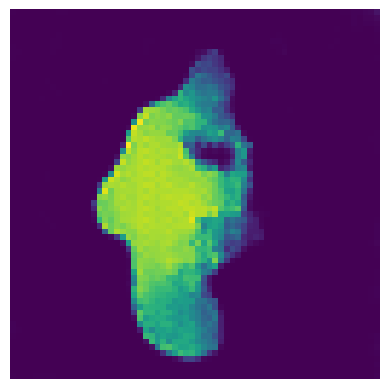

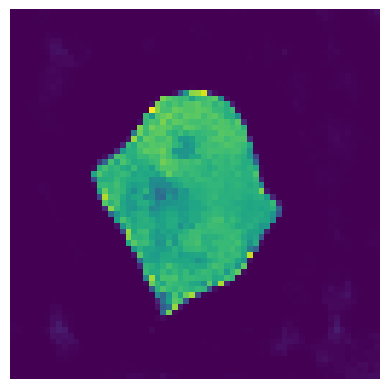

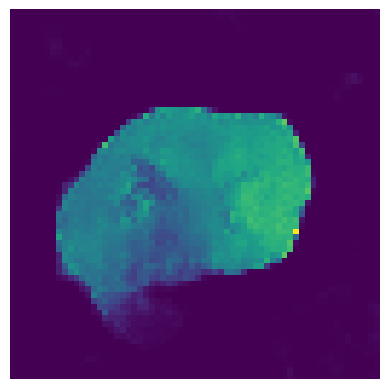

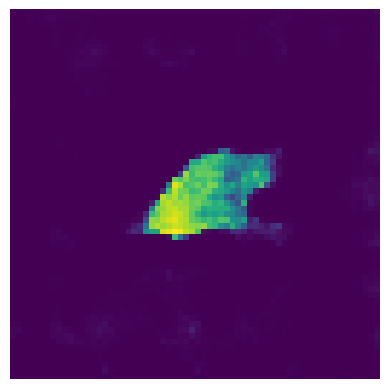

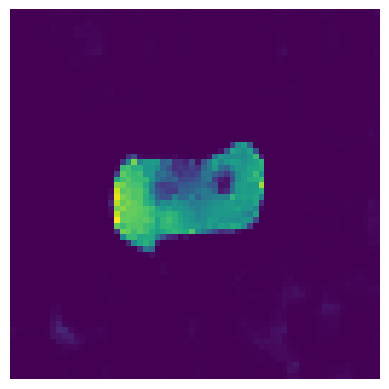

313/313 [==============================] - 78s 246ms/step - d_loss: -0.0901 - d_real_acc: 0.9417 - d_fake_acc: 0.9426 - d_acc: 0.9421 - g_loss: 6.7678 - g_acc: 0.0574
Epoch 22/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1424 - d_real_acc: 0.9420 - d_fake_acc: 0.9430 - d_acc: 0.9425 - g_loss: 6.8936 - g_acc: 0.0570

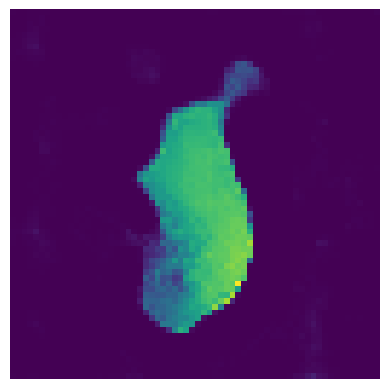

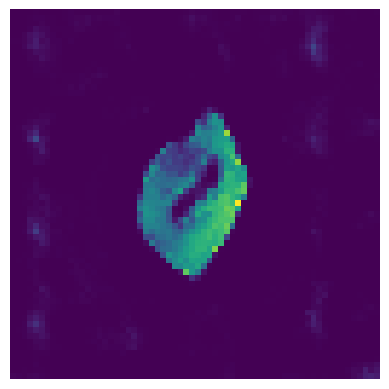

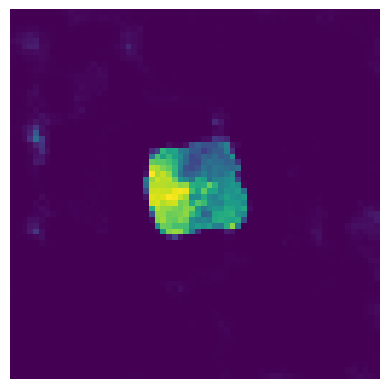

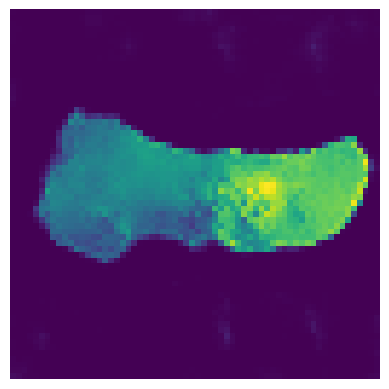

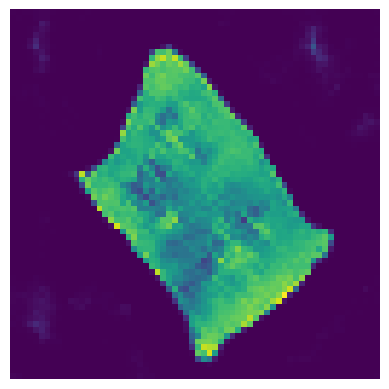

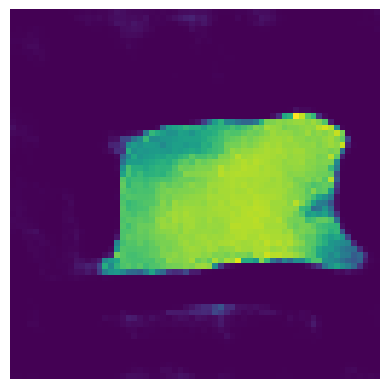

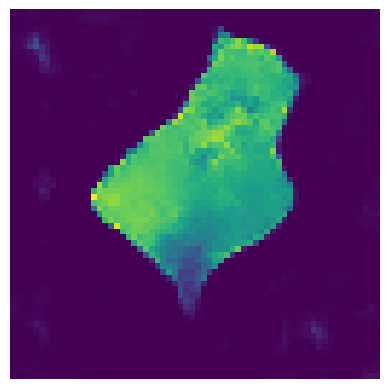

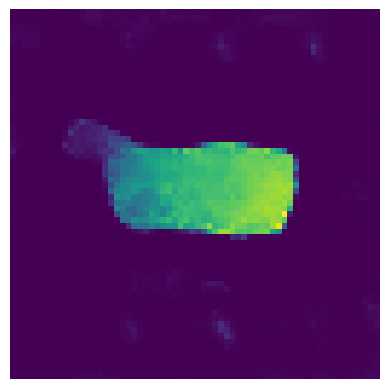

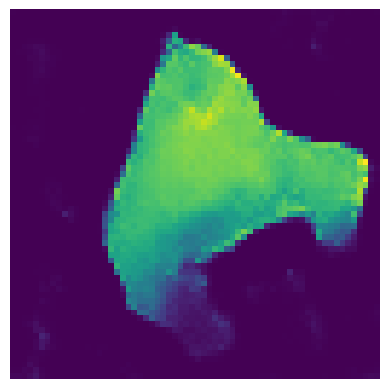

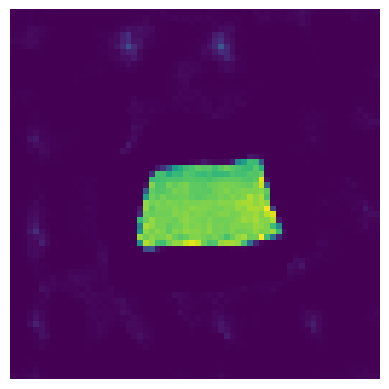

313/313 [==============================] - 79s 248ms/step - d_loss: -0.1424 - d_real_acc: 0.9420 - d_fake_acc: 0.9430 - d_acc: 0.9425 - g_loss: 6.8936 - g_acc: 0.0570
Epoch 23/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0971 - d_real_acc: 0.9337 - d_fake_acc: 0.9342 - d_acc: 0.9339 - g_loss: 6.7714 - g_acc: 0.0658

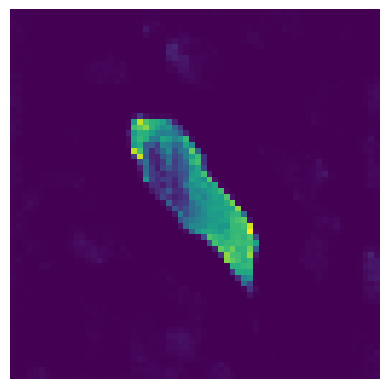

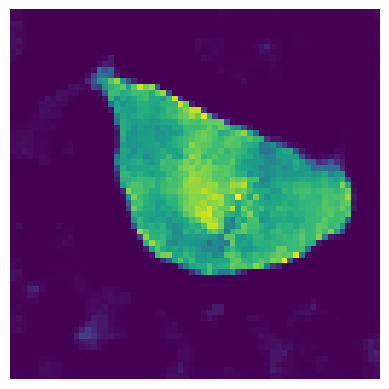

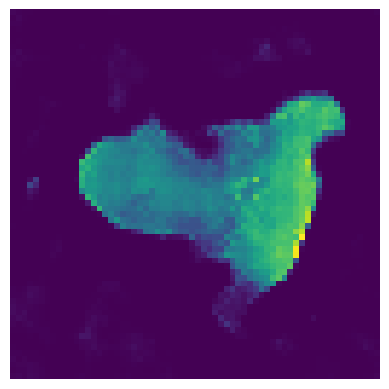

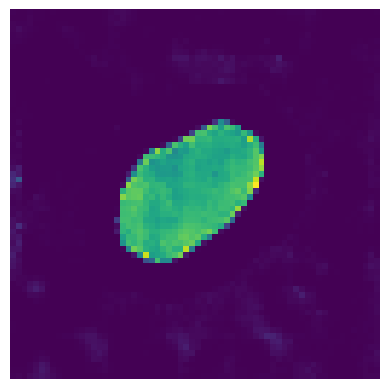

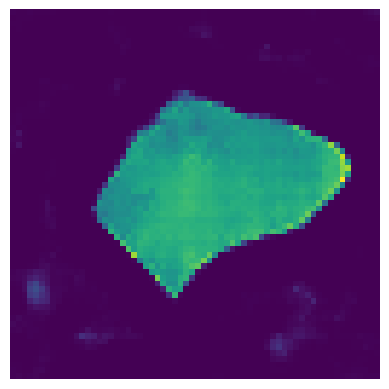

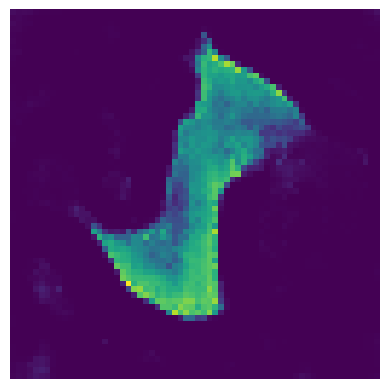

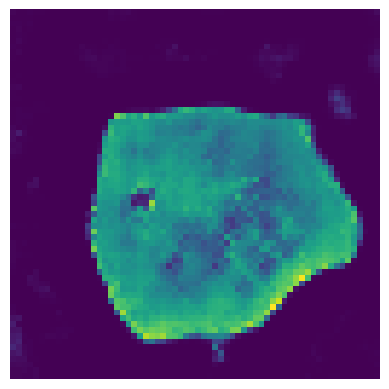

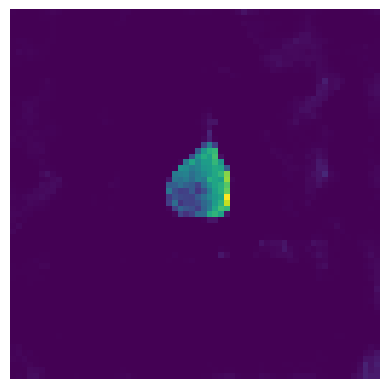

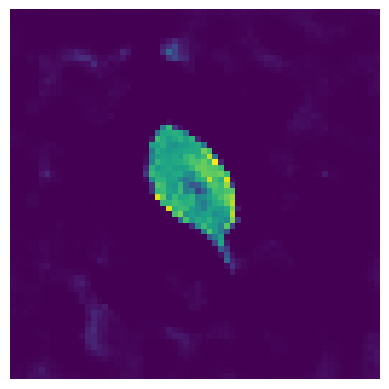

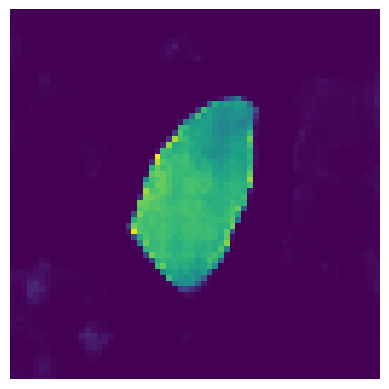

313/313 [==============================] - 79s 249ms/step - d_loss: -0.0971 - d_real_acc: 0.9337 - d_fake_acc: 0.9342 - d_acc: 0.9339 - g_loss: 6.7714 - g_acc: 0.0658
Epoch 24/50
313/313 [==============================] - ETA: 0s - d_loss: 1.1908 - d_real_acc: 0.7879 - d_fake_acc: 0.9503 - d_acc: 0.8691 - g_loss: 8.4390 - g_acc: 0.0496

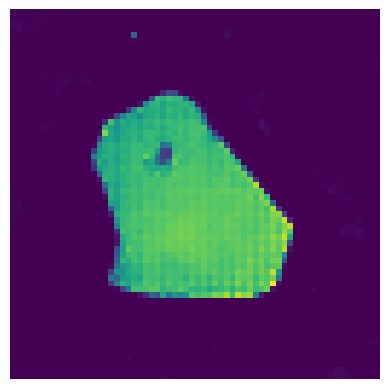

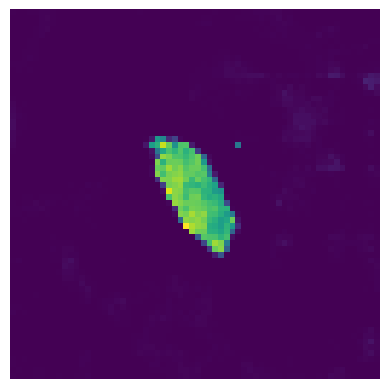

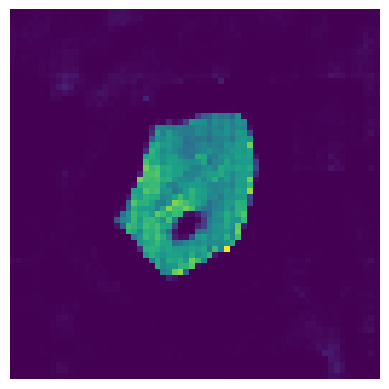

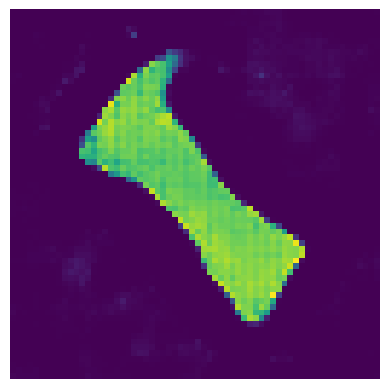

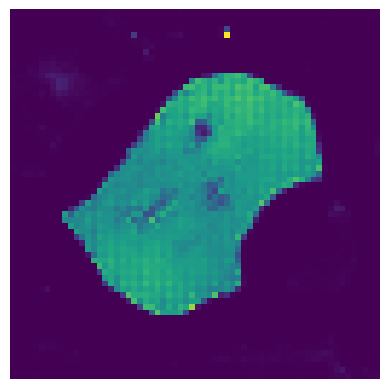

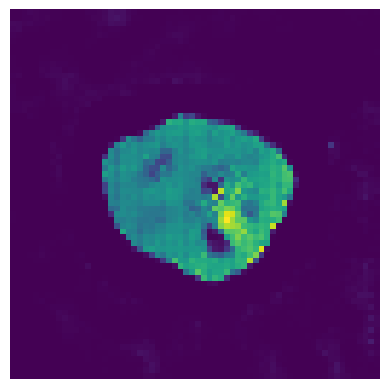

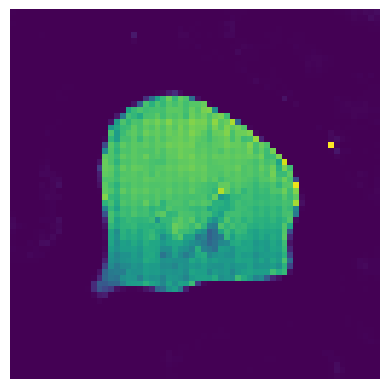

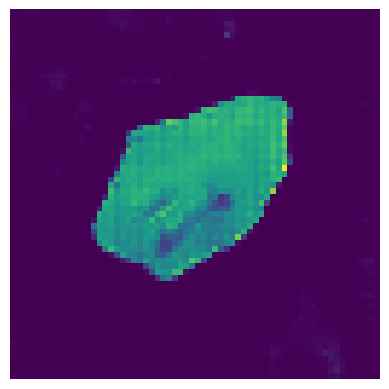

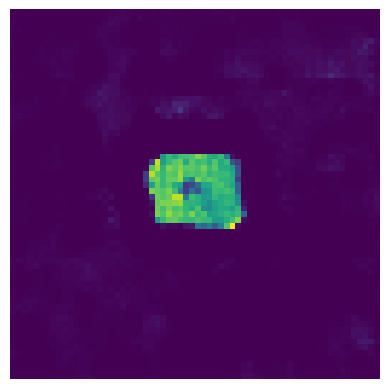

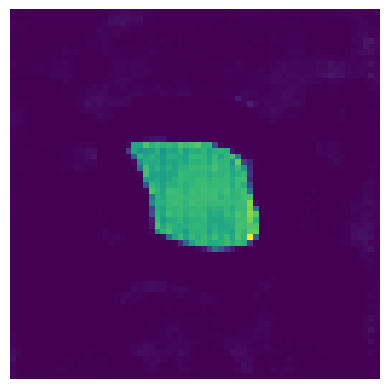

313/313 [==============================] - 78s 246ms/step - d_loss: 1.1908 - d_real_acc: 0.7879 - d_fake_acc: 0.9503 - d_acc: 0.8691 - g_loss: 8.4390 - g_acc: 0.0496
Epoch 25/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7106 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

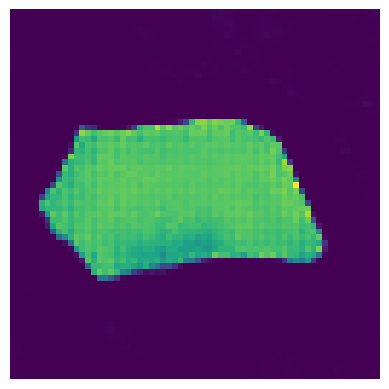

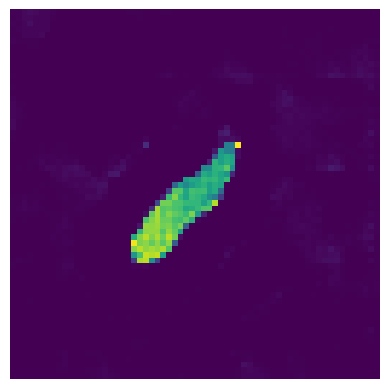

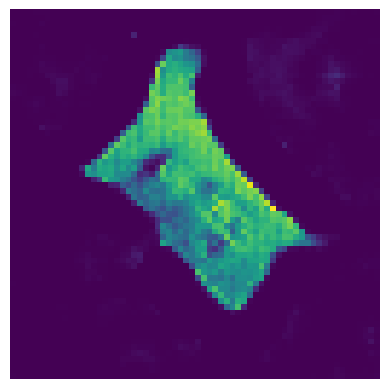

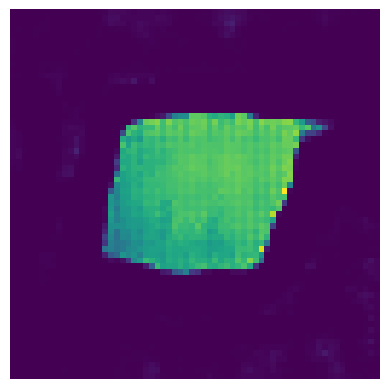

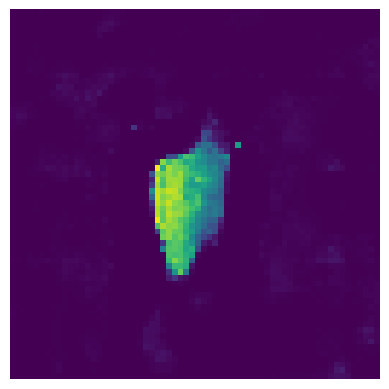

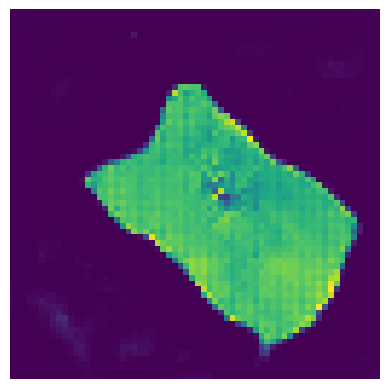

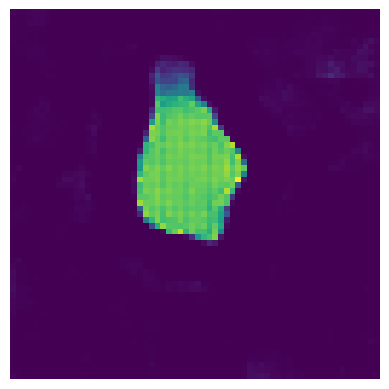

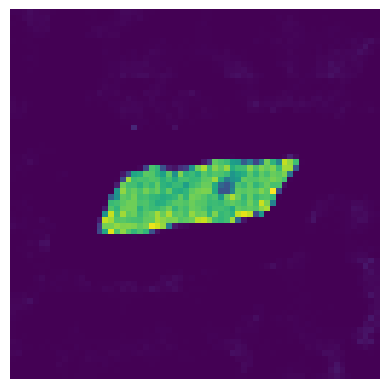

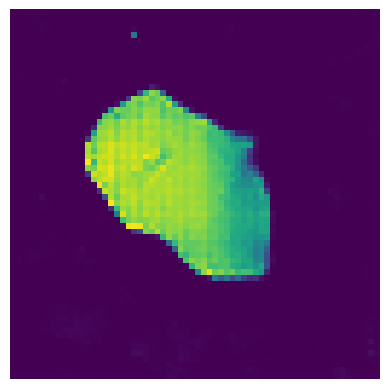

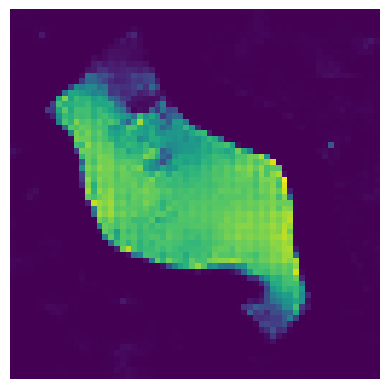

313/313 [==============================] - 78s 243ms/step - d_loss: 7.7106 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 26/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7137 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

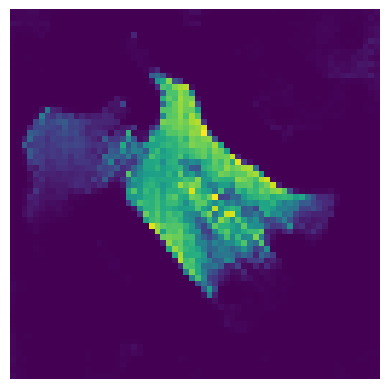

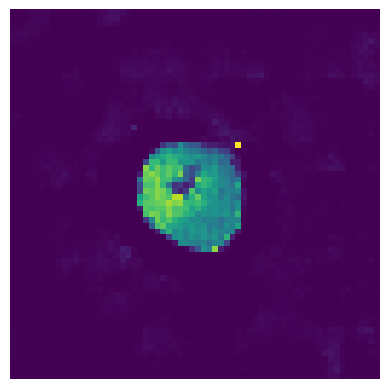

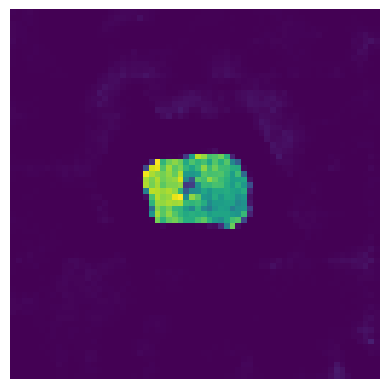

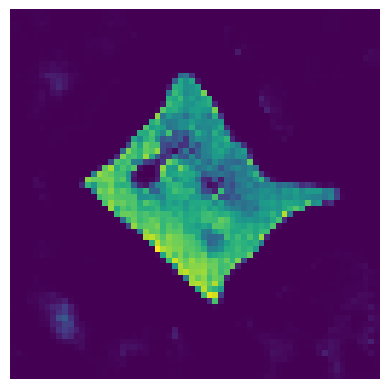

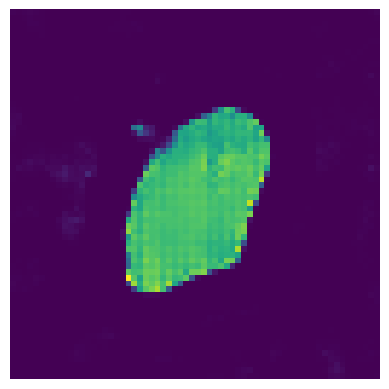

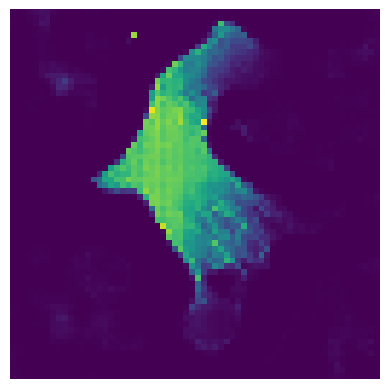

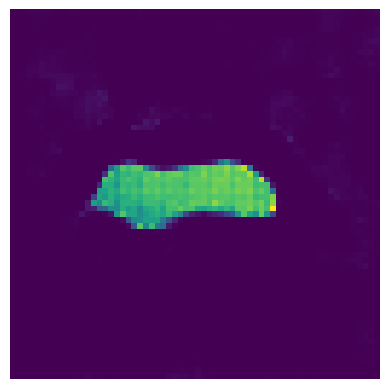

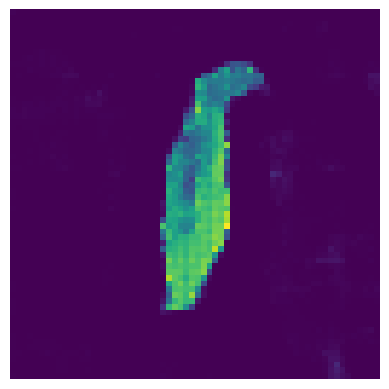

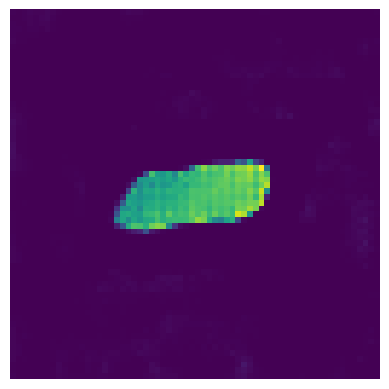

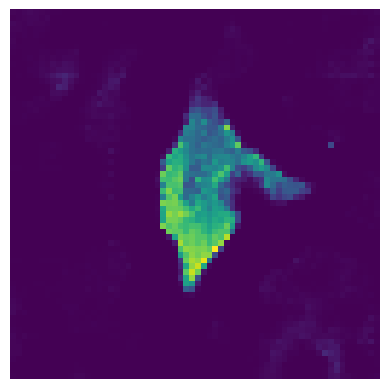

313/313 [==============================] - 78s 245ms/step - d_loss: 7.7137 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 27/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7108 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

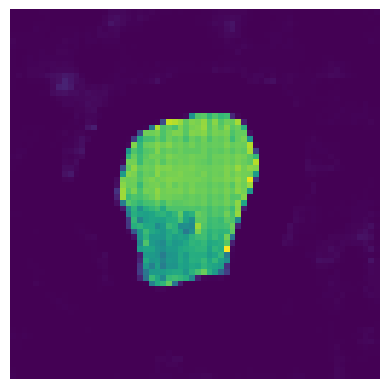

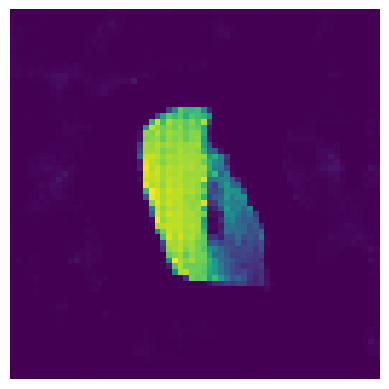

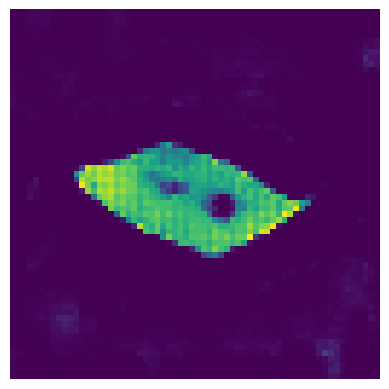

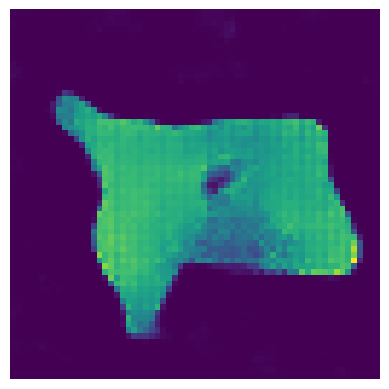

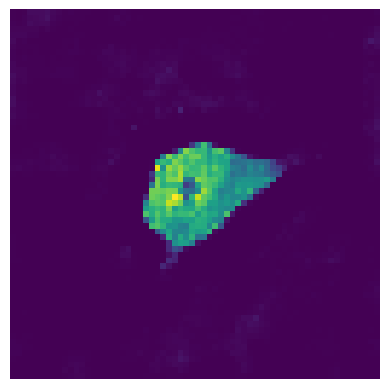

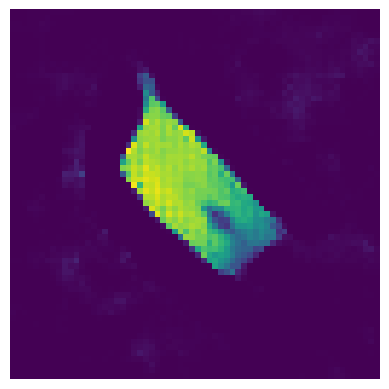

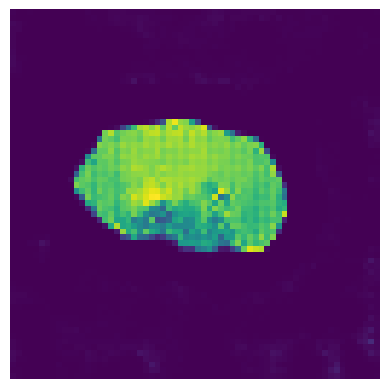

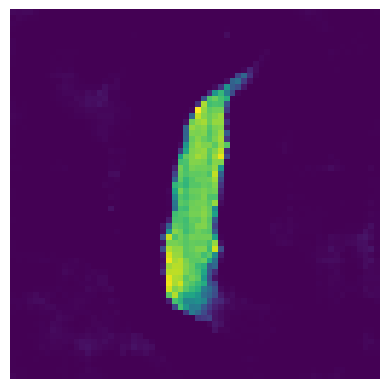

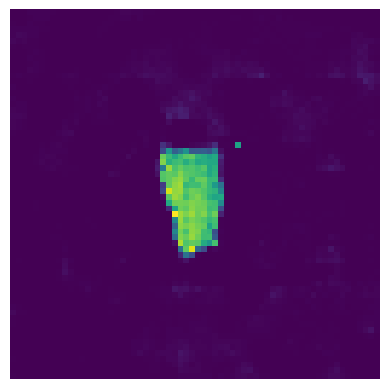

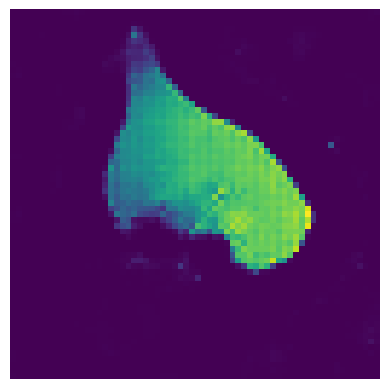

313/313 [==============================] - 79s 247ms/step - d_loss: 7.7108 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 28/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7131 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

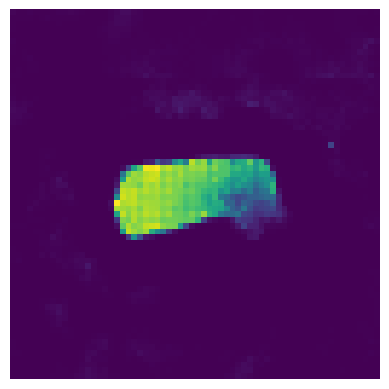

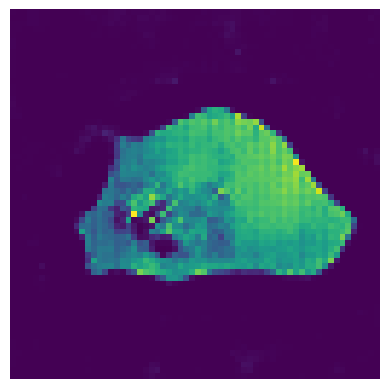

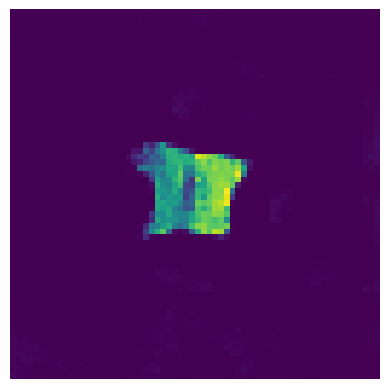

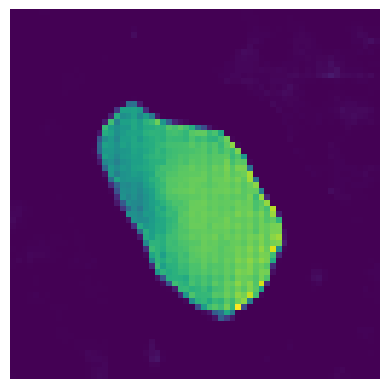

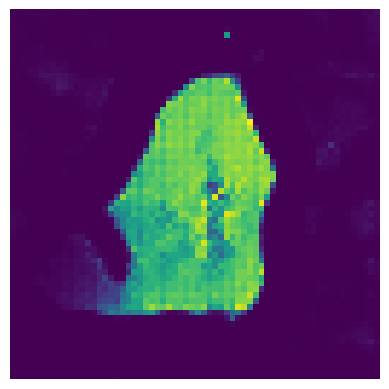

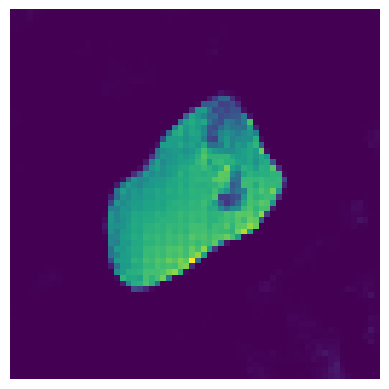

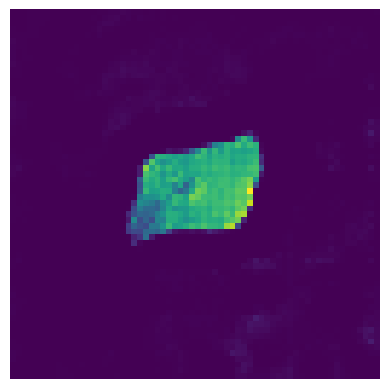

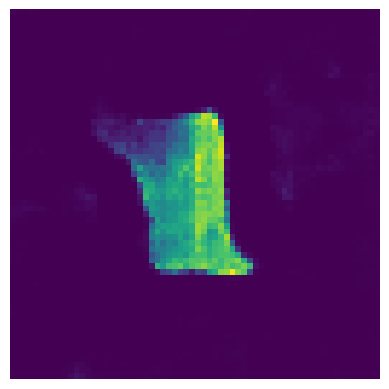

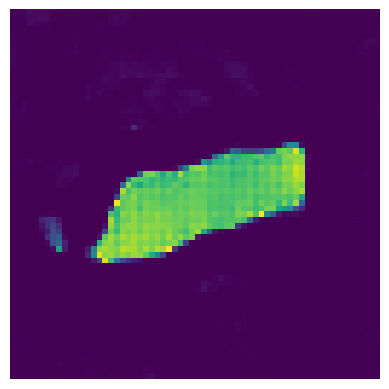

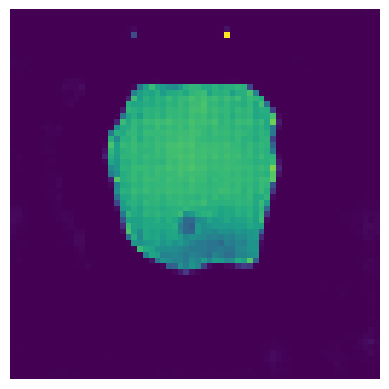

313/313 [==============================] - 79s 249ms/step - d_loss: 7.7131 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 29/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7138 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

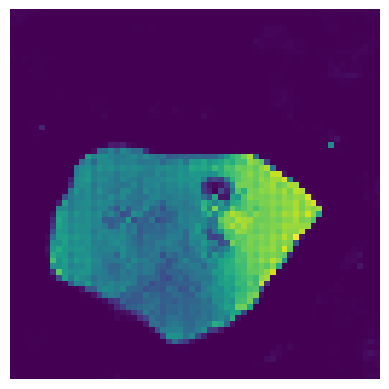

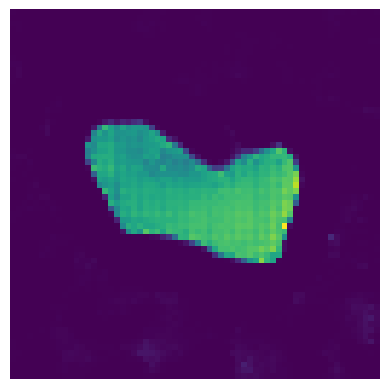

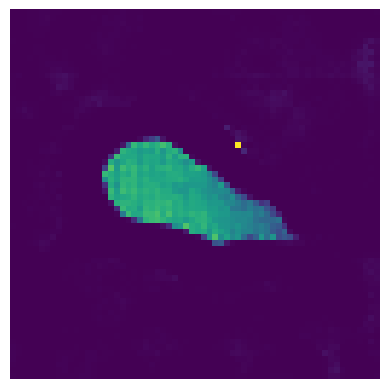

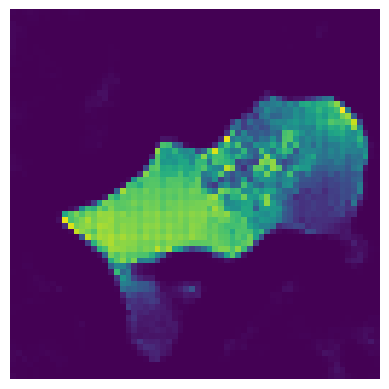

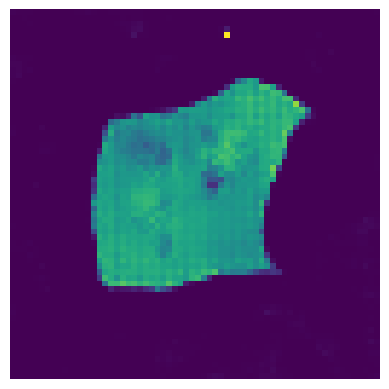

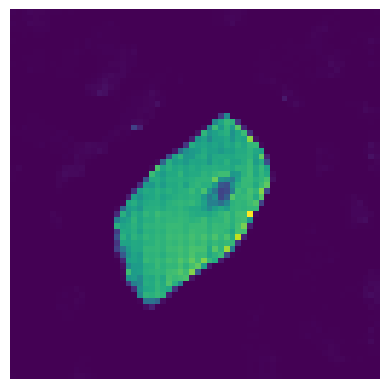

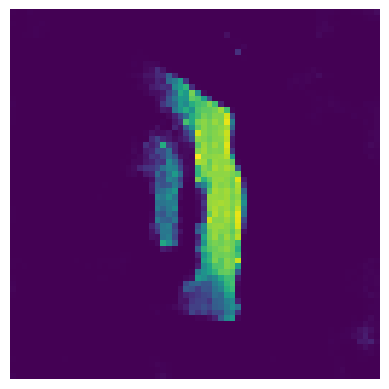

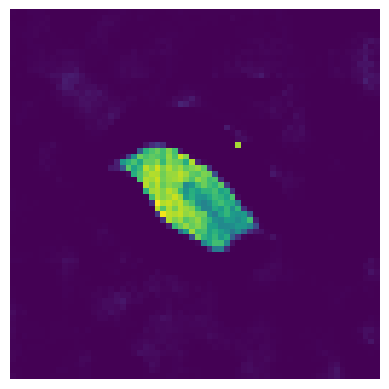

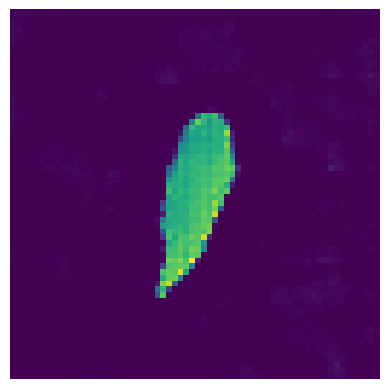

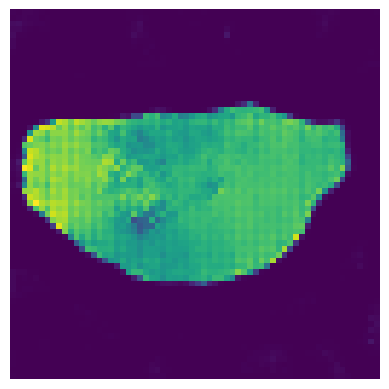

313/313 [==============================] - 79s 247ms/step - d_loss: 7.7138 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 30/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7138 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

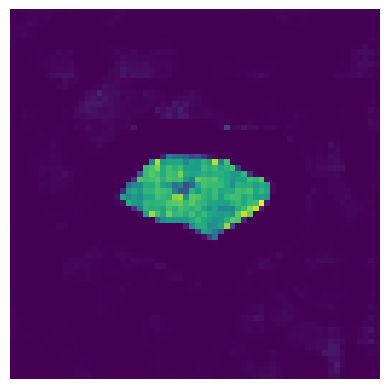

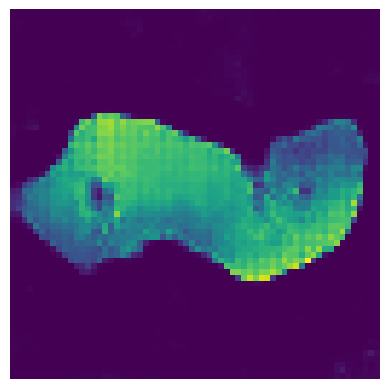

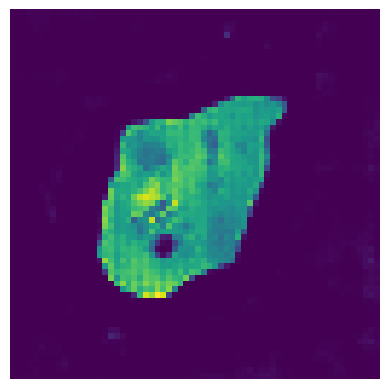

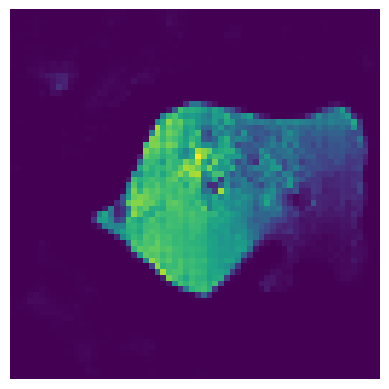

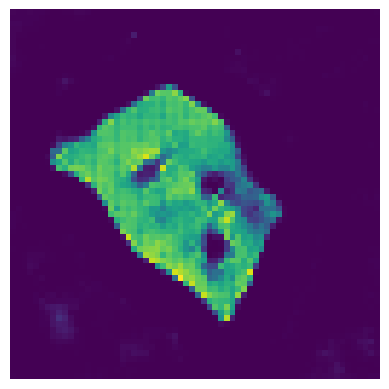

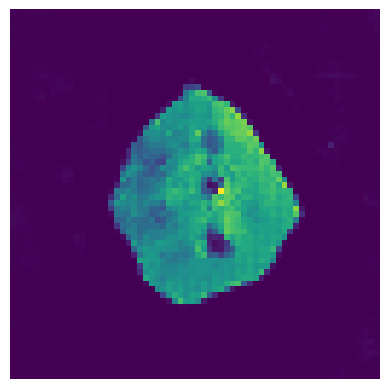

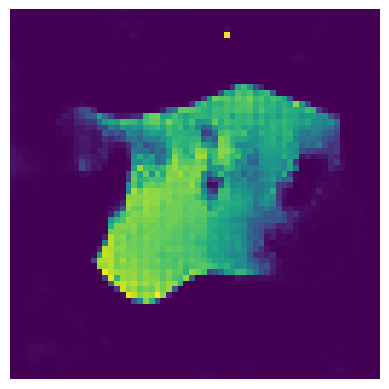

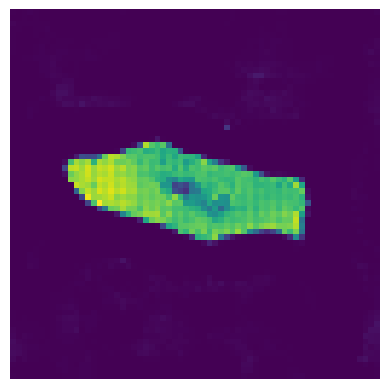

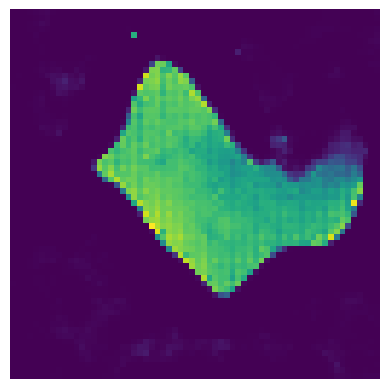

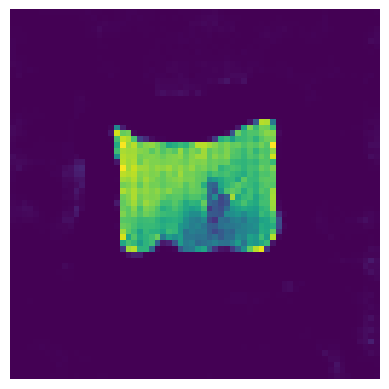

313/313 [==============================] - 79s 248ms/step - d_loss: 7.7138 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 31/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7143 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

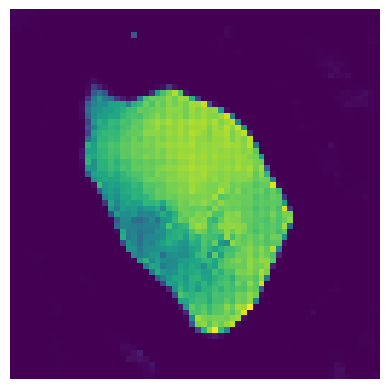

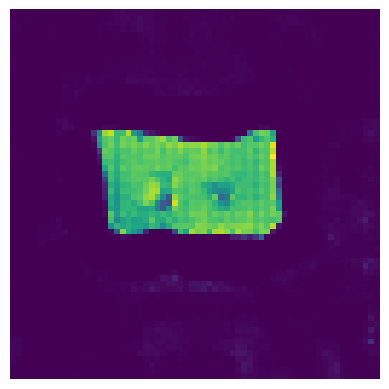

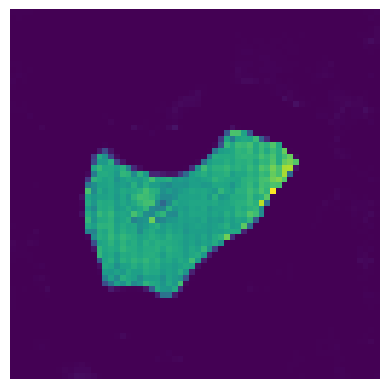

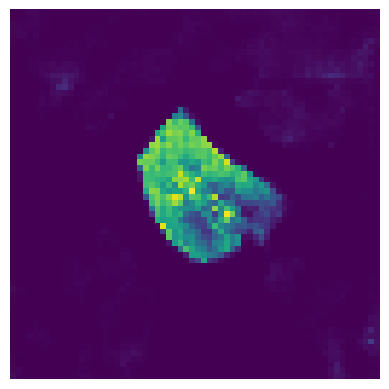

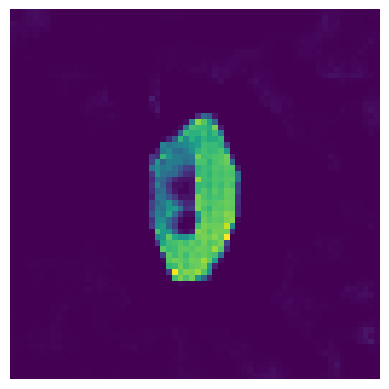

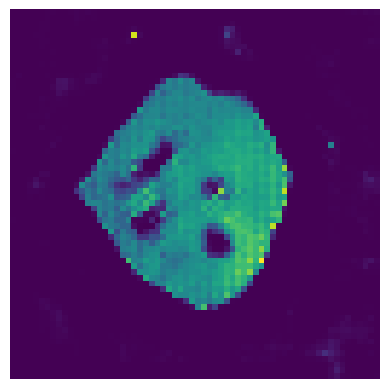

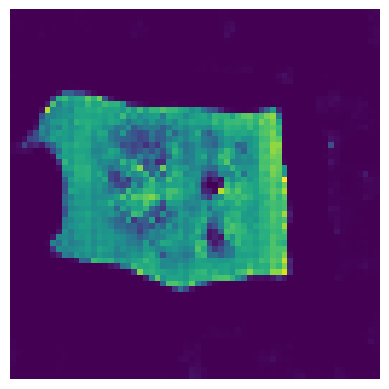

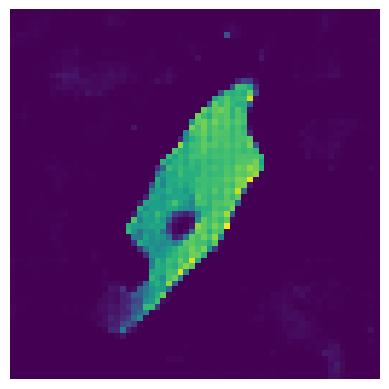

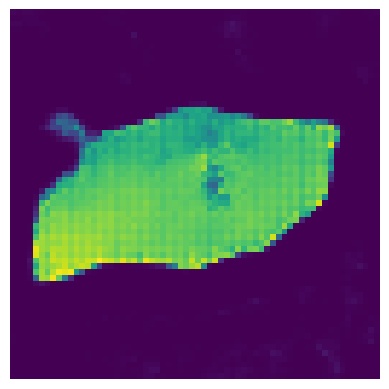

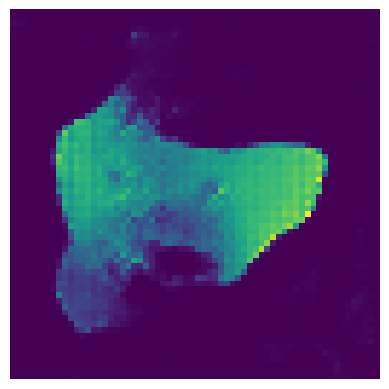

313/313 [==============================] - 81s 250ms/step - d_loss: 7.7143 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 32/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7102 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

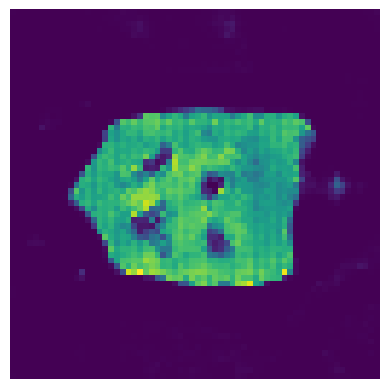

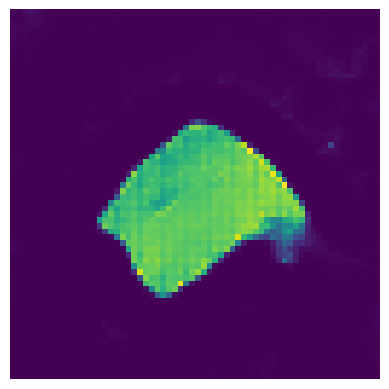

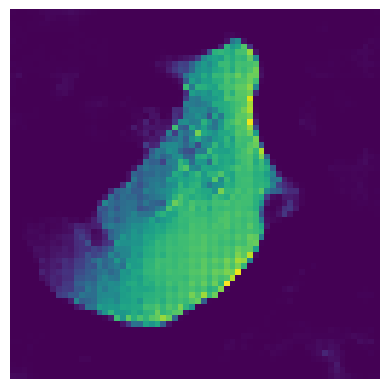

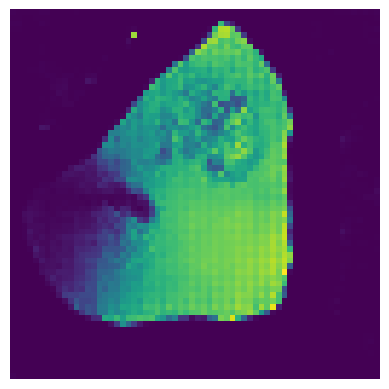

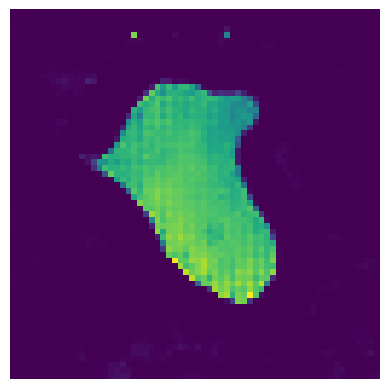

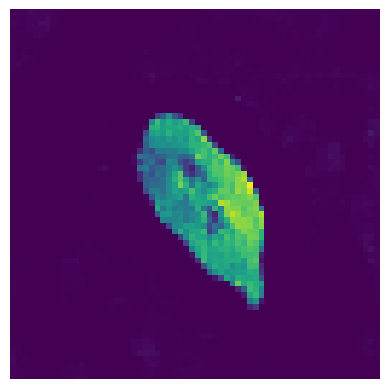

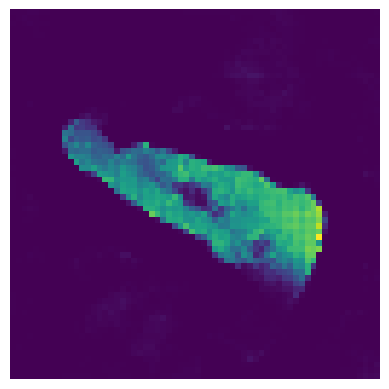

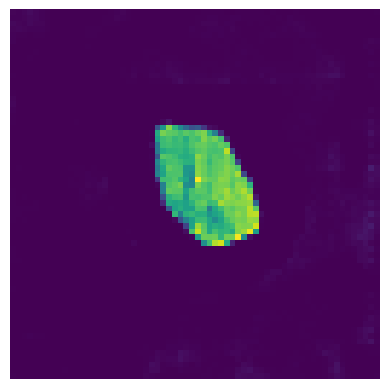

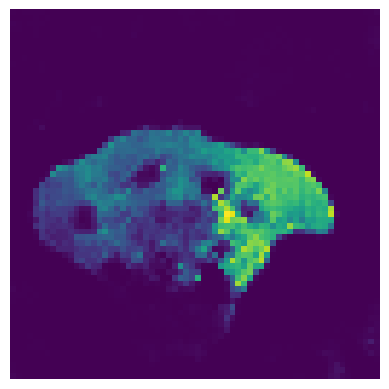

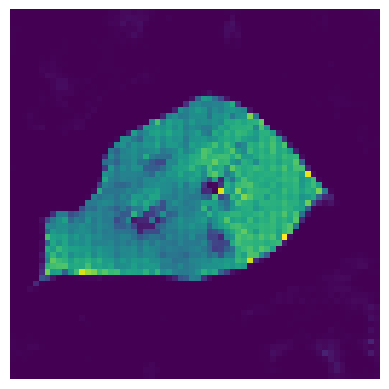

313/313 [==============================] - 80s 250ms/step - d_loss: 7.7102 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 33/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7130 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

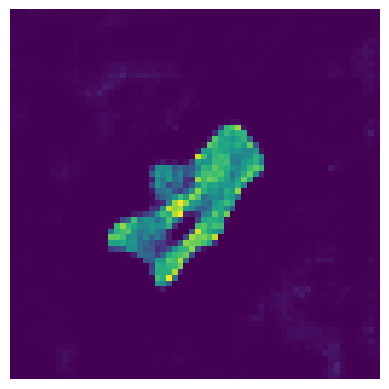

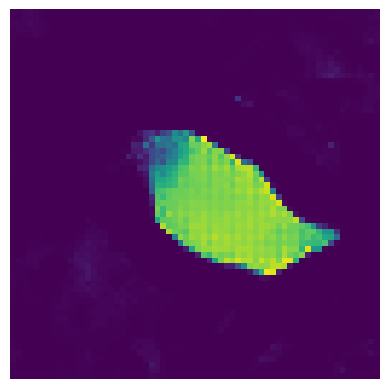

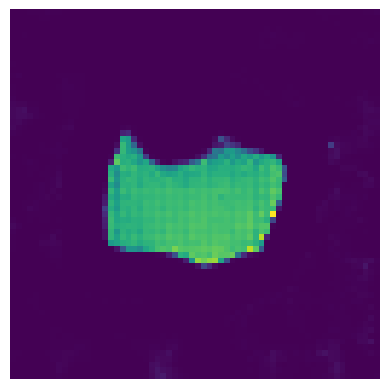

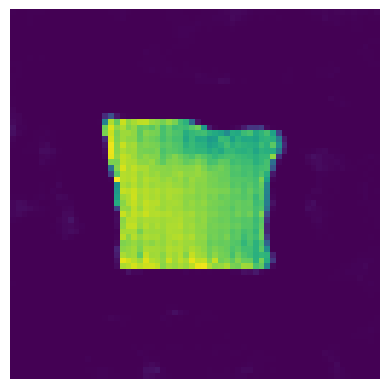

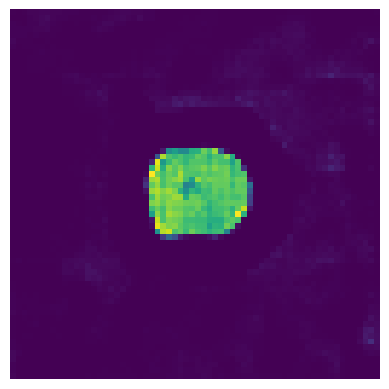

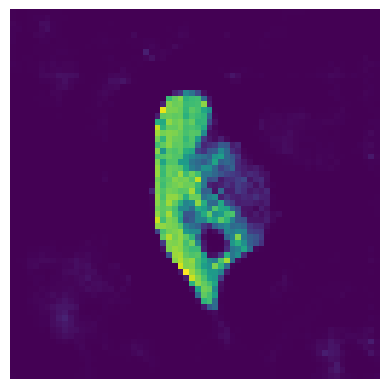

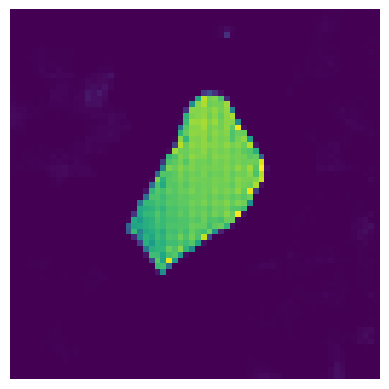

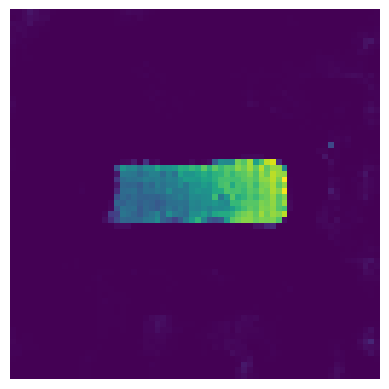

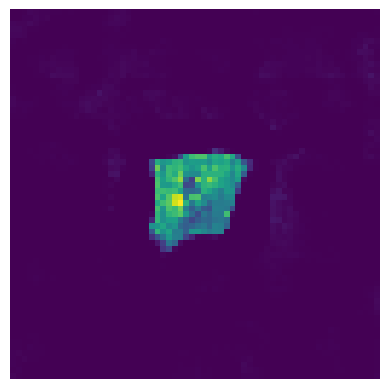

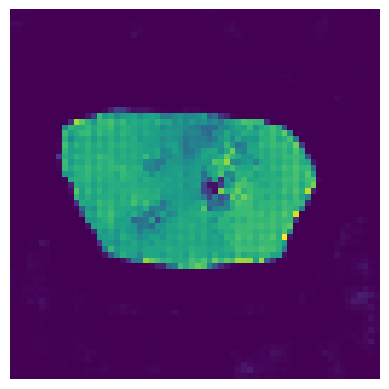

313/313 [==============================] - 81s 253ms/step - d_loss: 7.7130 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 34/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7143 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

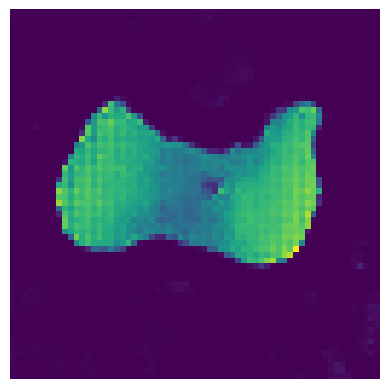

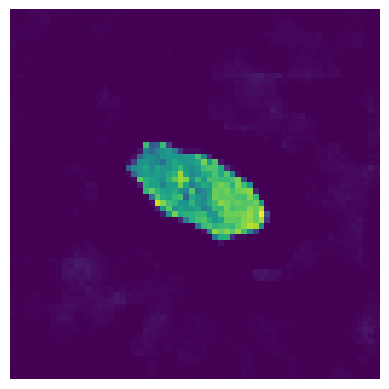

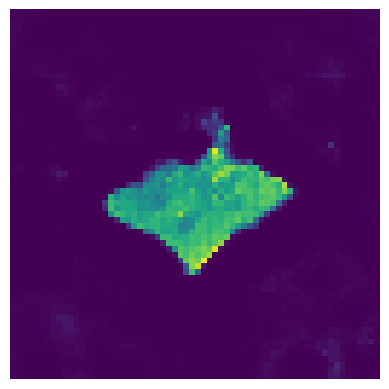

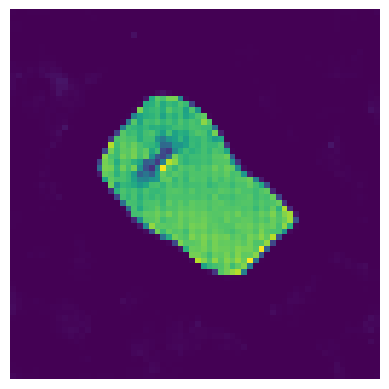

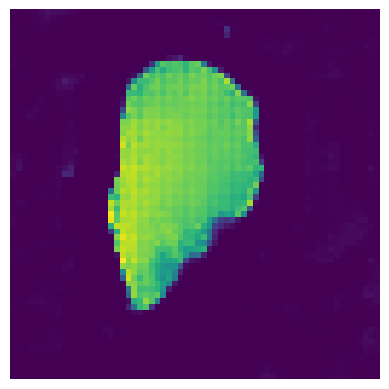

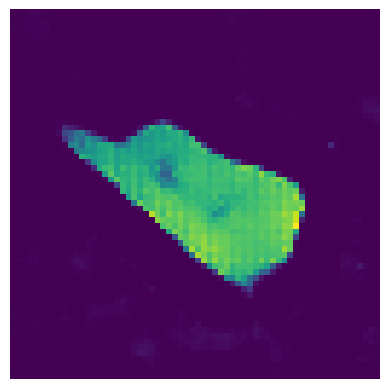

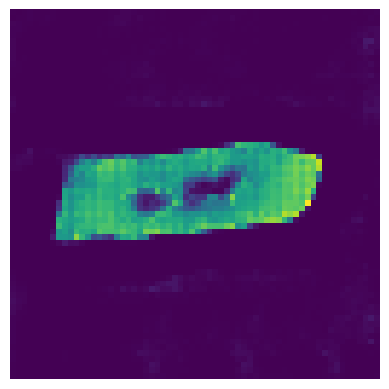

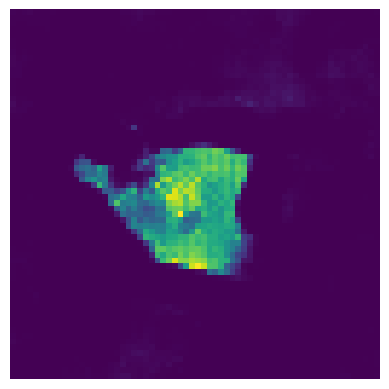

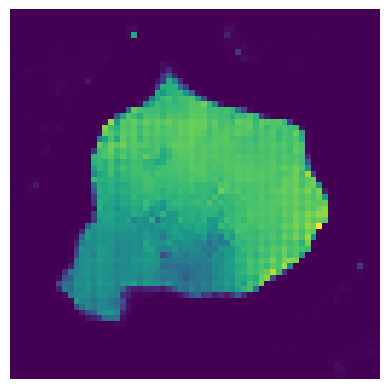

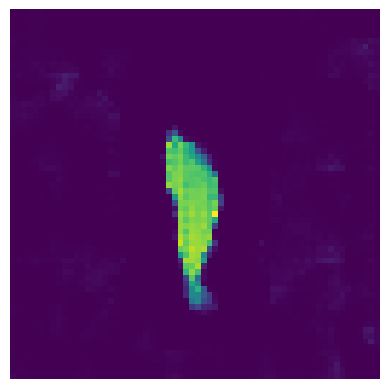

313/313 [==============================] - 81s 253ms/step - d_loss: 7.7143 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 35/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7152 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

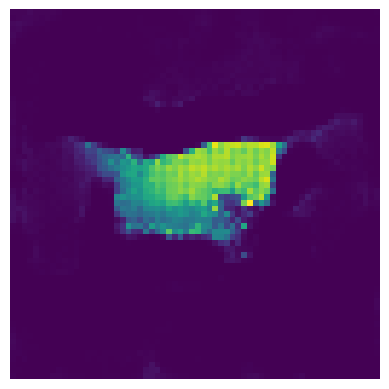

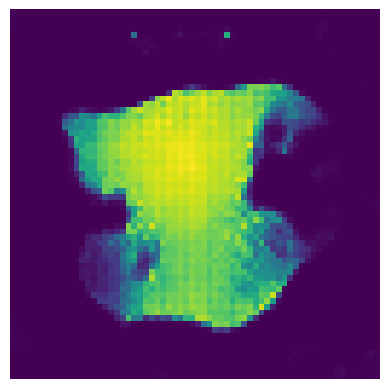

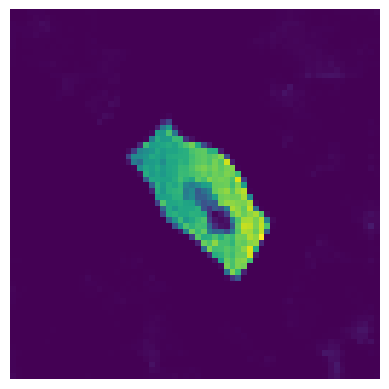

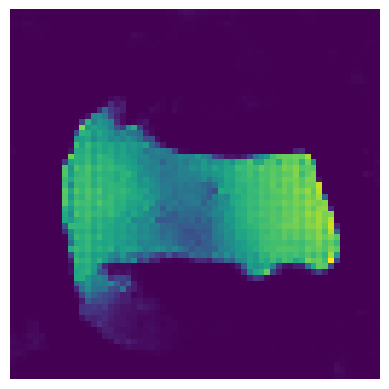

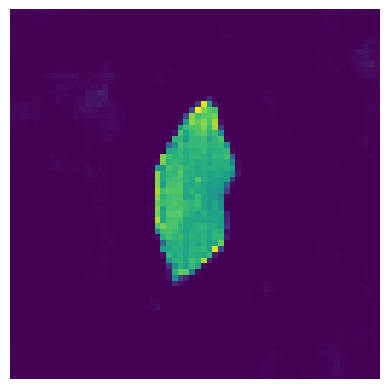

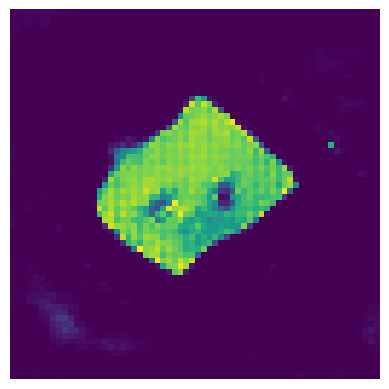

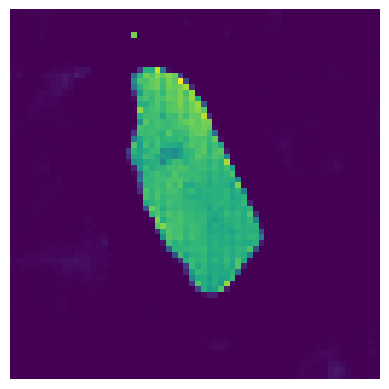

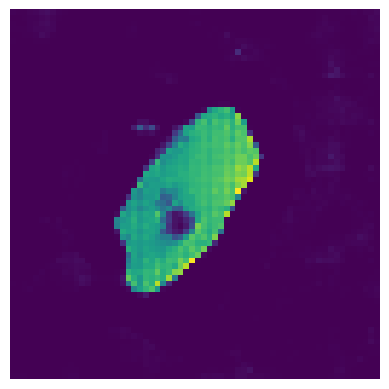

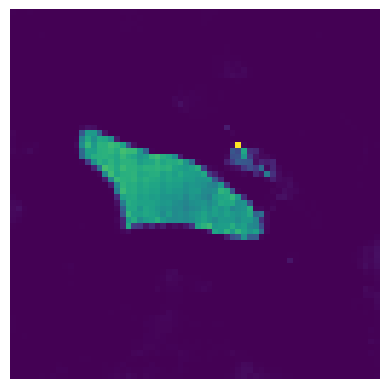

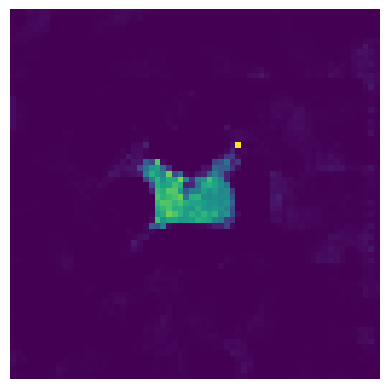

313/313 [==============================] - 81s 254ms/step - d_loss: 7.7152 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 36/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7114 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

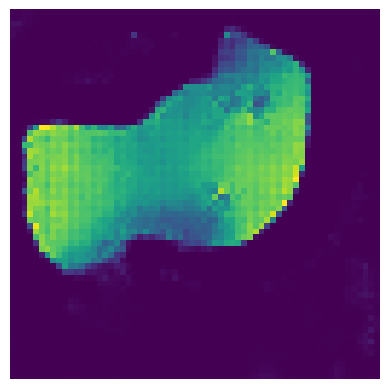

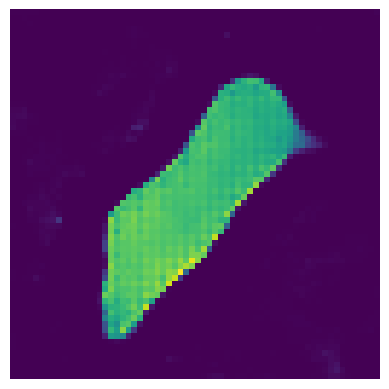

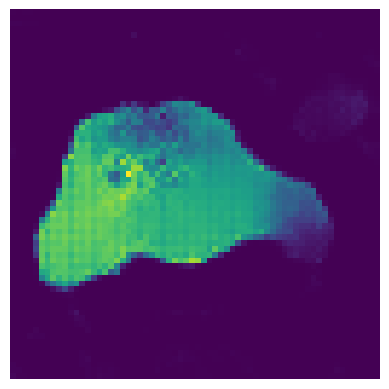

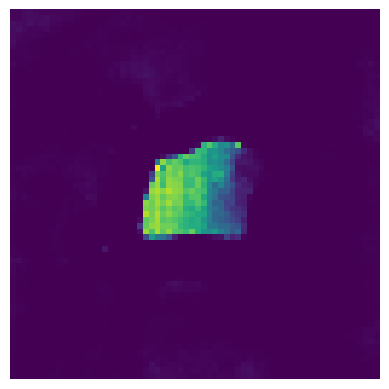

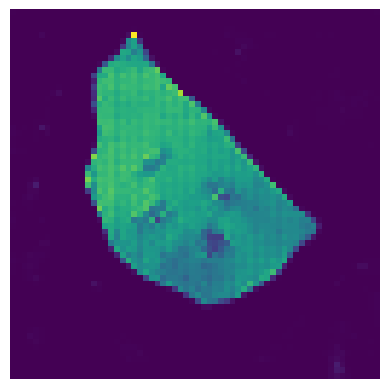

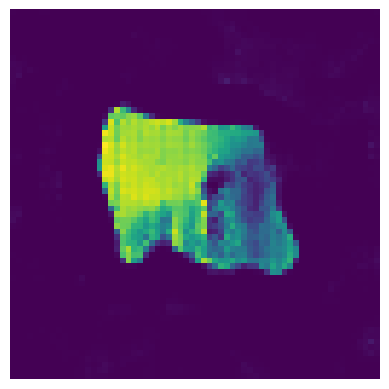

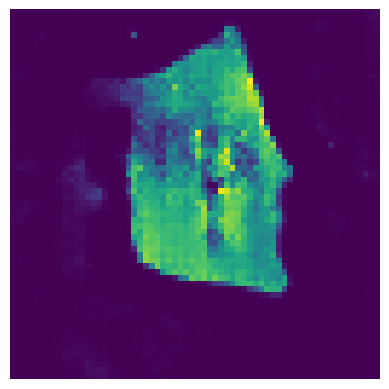

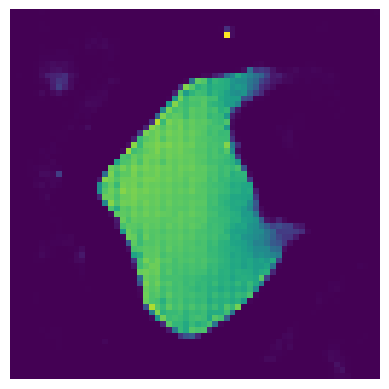

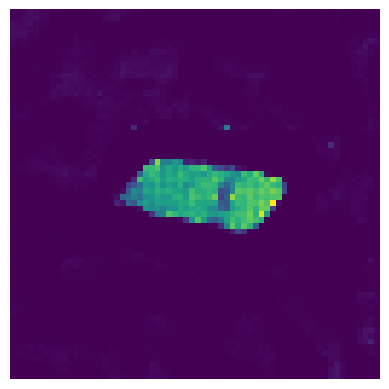

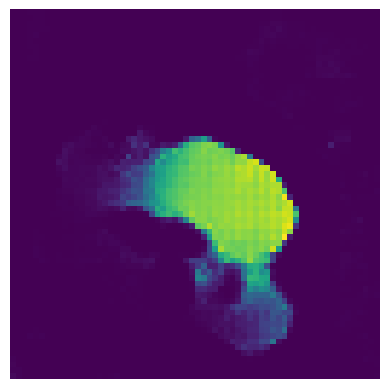

313/313 [==============================] - 80s 252ms/step - d_loss: 7.7114 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 37/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7144 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

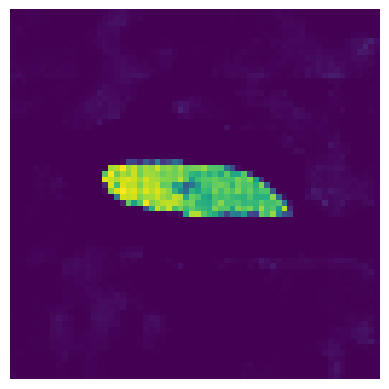

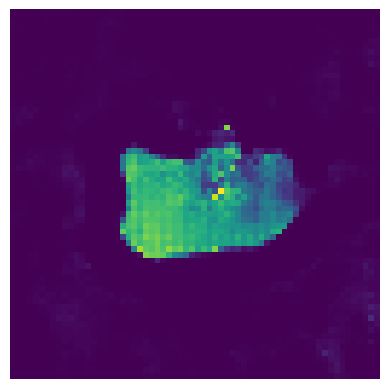

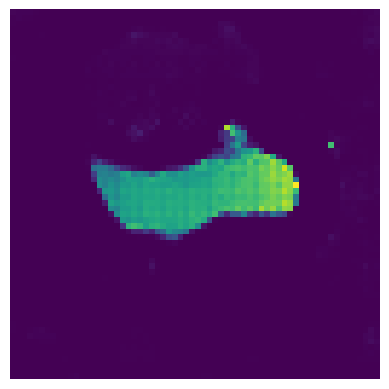

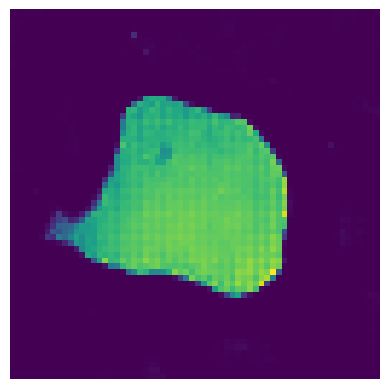

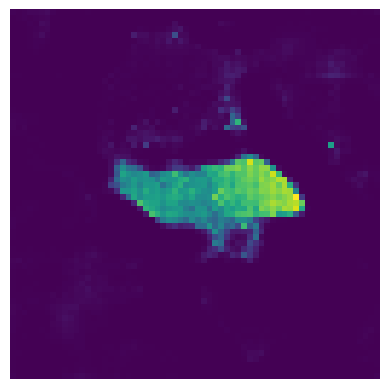

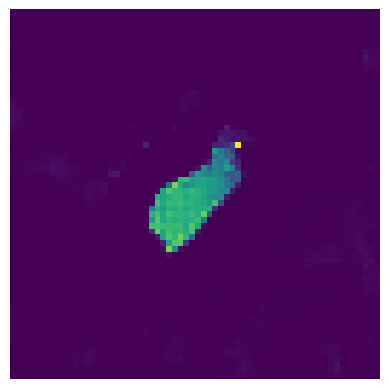

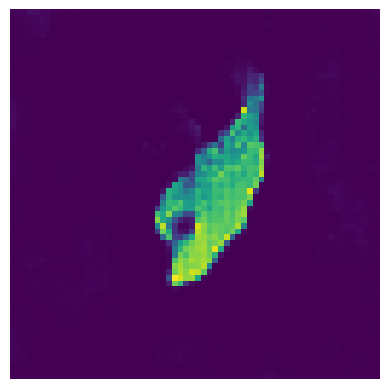

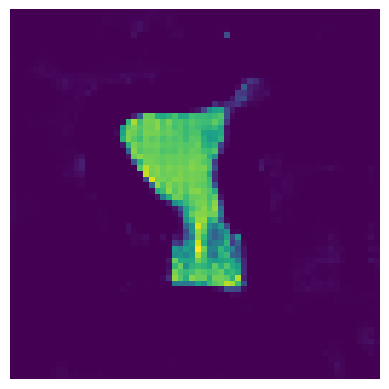

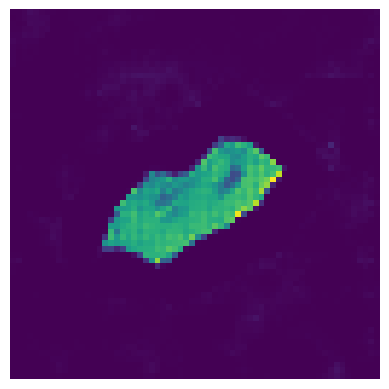

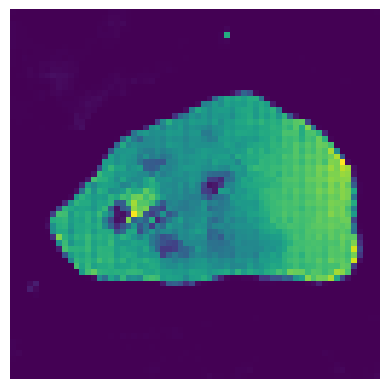

313/313 [==============================] - 80s 253ms/step - d_loss: 7.7144 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 38/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7121 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

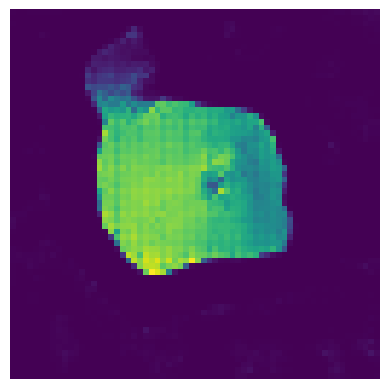

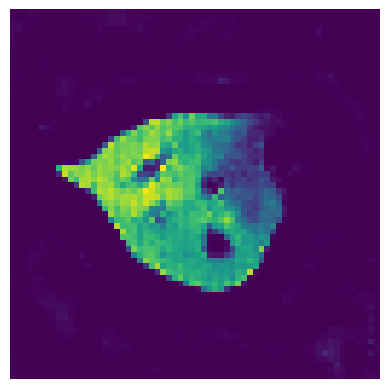

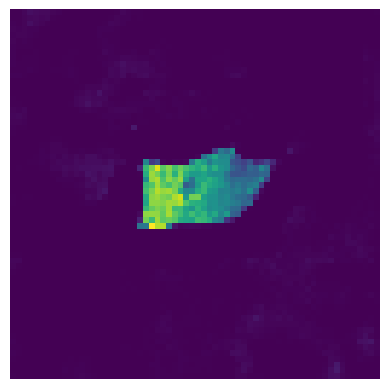

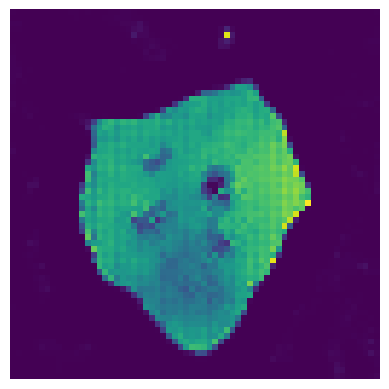

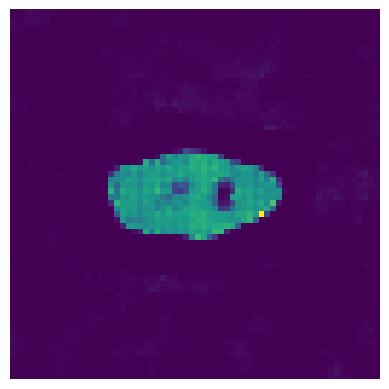

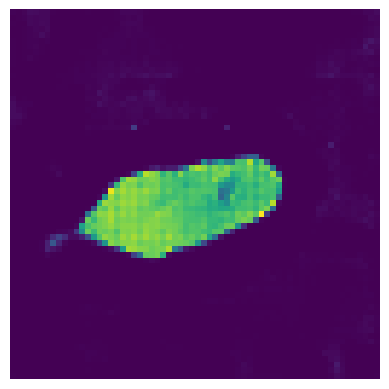

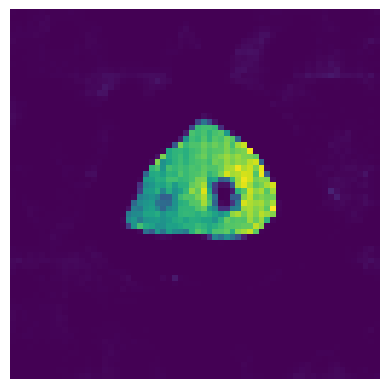

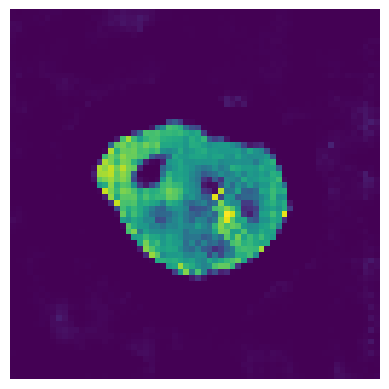

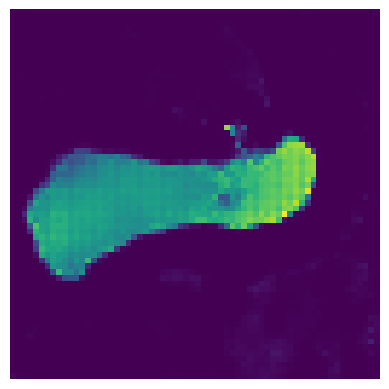

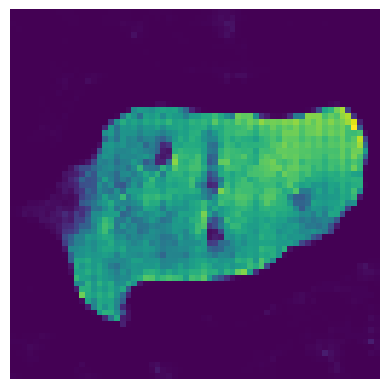

313/313 [==============================] - 81s 255ms/step - d_loss: 7.7121 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 39/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

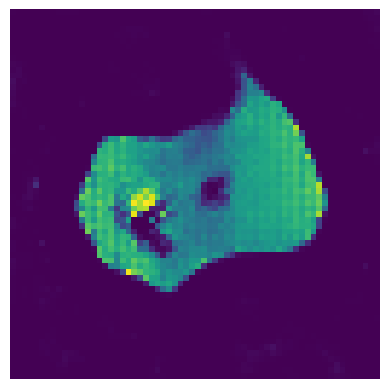

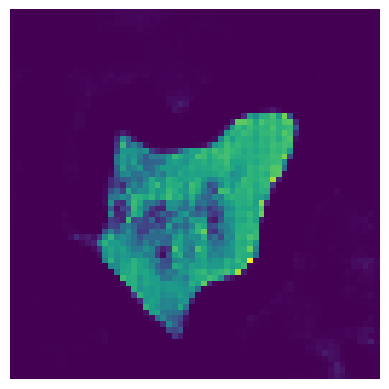

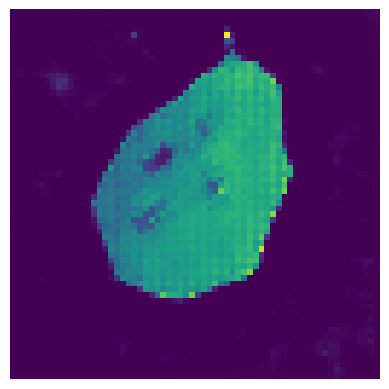

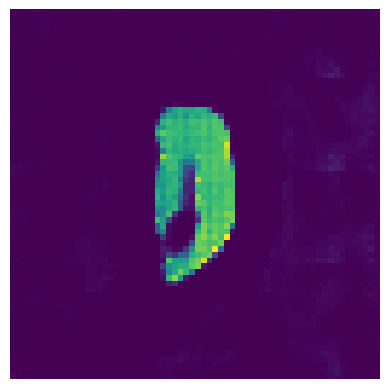

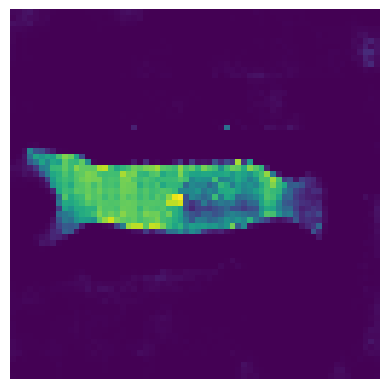

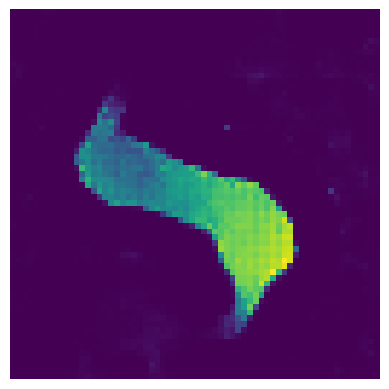

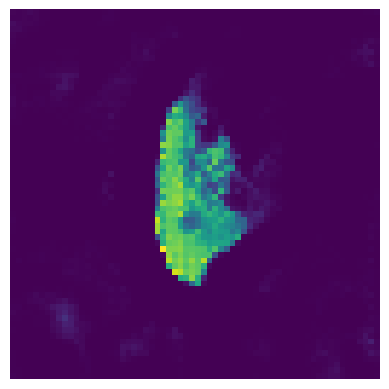

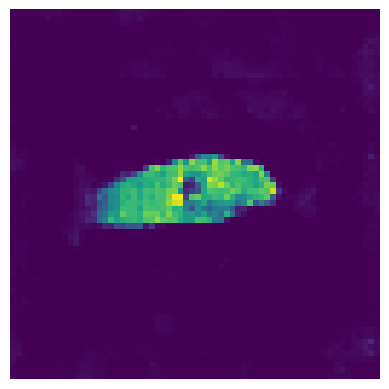

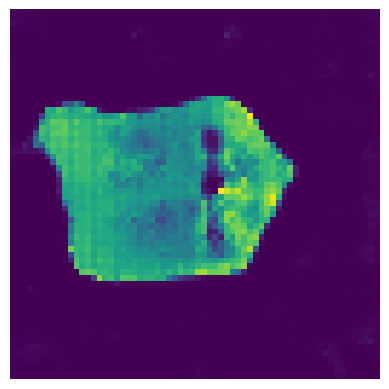

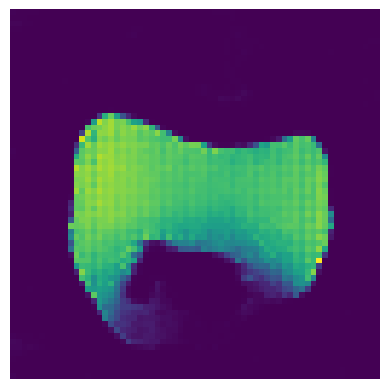

313/313 [==============================] - 82s 257ms/step - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 40/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7146 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

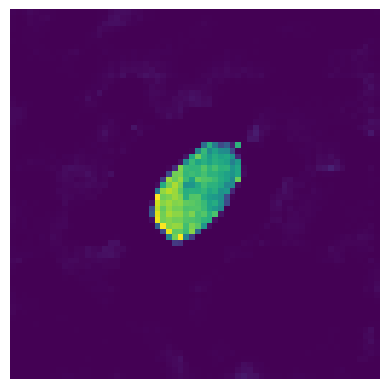

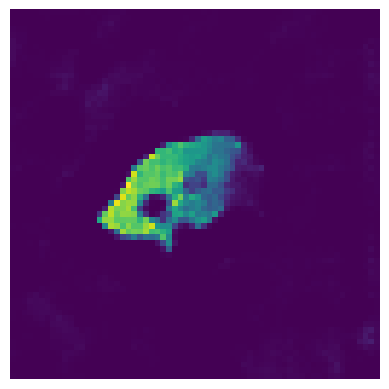

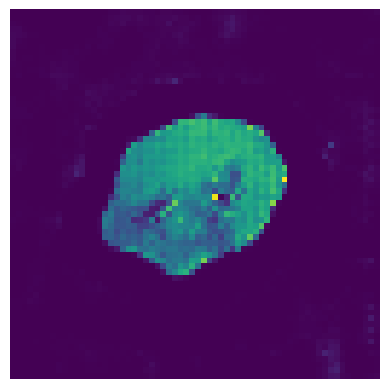

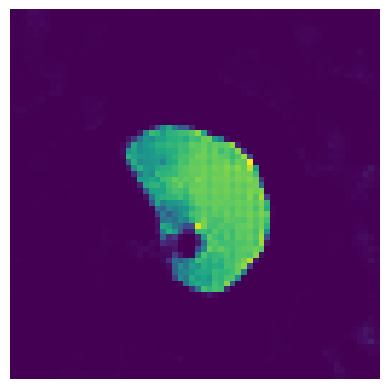

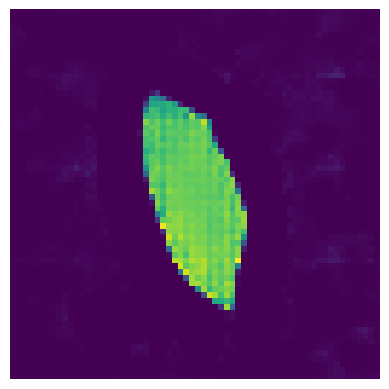

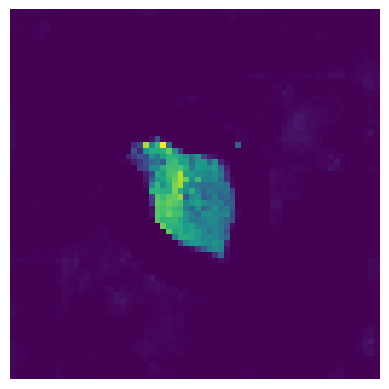

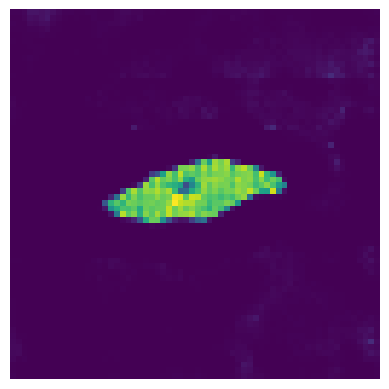

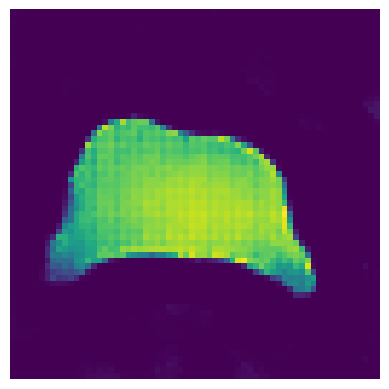

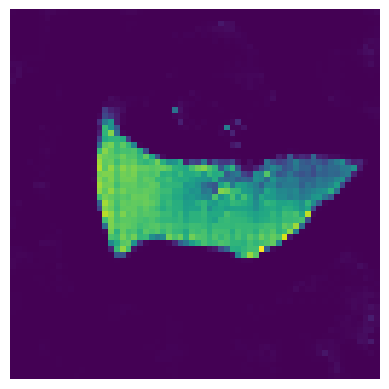

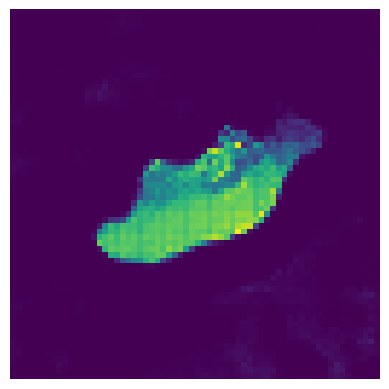

313/313 [==============================] - 82s 258ms/step - d_loss: 7.7146 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 41/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7111 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

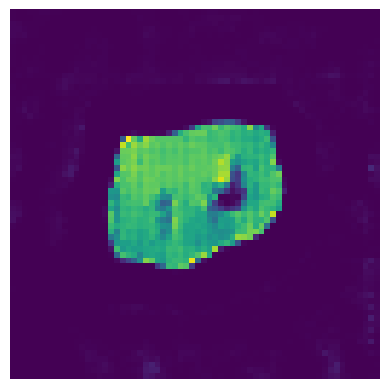

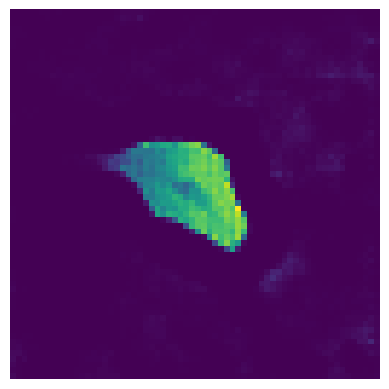

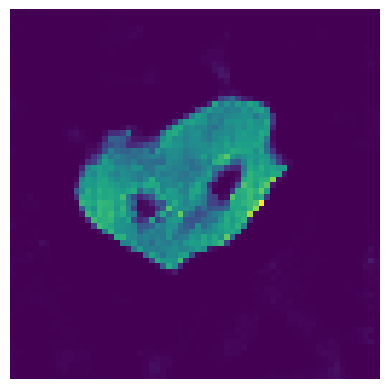

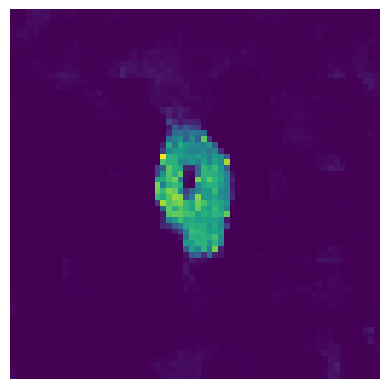

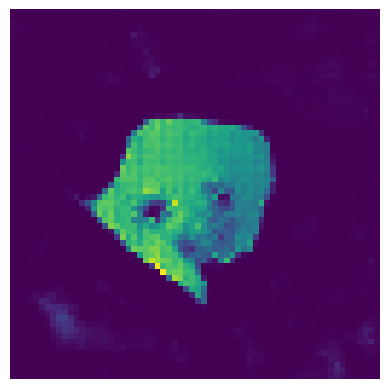

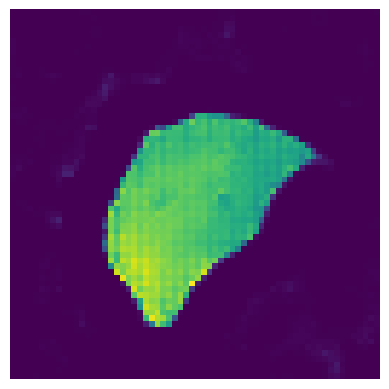

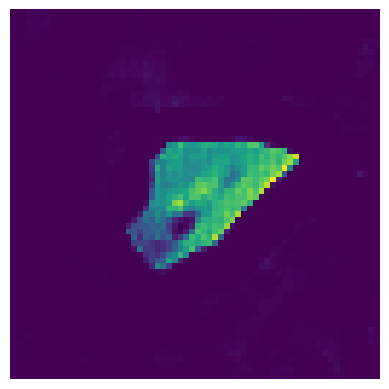

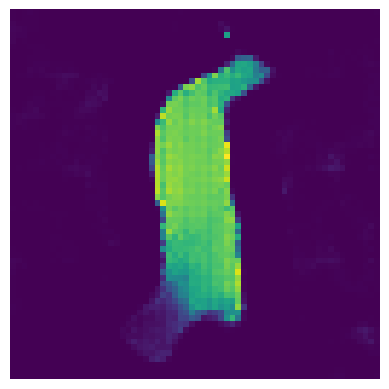

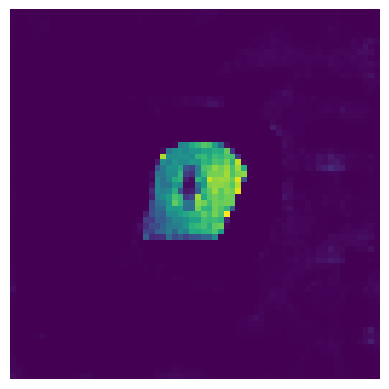

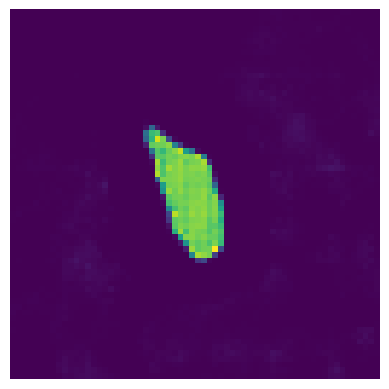

313/313 [==============================] - 81s 255ms/step - d_loss: 7.7111 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 42/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7102 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

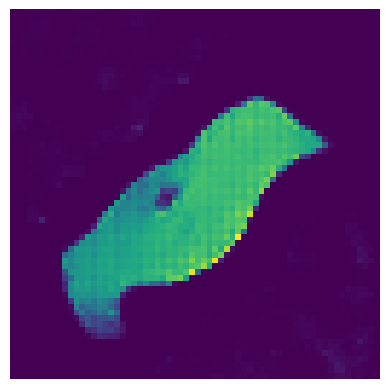

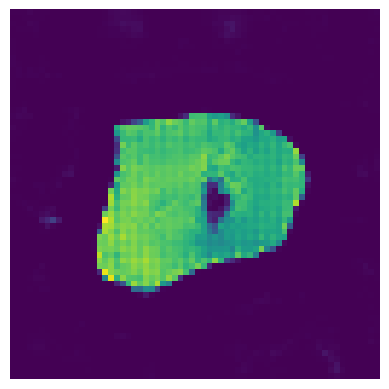

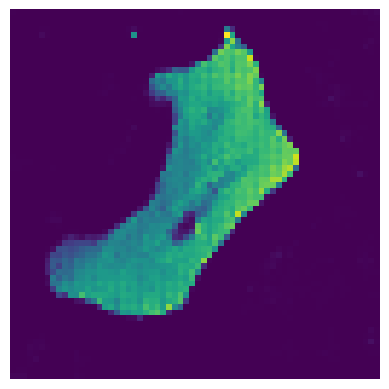

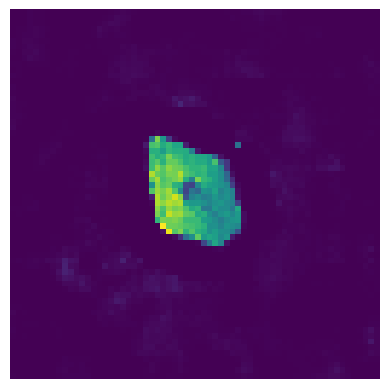

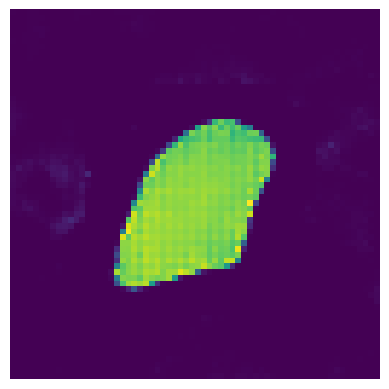

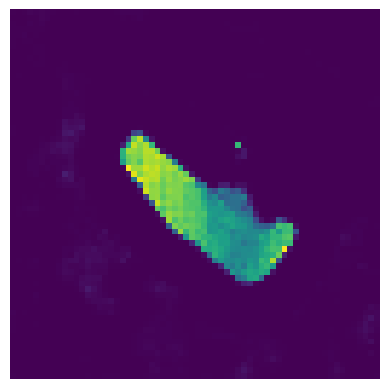

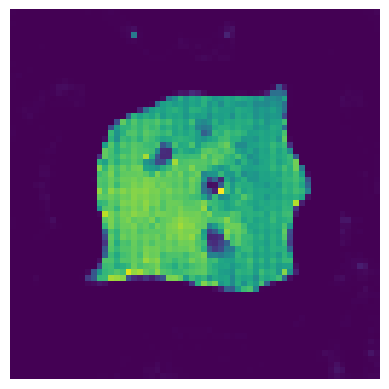

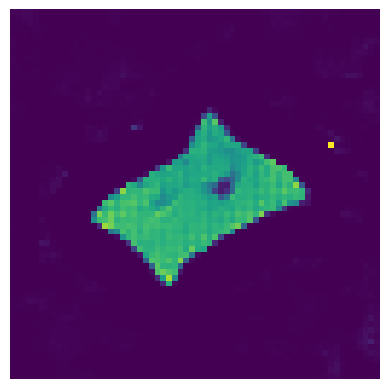

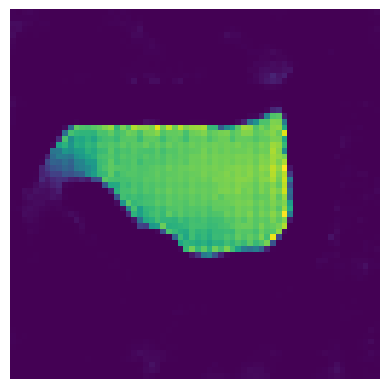

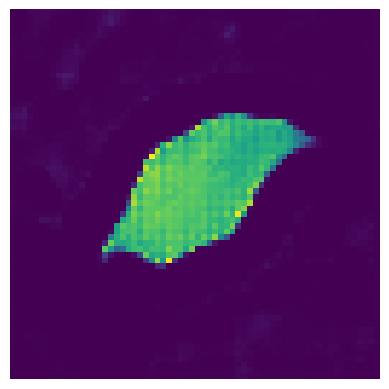

313/313 [==============================] - 82s 254ms/step - d_loss: 7.7102 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 43/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7162 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

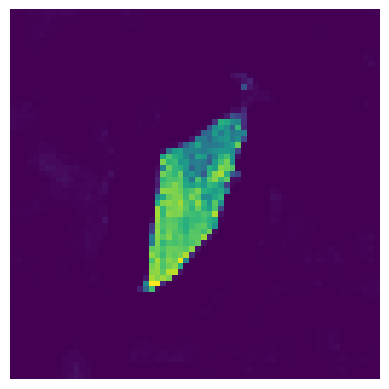

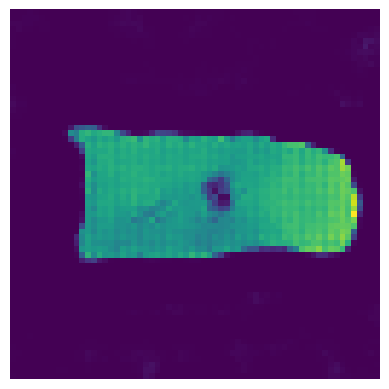

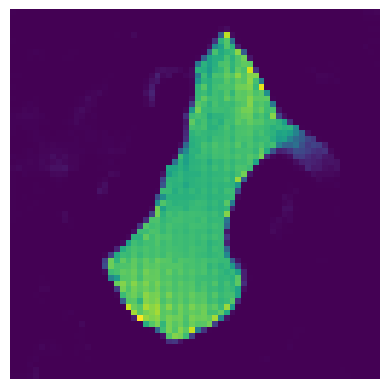

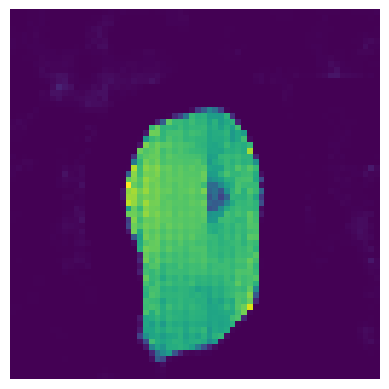

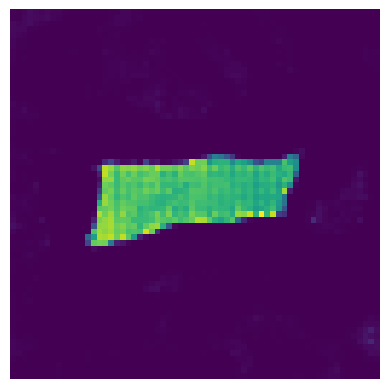

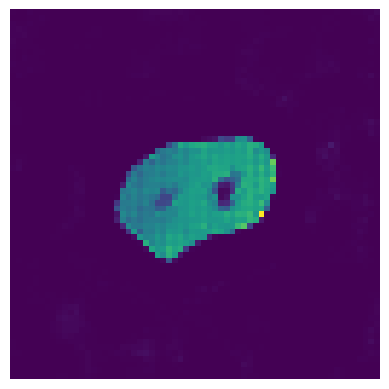

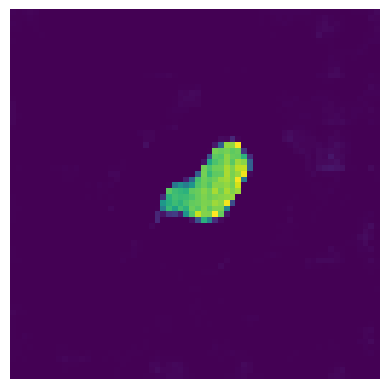

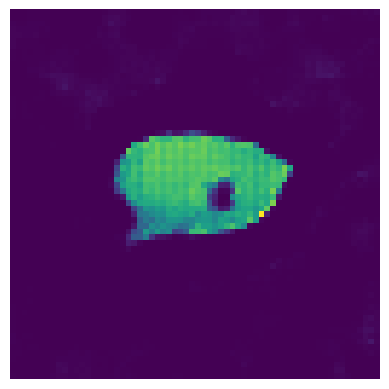

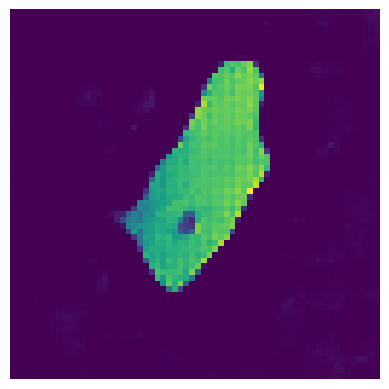

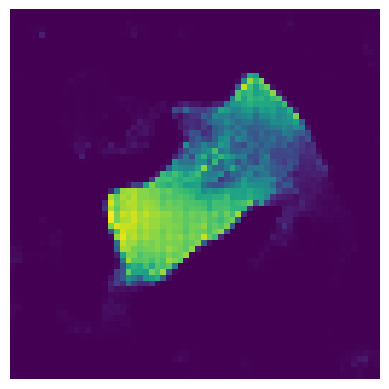

313/313 [==============================] - 82s 257ms/step - d_loss: 7.7162 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 44/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7117 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

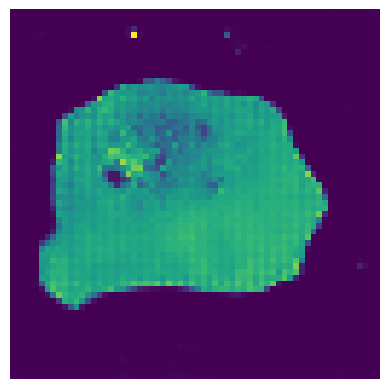

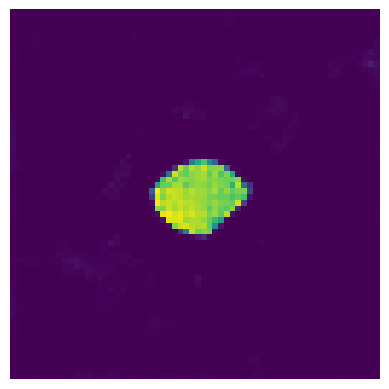

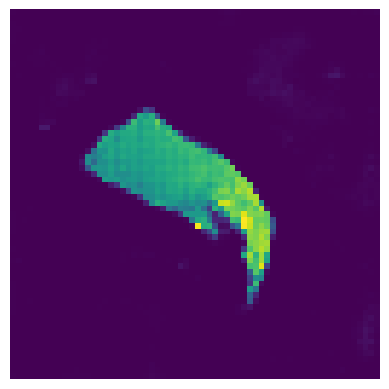

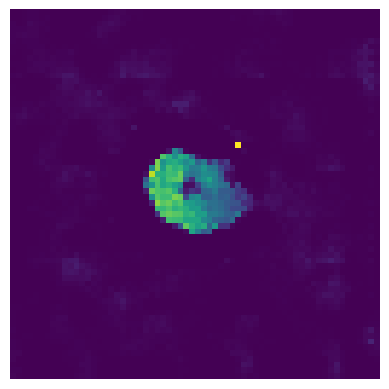

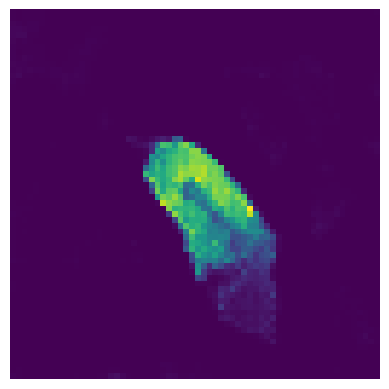

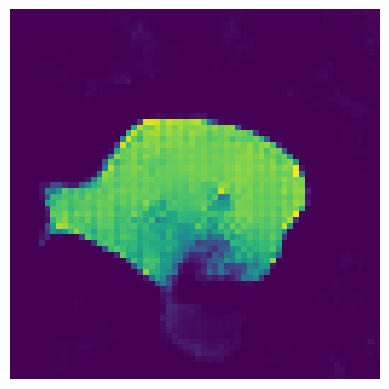

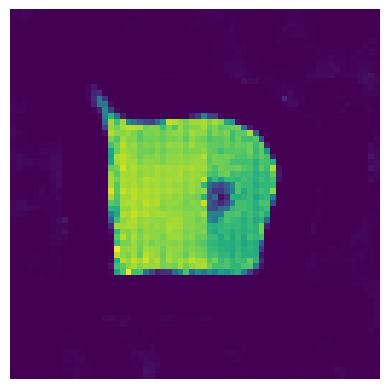

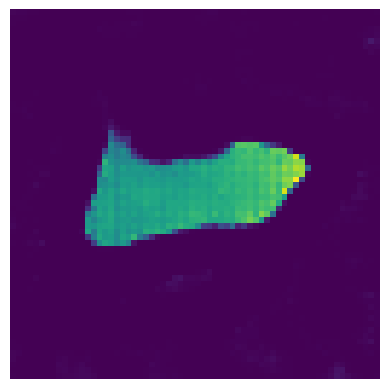

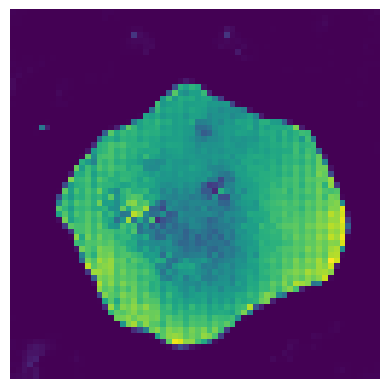

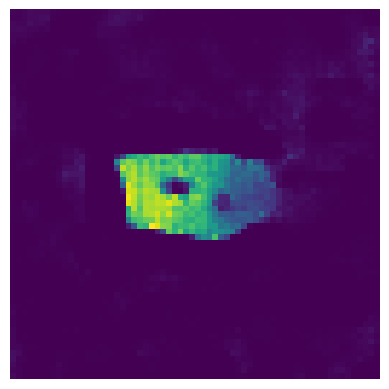

313/313 [==============================] - 83s 257ms/step - d_loss: 7.7117 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 45/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7132 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

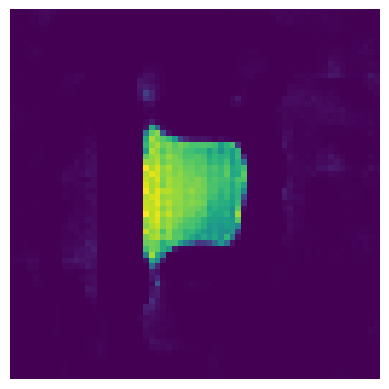

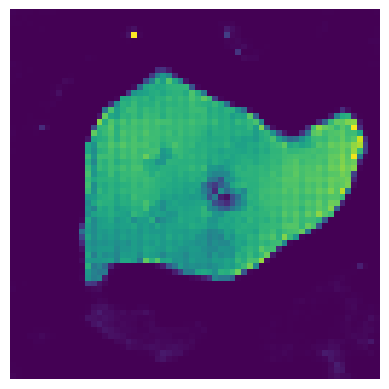

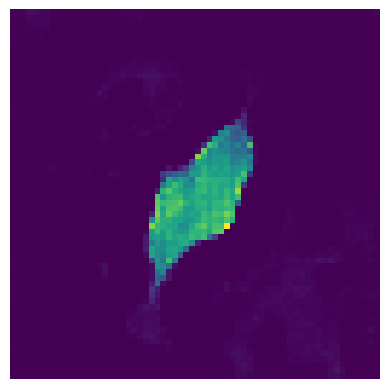

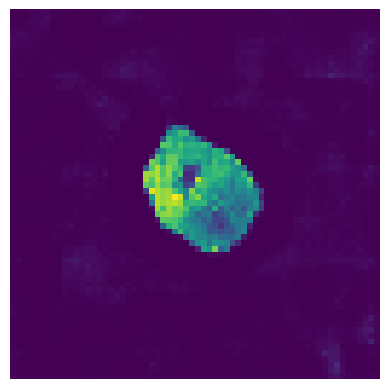

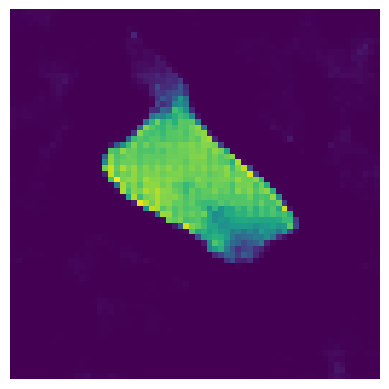

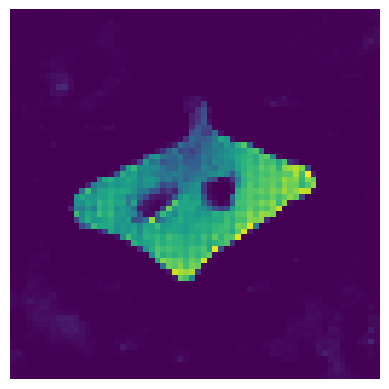

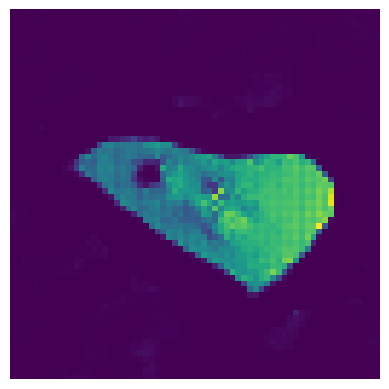

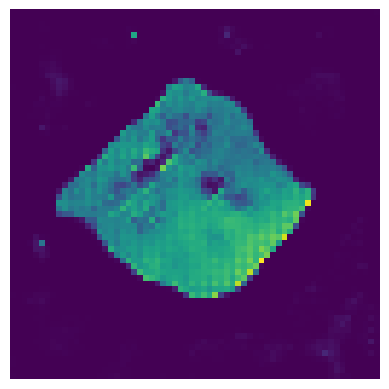

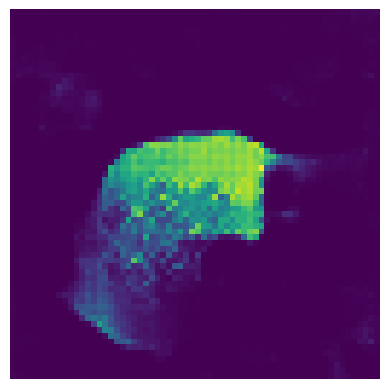

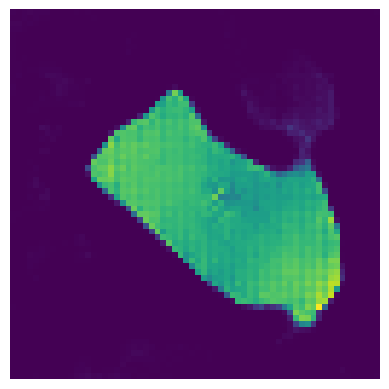

313/313 [==============================] - 83s 260ms/step - d_loss: 7.7132 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 46/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7159 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

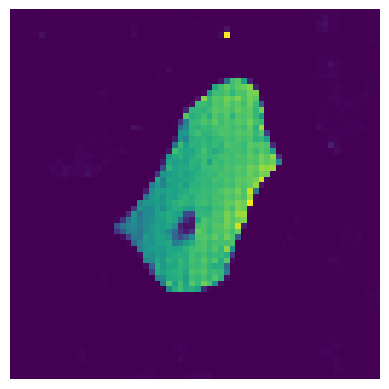

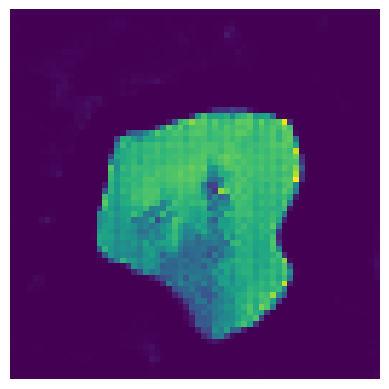

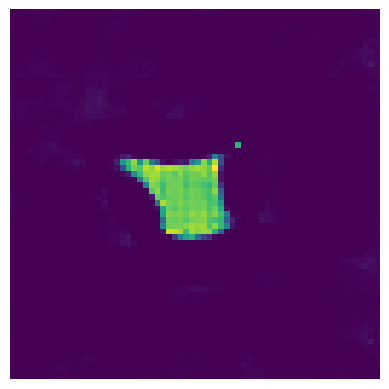

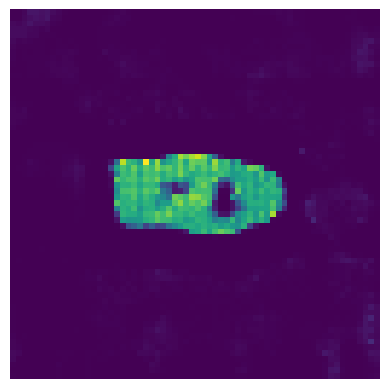

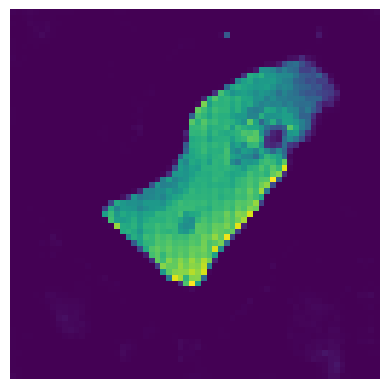

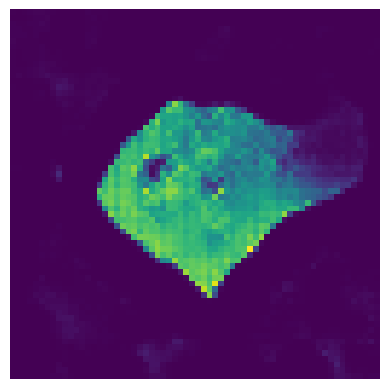

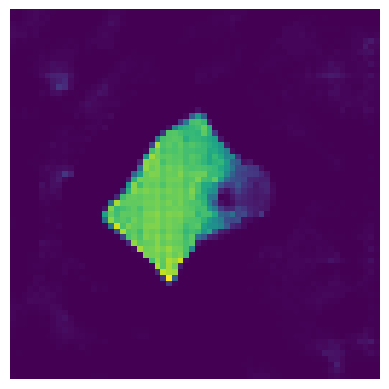

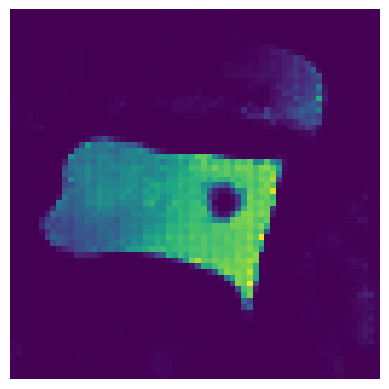

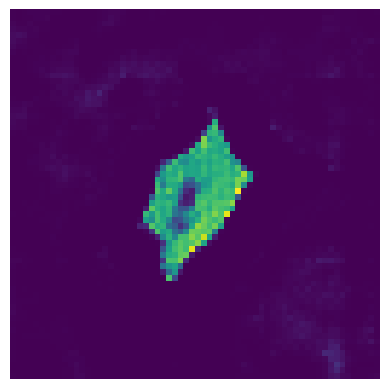

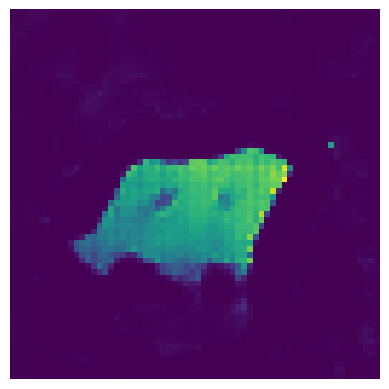

313/313 [==============================] - 83s 259ms/step - d_loss: 7.7159 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 47/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7126 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

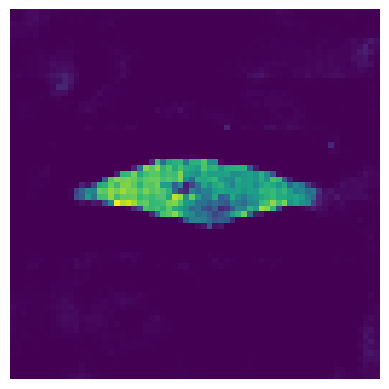

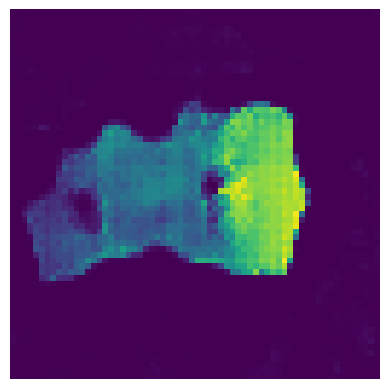

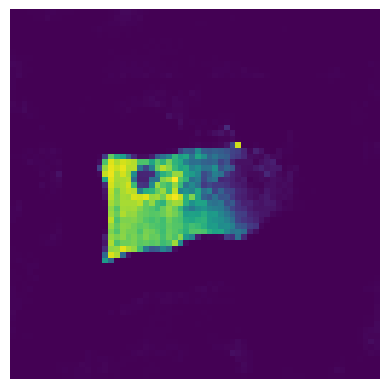

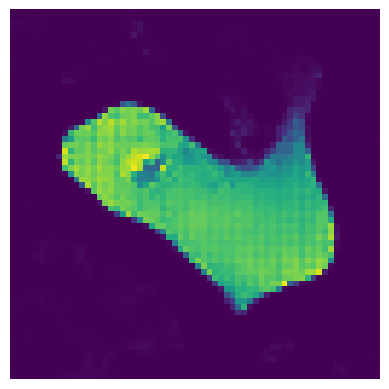

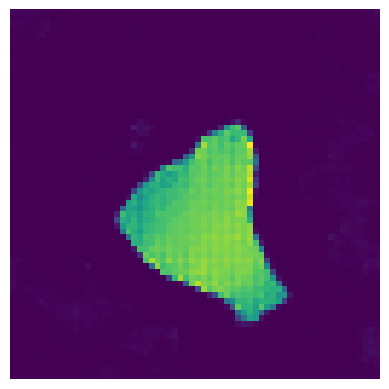

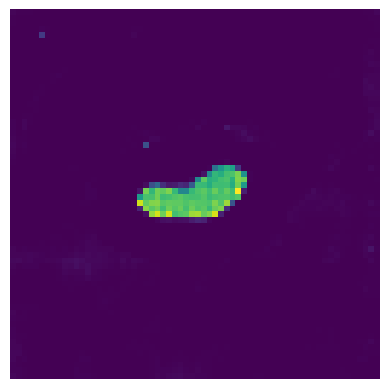

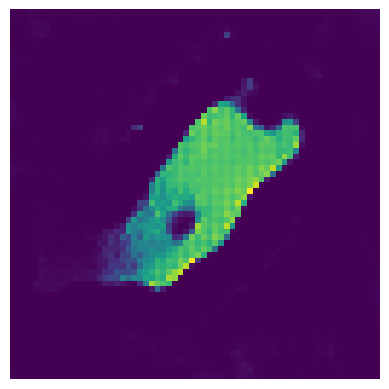

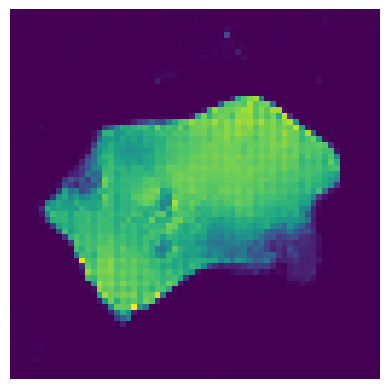

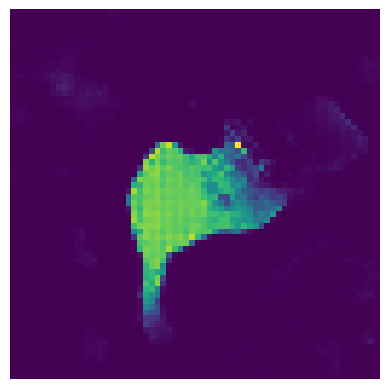

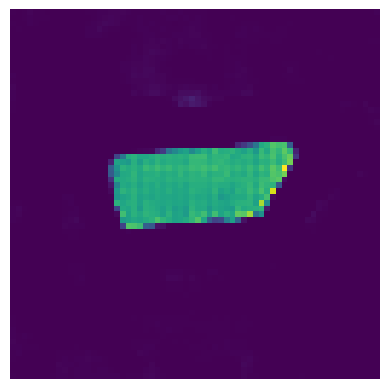

313/313 [==============================] - 83s 261ms/step - d_loss: 7.7126 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 48/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7121 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

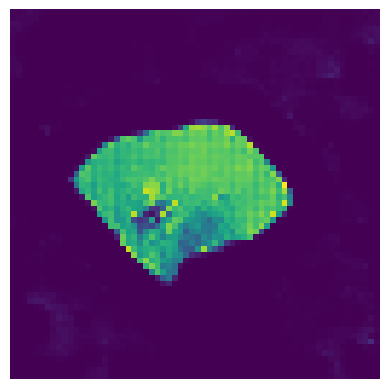

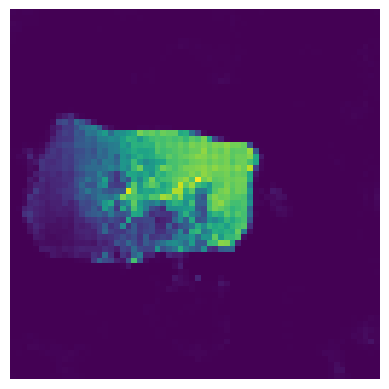

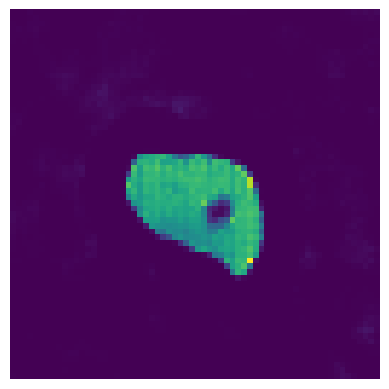

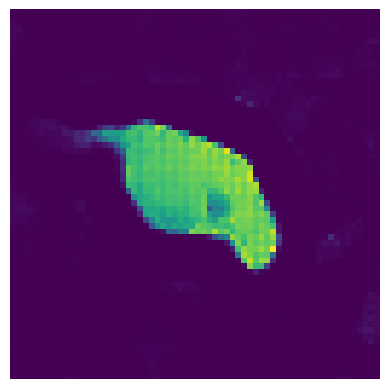

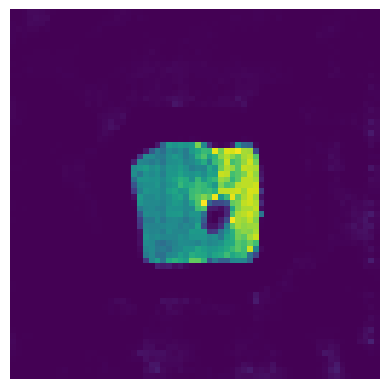

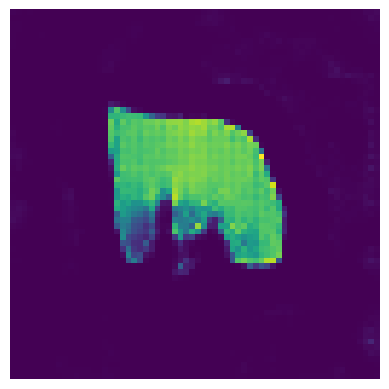

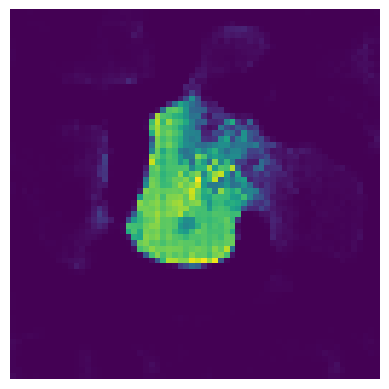

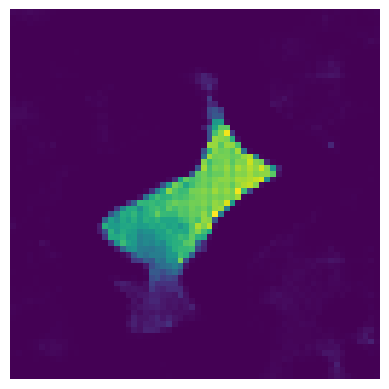

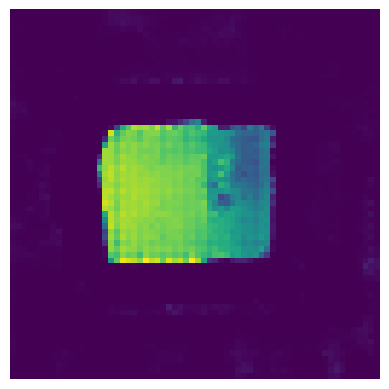

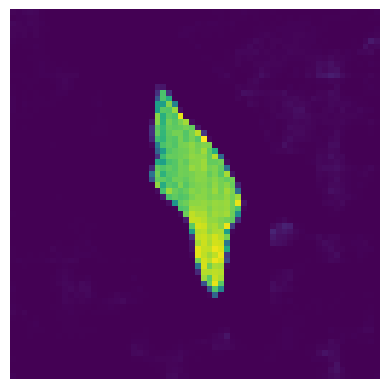

313/313 [==============================] - 83s 262ms/step - d_loss: 7.7121 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 49/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7140 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

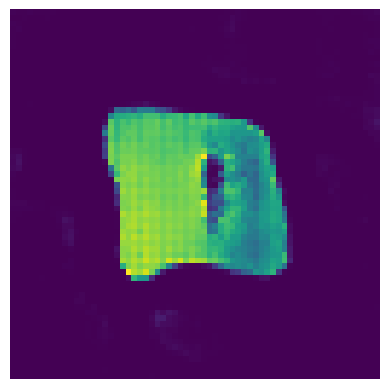

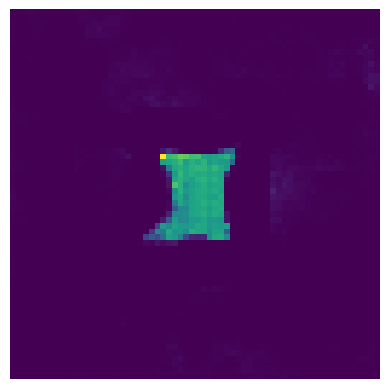

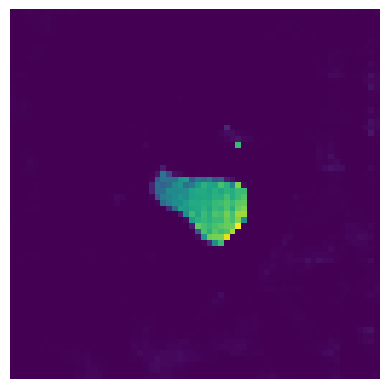

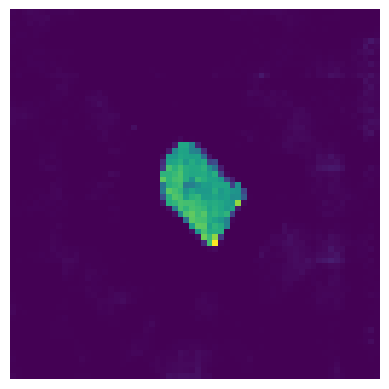

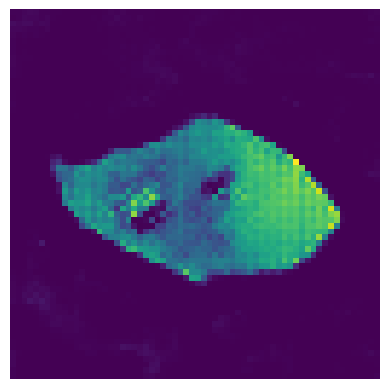

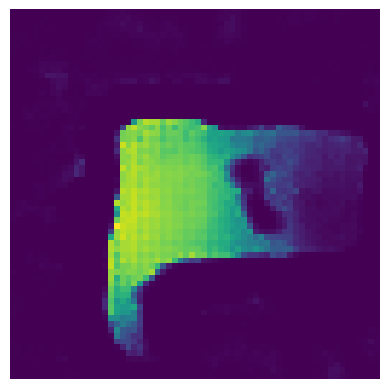

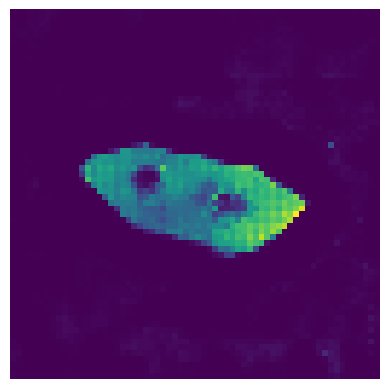

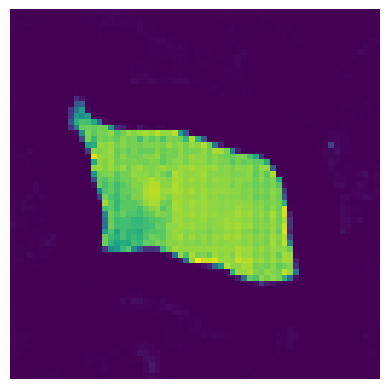

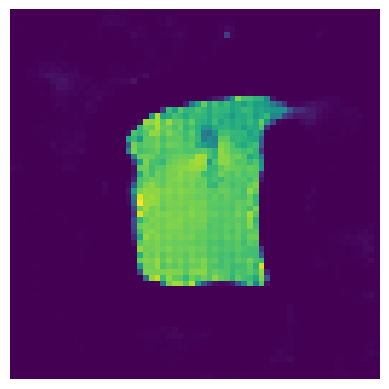

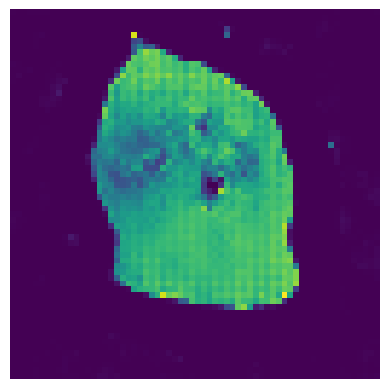

313/313 [==============================] - 84s 263ms/step - d_loss: 7.7140 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 50/50
313/313 [==============================] - ETA: 0s - d_loss: 7.7158 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

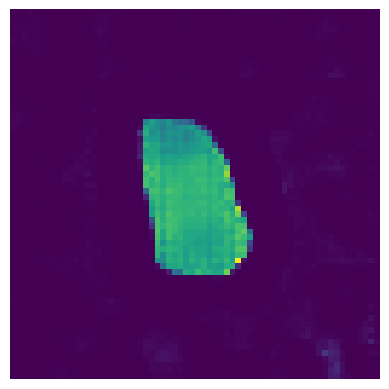

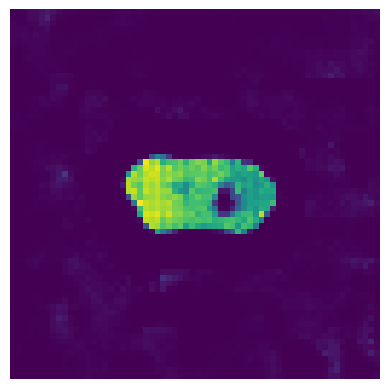

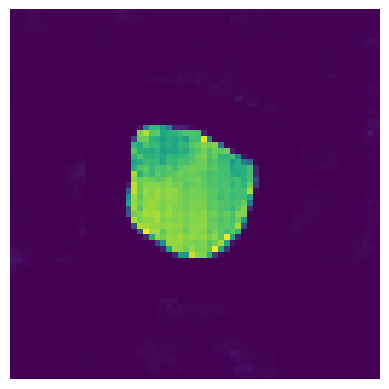

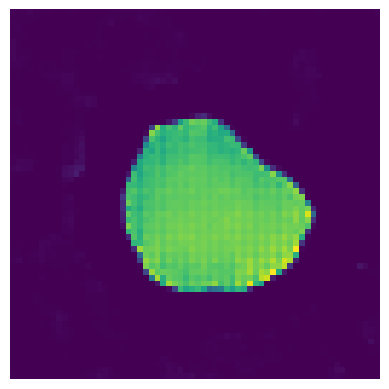

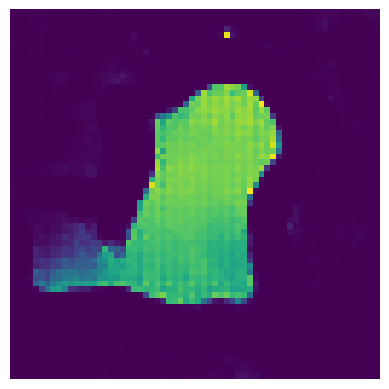

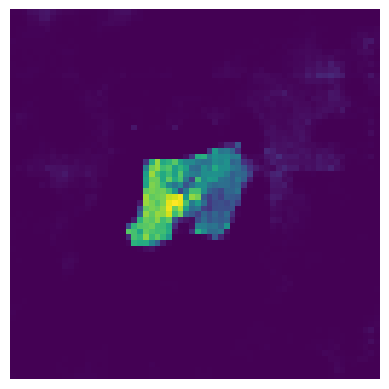

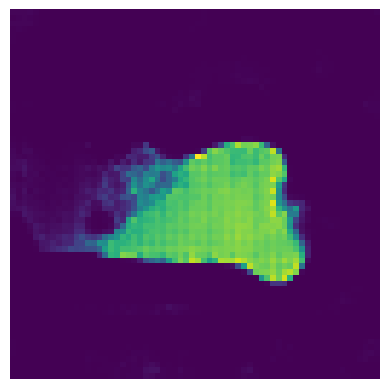

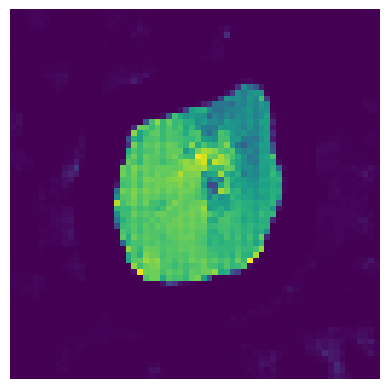

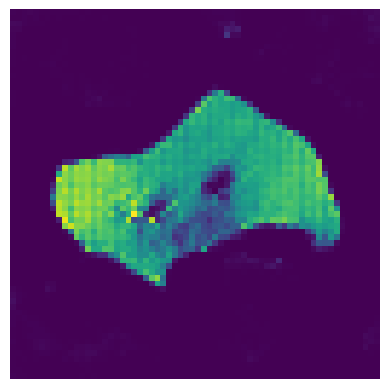

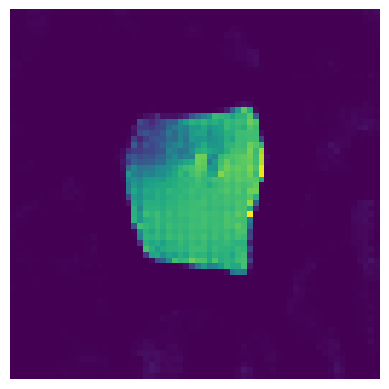

313/313 [==============================] - 84s 263ms/step - d_loss: 7.7158 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00


In [ ]:
dcgan.fit(
    train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

The discriminator and generator are constantly fighting for dominance, which can
make the DCGAN training process unstable. Ideally, the training process will find an
equilibrium that allows the generator to learn meaningful information from the dis‐
criminator and the quality of the images will start to improve.

After enough epochs,
the discriminator tends to end up dominating but this may
not be a problem as the generator may have already learned to produce sufficiently
high-quality images by this point.


It is somewhat miraculous that a neural network is able to convert random noise into
something meaningful. It is worth remembering that we haven’t provided the model
with any additional features beyond the raw pixels, so it has to work out high-level
concepts such as how to draw shadows, cuboids, and circles entirely by itself.

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 581ms/step


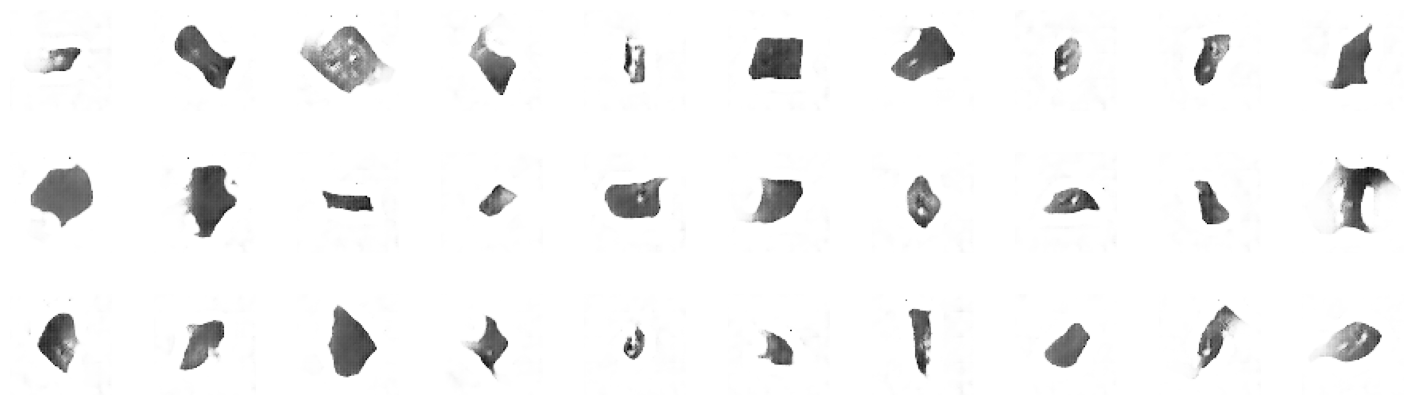

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Another requirement of a successful generative model is that it doesn’t only repro‐
duce images from the training set. To test this, we can find the image from the
training set that is closest to a particular generated example. A good measure for distance is the L1 distance, defined as:

def compare_images(img1, img2):

 return np.mean(np.abs(img1 - img2))


In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 484ms/step


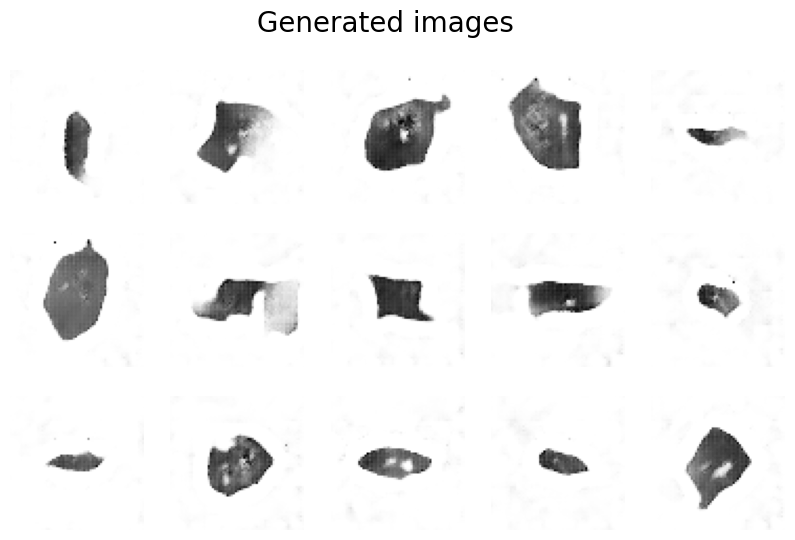

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

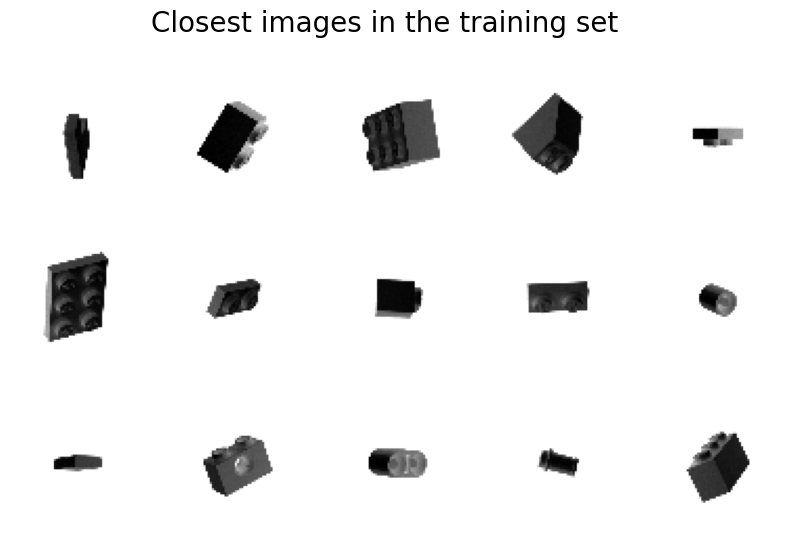

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()